# Calibration in CNNs


In this lab, I will investigate the calibration convolutional CNNs in a classification setting:

- Train a Lenet5 CNN from scratch to classify birds from cats in CIFAR10. Namely, we only consider two categories. Evaluate the reliability diagram and the ECE in the test set.
- Implement a basic temperature scaling (Platt's scaling), where the output probability p(zi) (being zi the logit) is modified by p(az_i), where a is a constant chosen to smooth the output probabilities. Study the effect of parameter a.  Plot the reliability diagram and the ECE after applying the scaling.
- Repeat the same experiment for a much bigger model obtained after fine-tuning a pre-trained model's last classification layer.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time
from sklearn.calibration import calibration_curve

## Dataset uploading and selection of birds and cats images only
We alaso set a random seed manually to reproduce results

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

# Set random seed for reproducibility
seed = 0
torch.manual_seed(seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class_labels = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3,
                'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

# Target transform to map "bird" (2) to 0 and "cat" (3) to 1
target_transform = lambda y: 0 if y == 2 else 1

# Apply target_transform to train and test datasets
full_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform, target_transform=target_transform)
full_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform, target_transform=target_transform)

# Filter indices for "bird" and "cat" classes (no need to map here since target_transform is applied)
bird_cat_indices = [i for i, label in enumerate(full_trainset.targets) if label in (class_labels['bird'], class_labels['cat'])]
bird_cat_test_indices = [i for i, label in enumerate(full_testset.targets) if label in (class_labels['bird'], class_labels['cat'])]

# Create subsets with only "bird" and "cat" samples
bird_cat_trainset = Subset(full_trainset, bird_cat_indices)
bird_cat_testset = Subset(full_testset, bird_cat_test_indices)

# Split trainset into training and validation sets
train_size = int(0.8 * len(bird_cat_trainset))
val_size = len(bird_cat_trainset) - train_size
trainset, valset = random_split(bird_cat_trainset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(bird_cat_testset, batch_size=64, shuffle=False, num_workers=2)

# Class names
classes = ('bird', 'cat')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
traindata = iter(trainloader)

images, labels = next(traindata)

# We will see that the image size matches the supposed input of the Lenet architecture (32x32)
print(images[1].shape)

torch.Size([3, 32, 32])


In [4]:
from torchvision import datasets, transforms, utils

def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig('brids_cats.png')
    plt.show()

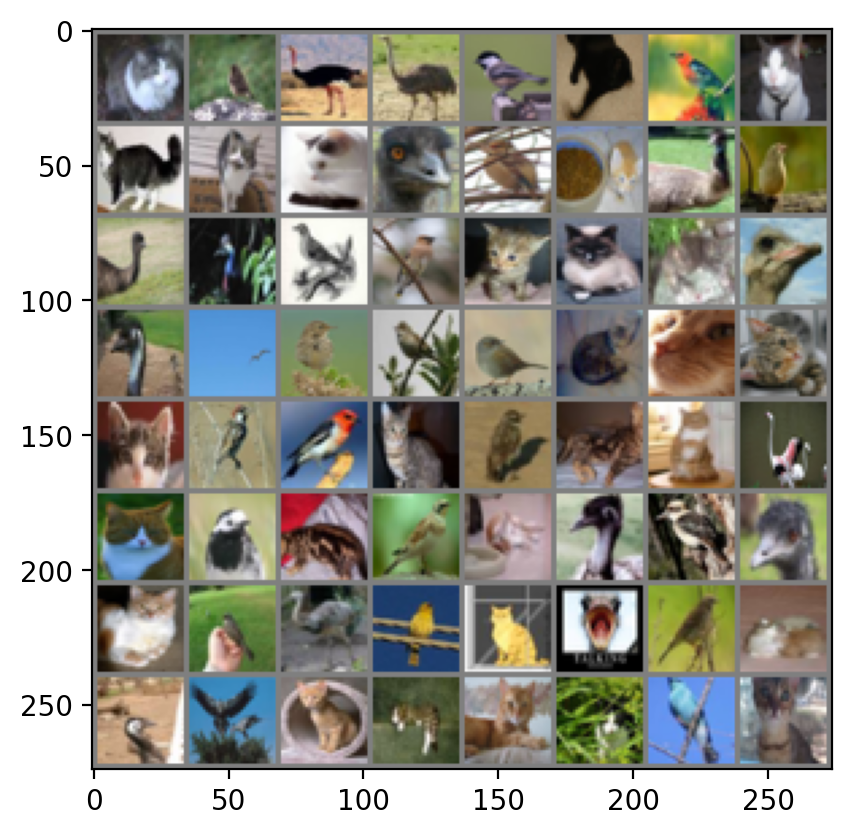

In [5]:
#showing images to show that we only have cats and bird images in the dataset

imshow(utils.make_grid(images))

## Defining the Lenet NN Architecture

In [6]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 2 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,
                               kernel_size=5, stride=1, padding=0)

        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)

        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(400,120)

        self.linear2 = nn.Linear(120,84)

        self.linear3 = nn.Linear(84,2) #this output should be 1 since this has now become a binary problem (cats or birds)

        self.relu = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)  #((32-4)/2-4)/2=5

    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x)
        return x

### Extended class 
- Training 
- Evaluating 
- Using GPU
- Early Stopping

In [7]:
import torch
import time
import numpy as np

class Lenet5_extended_w_GPU(Lenet5):
    def __init__(self, dimx, nlabels, epochs=100, lr=0.001, patience=10):
        super().__init__(dimx, nlabels)

        self.lr = lr
        self.optim = torch.optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.patience = patience  # Patience for early stopping
        self.best_valid_loss = np.inf
        self.early_stop = False
        self.stop_epoch = 0

    def trainloop(self, trainloader, validloader):
        best_epoch = 0
        patience_counter = 0  # Counter for early stopping
        
        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.

            self.train()
            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            train_loss = running_loss / len(trainloader)
            self.loss_during_training.append(train_loss)

            # Validation Loss
            self.eval()
            running_loss = 0.
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    out = self.forward(images)
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()

            valid_loss = running_loss / len(validloader)
            self.valid_loss_during_training.append(valid_loss)

            # Early Stopping Logic
            if valid_loss < self.best_valid_loss:
                self.best_valid_loss = valid_loss
                best_epoch = e
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print(f"Early stopping at epoch {e}. Best epoch was {best_epoch} with validation loss {self.best_valid_loss:.4f}.")
                self.stop_epoch = e
                self.early_stop = True
                break

            if e % 1 == 0:
                print(f"Epoch {e}. Training loss: {train_loss:.4f}, Validation loss: {valid_loss:.4f}, "
                      f"Time per epoch: {time.time() - start_time:.2f} seconds")

    def eval_performance(self, dataloader):
        self.eval()
        accuracy = 0
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy / len(dataloader)


In [8]:
lenet_regular = Lenet5_extended_w_GPU(dimx=32,nlabels=2,epochs=20,lr=1e-3, patience = 5)

lenet_regular

Lenet5_extended_w_GPU(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=2, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)

In [9]:
lenet_regular.trainloop(trainloader,valloader)

Epoch 0. Training loss: 0.6029, Validation loss: 0.5244, Time per epoch: 2.22 seconds
Epoch 1. Training loss: 0.4995, Validation loss: 0.4897, Time per epoch: 1.92 seconds
Epoch 2. Training loss: 0.4680, Validation loss: 0.4920, Time per epoch: 1.97 seconds
Epoch 3. Training loss: 0.4539, Validation loss: 0.4534, Time per epoch: 1.92 seconds
Epoch 4. Training loss: 0.4298, Validation loss: 0.4479, Time per epoch: 1.95 seconds
Epoch 5. Training loss: 0.4149, Validation loss: 0.4424, Time per epoch: 2.00 seconds
Epoch 6. Training loss: 0.3916, Validation loss: 0.4440, Time per epoch: 1.89 seconds
Epoch 7. Training loss: 0.3696, Validation loss: 0.4330, Time per epoch: 1.92 seconds
Epoch 8. Training loss: 0.3458, Validation loss: 0.4694, Time per epoch: 1.92 seconds
Epoch 9. Training loss: 0.3259, Validation loss: 0.4482, Time per epoch: 1.99 seconds
Epoch 10. Training loss: 0.3122, Validation loss: 0.4519, Time per epoch: 1.86 seconds
Epoch 11. Training loss: 0.2935, Validation loss: 0.4

tensor(0.9130)
tensor(0.8081)
tensor(0.8071)


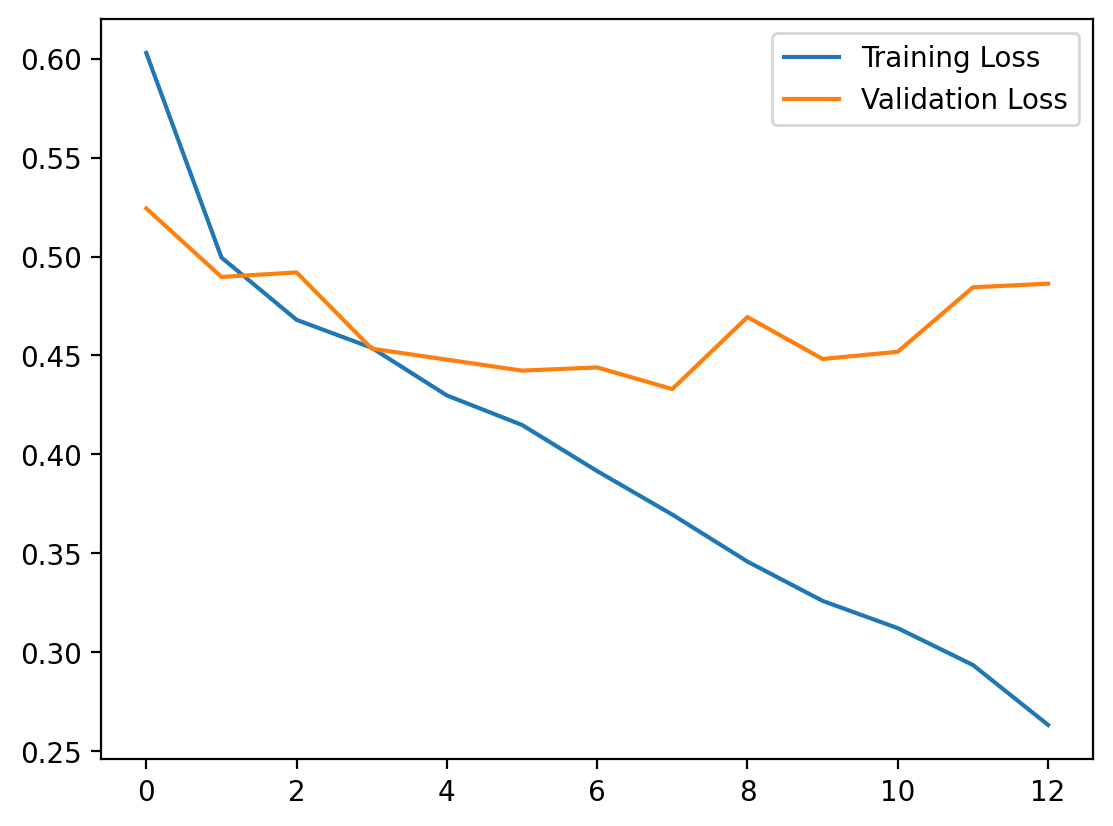

In [10]:
plt.plot(lenet_regular.loss_during_training,label='Training Loss')
plt.plot(lenet_regular.valid_loss_during_training,label='Validation Loss')
plt.savefig('TVL_LENET_REGULAR.png')
plt.legend()

print(lenet_regular.eval_performance(trainloader))
print(lenet_regular.eval_performance(valloader))
print(lenet_regular.eval_performance(testloader))

### The results are not great here. I will also expriment with other models that have dropout and batch norm  

## Defining Lenet NN again but with Batch norm and Dropout

In [11]:
class Lenet5_w_GPU_Drop_BatchNorm(nn.Module):
    def __init__(self,dimx,nlabels,prob, use_batch_norm): 
        super().__init__()
        
        self.use_batch_norm = use_batch_norm

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Batch normalization for conv layers (conditional)
        self.bn1 = nn.BatchNorm2d(6) if use_batch_norm else None
        self.bn2 = nn.BatchNorm2d(16) if use_batch_norm else None
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(400,120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,2)
        
        
        # Batch normalization for linear layers
        self.bn3 = nn.BatchNorm1d(120) if use_batch_norm else None
        self.bn4 = nn.BatchNorm1d(84) if use_batch_norm else None
        
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) 
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.relu(x) 
        x = self.pool(x)
        x = self.dropout(x) 
        
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x) 
        
        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)
        
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x) 
        
        x = self.linear2(x)
        if self.use_batch_norm:
            x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        
        return x

### Extended class 
- Training 
- Evaluating 
- Using GPU
- Early Stopping
- Option to add batch norm and dropout

In [12]:
import torch
import time
import numpy as np

class Lenet5_w_GPU_Drop_BatchNorm_extended(Lenet5_w_GPU_Drop_BatchNorm):
    def __init__(self, dimx, nlabels, prob, use_batch_norm, epochs=100, lr=0.001, patience=10):
        super().__init__(dimx, nlabels, prob, use_batch_norm)

        self.lr = lr  # Learning Rate
        self.optim = torch.optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()  # Ensure model outputs log-probabilities
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.patience = patience  # Early stopping patience
        self.best_valid_loss = np.inf
        self.early_stop = False
        self.stop_epoch = 0

    def trainloop(self, trainloader, validloader):
        best_epoch = 0
        patience_counter = 0

        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.0

            # Training phase
            self.train()
            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            train_loss = running_loss / len(trainloader)
            self.loss_during_training.append(train_loss)

            # Validation phase
            self.eval()
            running_loss = 0.0
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    out = self.forward(images)
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()

            valid_loss = running_loss / len(validloader)
            self.valid_loss_during_training.append(valid_loss)

            # Early Stopping Logic
            if valid_loss < self.best_valid_loss:
                self.best_valid_loss = valid_loss
                best_epoch = e
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print(f"Early stopping at epoch {e}. Best epoch was {best_epoch} with validation loss {self.best_valid_loss:.4f}.")
                self.stop_epoch = e
                self.early_stop = True
                break

            print(f"Epoch {e}. Training loss: {train_loss:.4f}, Validation loss: {valid_loss:.4f}, "
                  f"Time per epoch: {time.time() - start_time:.2f} seconds")

    def eval_performance(self, dataloader):
        self.eval()
        accuracy = 0
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor).to(self.device))

        return accuracy / len(dataloader)

In [13]:
lenet_dropout_no_batch_norm = Lenet5_w_GPU_Drop_BatchNorm_extended(dimx=32,nlabels=2,epochs=20,prob = 0.5, use_batch_norm=False, lr=1e-3, patience = 5)
lenet_dropout_batch_norm = Lenet5_w_GPU_Drop_BatchNorm_extended(dimx=32,nlabels=2,epochs=20,prob = 0.5, use_batch_norm=True, lr=1e-3, patience = 5)

lenet_dropout_no_batch_norm
lenet_dropout_batch_norm 

Lenet5_w_GPU_Drop_BatchNorm_extended(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=2, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (criterion): NLLLoss()
)

In [14]:
print("No batch norm")
lenet_dropout_no_batch_norm.trainloop(trainloader,valloader)
print("\n")
print("batch norm")
lenet_dropout_batch_norm.trainloop(trainloader,valloader)

No batch norm
Epoch 0. Training loss: 0.6513, Validation loss: 0.5904, Time per epoch: 2.05 seconds
Epoch 1. Training loss: 0.5759, Validation loss: 0.5731, Time per epoch: 1.89 seconds
Epoch 2. Training loss: 0.5640, Validation loss: 0.5418, Time per epoch: 1.91 seconds
Epoch 3. Training loss: 0.5402, Validation loss: 0.5354, Time per epoch: 1.93 seconds
Epoch 4. Training loss: 0.5288, Validation loss: 0.5382, Time per epoch: 1.96 seconds
Epoch 5. Training loss: 0.5208, Validation loss: 0.5086, Time per epoch: 1.91 seconds
Epoch 6. Training loss: 0.5166, Validation loss: 0.5347, Time per epoch: 1.94 seconds
Epoch 7. Training loss: 0.5042, Validation loss: 0.4770, Time per epoch: 1.92 seconds
Epoch 8. Training loss: 0.4988, Validation loss: 0.5189, Time per epoch: 1.95 seconds
Epoch 9. Training loss: 0.4922, Validation loss: 0.4966, Time per epoch: 1.98 seconds
Epoch 10. Training loss: 0.4875, Validation loss: 0.4755, Time per epoch: 2.05 seconds
Epoch 11. Training loss: 0.4772, Valida

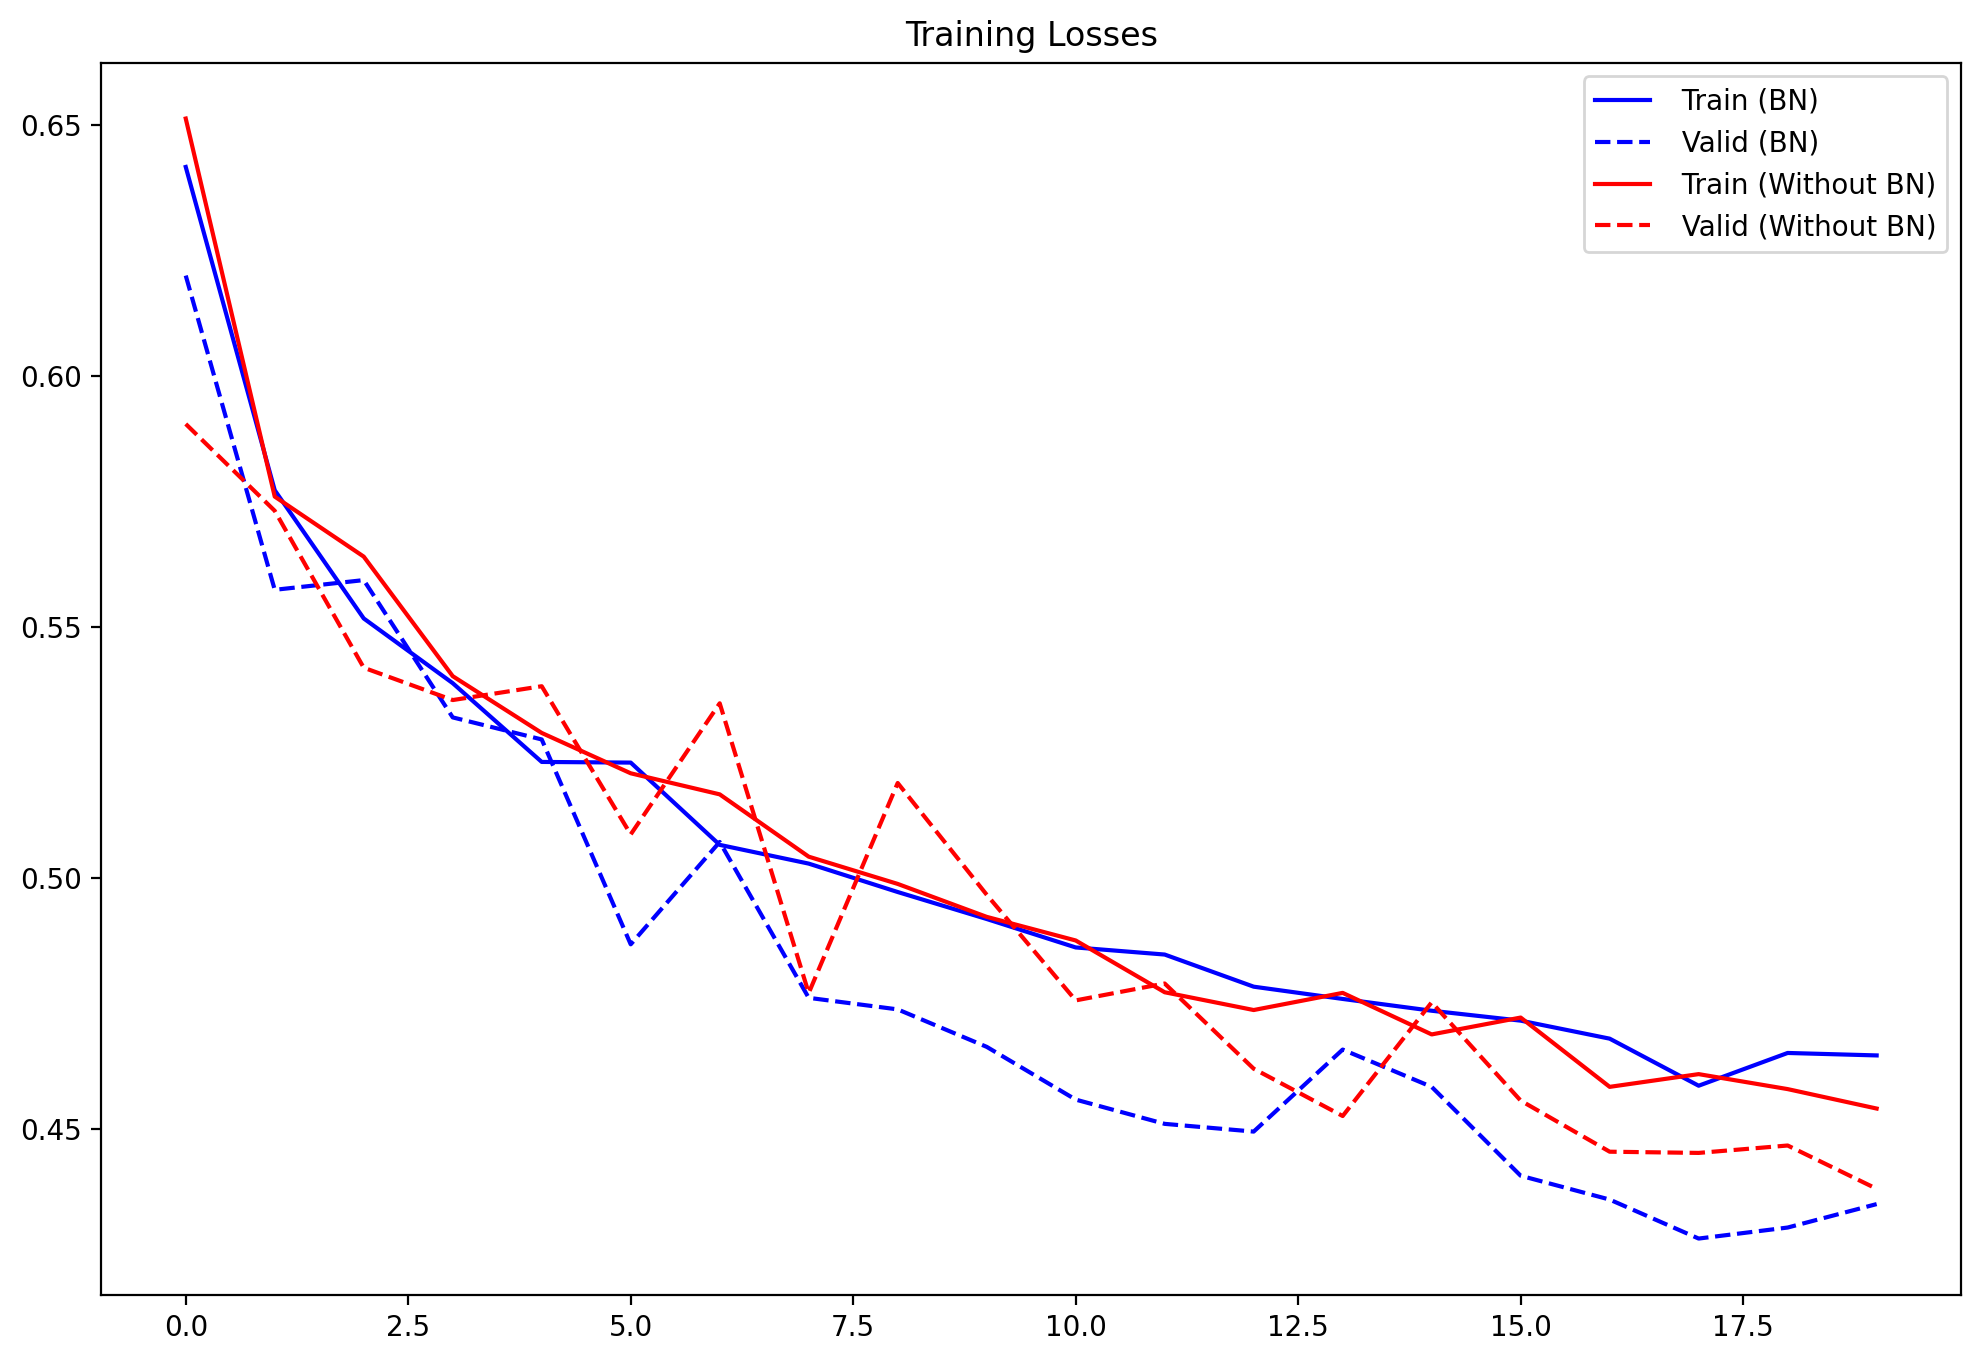

In [15]:
# compare
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(lenet_dropout_batch_norm.loss_during_training, '-b', label=' Train (BN)')
plt.plot(lenet_dropout_batch_norm.valid_loss_during_training,'--b', label=' Valid (BN)')
plt.plot(lenet_dropout_no_batch_norm.loss_during_training, '-r', label=' Train (Without BN)')
plt.plot(lenet_dropout_no_batch_norm.valid_loss_during_training,'--r', label=' Valid (Without BN)')
plt.title("Training Losses")
plt.savefig('TVL_LENET_BN.png')
plt.legend()

In [16]:
print(lenet_dropout_batch_norm.eval_performance(trainloader))
print(lenet_dropout_batch_norm.eval_performance(valloader))
print(lenet_dropout_batch_norm.eval_performance(testloader))

tensor(0.8164, device='cuda:0')
tensor(0.7974, device='cuda:0')
tensor(0.8096, device='cuda:0')


In [17]:
print(lenet_dropout_no_batch_norm.eval_performance(trainloader))
print(lenet_dropout_no_batch_norm.eval_performance(valloader))
print(lenet_dropout_no_batch_norm.eval_performance(testloader))

tensor(0.8291, device='cuda:0')
tensor(0.8081, device='cuda:0')
tensor(0.8120, device='cuda:0')


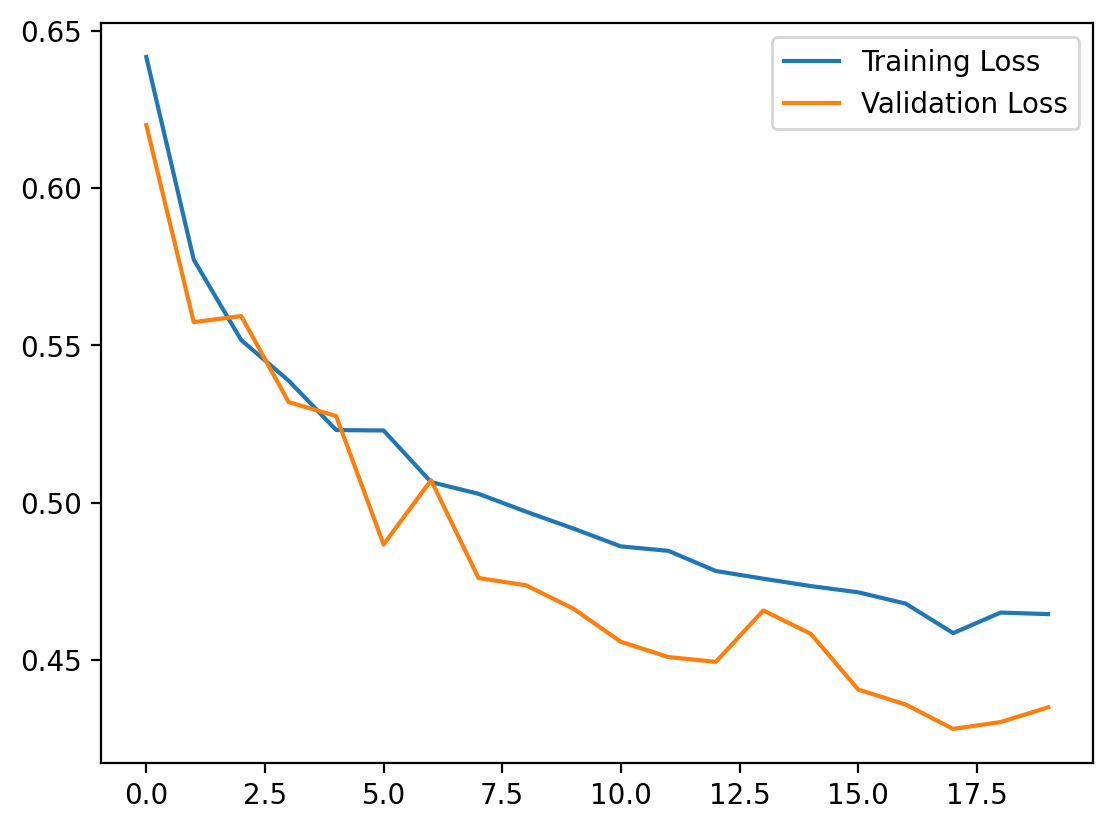

In [18]:
plt.plot(lenet_dropout_batch_norm.loss_during_training,label='Training Loss')
plt.plot(lenet_dropout_batch_norm.valid_loss_during_training,label='Validation Loss')
plt.savefig('TVL_BEST_MODEL.png')
plt.legend()

We are using this model with batch norm. It provides lower signs of overfitting and has a very cimilar accuracy to the other models. So we can say it generalizes well which is what we are also looking for in these types of tasks. 

## Reliability Diagram and ECE

Evaluates model calibration by creating a reliability diagram and computing Expected Calibration Error (ECE).

The reliability diagram plots predicted probabilities against empirical probabilities using binning, showing how 
well-calibrated the model's probability estimates are. A perfectly calibrated model would follow the diagonal line.
The Expected Calibration Error (ECE) quantifies the average absolute difference between predicted and actual 
probabilities across bins.

Choosing Between Uniform and Quantile Binning:

- **Uniform Binning** is preferable when you want to evaluate calibration performance evenly across the entire probability spectrum, and when the predicted probabilities are relatively uniformly distributed.
- **Quantile Binning** is advantageous when dealing with skewed probability distributions, as it ensures each bin has a sufficient number of samples, leading to more reliable calibration estimates.

In [19]:
def plot_reliability_diagram(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, pos_label=0, n_bins=n_bins, strategy= 'quantile') #'uniform')
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Empirical Probability')
    plt.title('Reliability Diagram')
    plt.show()
    # Calculate ECE
    hist_counts, _ = np.histogram(y_prob, bins=len(prob_pred), range=(0, 1))
    bin_weights = hist_counts / np.sum(hist_counts)
    ece = np.sum(bin_weights * np.abs(prob_pred - prob_true))

    print(f"Expected Calibration Error (ECE): {ece:.4f}")
    return ece

def get_y_true_y_prob(model, test_loader):
    # Set model to evaluation mode
    model.eval()
    model.cpu()

    # Initialize lists to store true labels and predicted probabilities
    y_true = []
    y_prob = []

    # Predict probabilities on the test set
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model.forward(images)
            probabilities = nn.functional.softmax(outputs, dim=1)
            y_true.extend(labels.numpy())
            y_prob.extend(probabilities.numpy()[:, 0])  # Probability of being in positive class 0 (bird)

    return y_true, y_prob

In [20]:
model = lenet_dropout_batch_norm #to simplify 

Base model calibration:


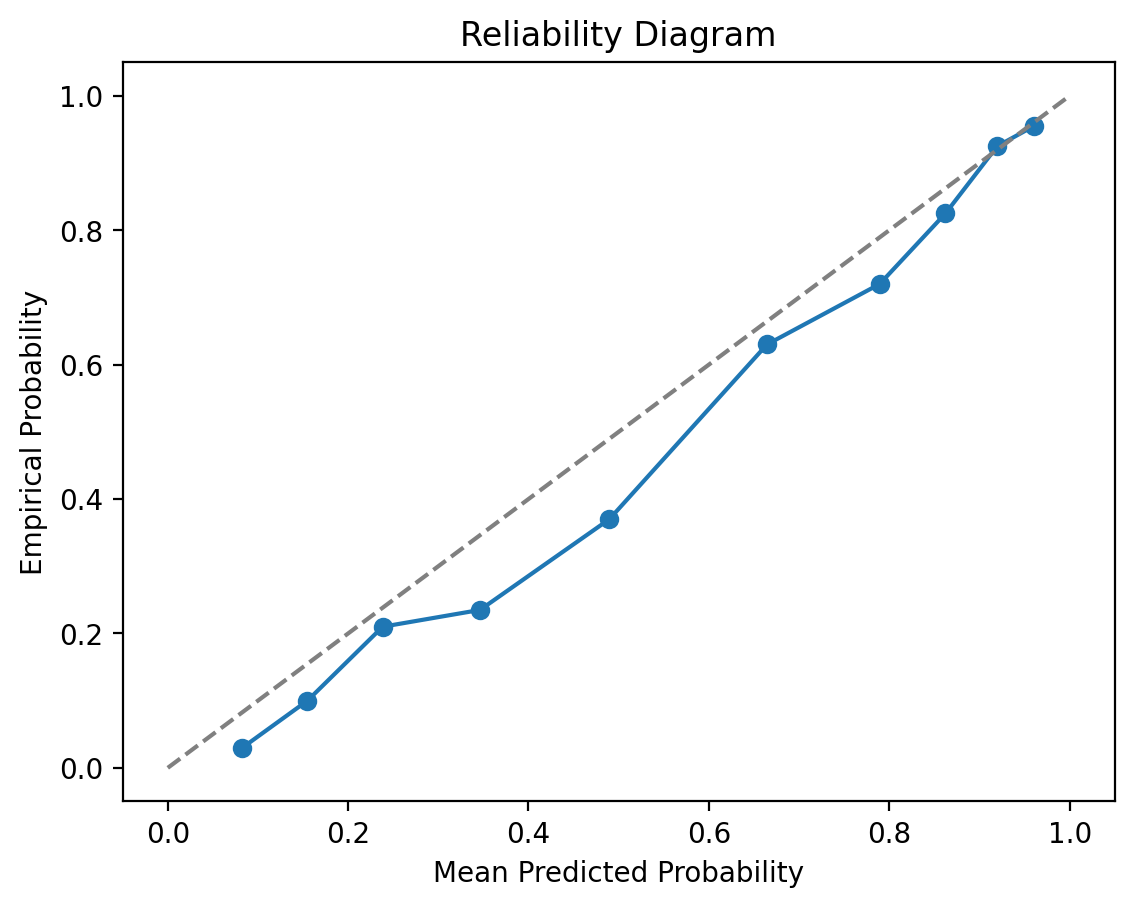

Expected Calibration Error (ECE): 0.0420


In [21]:
# Evaluate base model
print("Base model calibration:")

y_true, y_prob = get_y_true_y_prob(model, testloader)
ece = plot_reliability_diagram(y_true, y_prob, n_bins=10)

# Platt Scalling

## Optimize Temperature 

In [22]:
class Temperature(nn.Module):
    def __init__(self, model):
        super(Temperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)  # Start at 1.5
        self.model.eval()  # Ensure model is in eval mode
        
    def forward(self, input):
        with torch.no_grad():  # Don't track gradients for model forward pass
            logits = self.model(input)
        return self.temperature_scale(logits)
    
    def temperature_scale(self, logits):
        # Temperature scaling is applied uniformly to all logits
        # No need for expansion, simple division is sufficient
        return logits / self.temperature
    
    def calibrate(self, valid_loader, lr=0.01, max_iter=1000, patience=3):
        nll_criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam([self.temperature], lr=lr)
        
        # Precompute logits
        logits_list = []
        labels_list = []
        self.model.eval()  # Ensure model is in eval mode
        with torch.no_grad():
            for inputs, labels in valid_loader:
                logits = self.model(inputs)
                logits_list.append(logits)
                labels_list.append(labels)
        
        logits = torch.cat(logits_list)
        labels = torch.cat(labels_list)
        
        # Print initial NLL
        before_temperature = self.temperature.item()
        before_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        print(f'Before calibration - Temperature: {before_temperature:.3f}, NLL: {before_nll:.3f}')
        
        # Training loop with early stopping
        best_nll = float('inf')
        patience_counter = 0
        
        for i in range(max_iter):
            optimizer.zero_grad()
            scaled_logits = self.temperature_scale(logits)
            loss = nll_criterion(scaled_logits, labels)
            loss.backward()
            optimizer.step()
            
            current_nll = loss.item()
            
            if current_nll < best_nll:
                best_nll = current_nll
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f'Early stopping at iteration {i}')
                break
                
            if (i + 1) % 10 == 0:  # Print progress every 10 iterations
                print(f'Iteration {i+1}, NLL: {current_nll:.3f}, Temperature: {self.temperature.item():.3f}')
        
        final_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        print(f'\nCalibration completed:')
        print(f'Initial Temperature: {before_temperature:.3f} → Final Temperature: {self.temperature.item():.3f}')
        print(f'NLL: {before_nll:.3f} → {final_nll:.3f}')
        
        return self

In [23]:
# Find best temperature using optimization
model_wth_temp = Temperature(model)

model_wth_temp.calibrate(valloader)

Before calibration - Temperature: 1.500, NLL: 0.462
Iteration 10, NLL: 0.456, Temperature: 1.400
Iteration 20, NLL: 0.450, Temperature: 1.301
Iteration 30, NLL: 0.444, Temperature: 1.203
Iteration 40, NLL: 0.439, Temperature: 1.110
Iteration 50, NLL: 0.436, Temperature: 1.025
Iteration 60, NLL: 0.434, Temperature: 0.957
Iteration 70, NLL: 0.433, Temperature: 0.911
Early stopping at iteration 76

Calibration completed:
Initial Temperature: 1.500 → Final Temperature: 0.894
NLL: 0.462 → 0.433


Temperature(
  (model): Lenet5_w_GPU_Drop_BatchNorm_extended(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear1): Linear(in_features=400, out_features=120, bias=True)
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (linear3): Linear(in_features=84, out_features=2, bias=True)
    (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (logsoftmax): LogSoftmax(dim=1)
    (dropout): Dropout(p=0.5, inplace=False)
    (criterion): NLLLoss()
  )
)

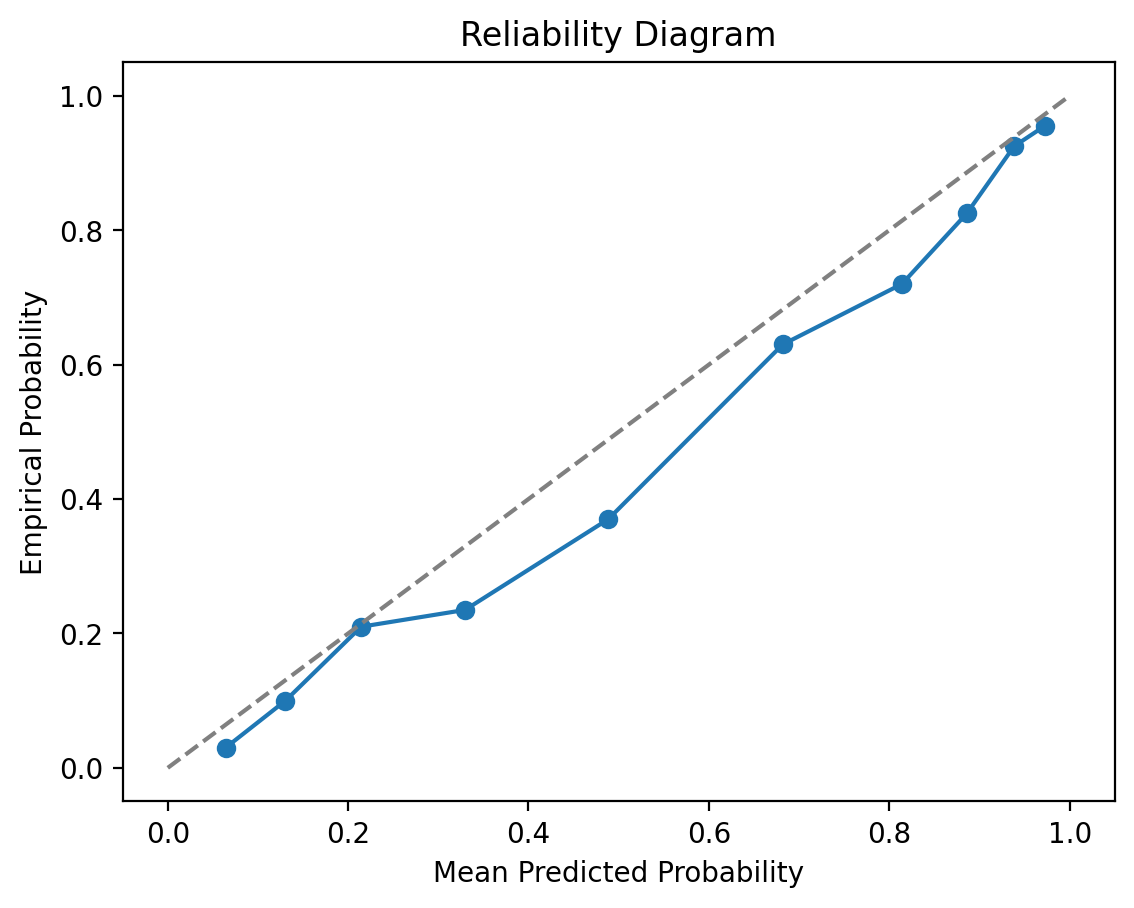

Expected Calibration Error (ECE): 0.0395


In [24]:
y_true_temp, y_prob_temp = get_y_true_y_prob(model_wth_temp, testloader)

# Plot reliability diagram and print ECE
ece_2 = plot_reliability_diagram(y_true_temp, y_prob_temp, n_bins=10)

## Study Temperature change effects

In [44]:
def study_temperature_effect(model_name, base_model, test_loader, 
                           temperatures=np.linspace(0.1, 5.0, 20)):
    """
    Study the effect of different temperature values on calibration.
    """
    results = []
    best_ece = float('inf')
    best_temp = None
    
    # Store calibration curves for final combined plot
    all_curves = []
    
    for temp in temperatures:
        # Create scaled model with specific temperature
        scaled_model = Temperature(base_model)
        scaled_model.temperature.data = torch.tensor([temp])
        
        # Get predictions and calculate ECE
        y_true, y_prob = get_y_true_y_prob(scaled_model, test_loader)
        
        print(f"Temperature: {temp:.3f}") 
        # Get calibration curve data before plotting
        prob_true, prob_pred = calibration_curve(y_true, y_prob, pos_label=0, n_bins=10, strategy='quantile')
        all_curves.append({'temp': temp, 'true': prob_true, 'pred': prob_pred})
        
        # Your original plotting
        ece = plot_reliability_diagram(y_true, y_prob, n_bins=10)
        
        results.append({'temperature': temp, 'ece': ece})
        
        if ece < best_ece:
            best_ece = ece
            best_temp = temp
    print(f"\nBest temperature: {best_temp:.3f} with ECE: {best_ece:.4f}")
    
    # Plot temperature vs ECE
    plt.figure(figsize=(8, 6))
    plt.plot([r['temperature'] for r in results], 
             [r['ece'] for r in results], 
             'b-', marker='o')
    plt.xlabel('Temperature')
    plt.ylabel('ECE')
    plt.title('Temperature vs Expected Calibration Error')
    plt.savefig(f'{model_name}_TvsEC.png')
    plt.grid(True)
    plt.show()
    
    # Add combined reliability plot
    plt.figure(figsize=(10, 8))
    
    # Plot perfect calibration line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
    
    # Create color gradient for different temperatures
    colors = plt.cm.viridis(np.linspace(0, 1, len(temperatures)))
    
    # Plot all reliability curves
    for curve, color in zip(all_curves, colors):
        plt.plot(curve['pred'], curve['true'], 
                color=color, marker='o', linestyle='-',
                label=f'T={curve["temp"]:.1f}')
    
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Empirical Probability')
    plt.title('Combined Reliability Diagram')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{model_name}_combined_reliability.png', 
                bbox_inches='tight')
    plt.show()
    
    return results

Temperature: 0.100


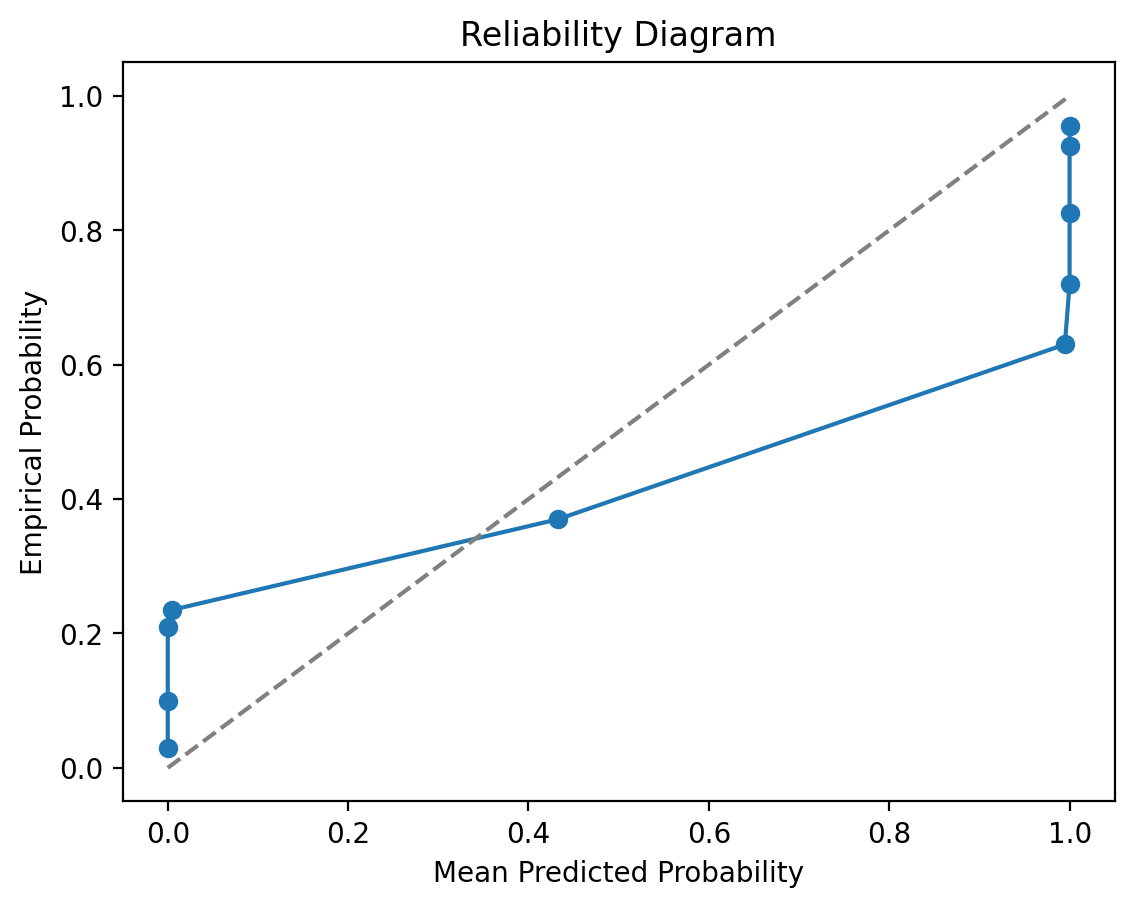

Expected Calibration Error (ECE): 0.0462
Temperature: 0.358


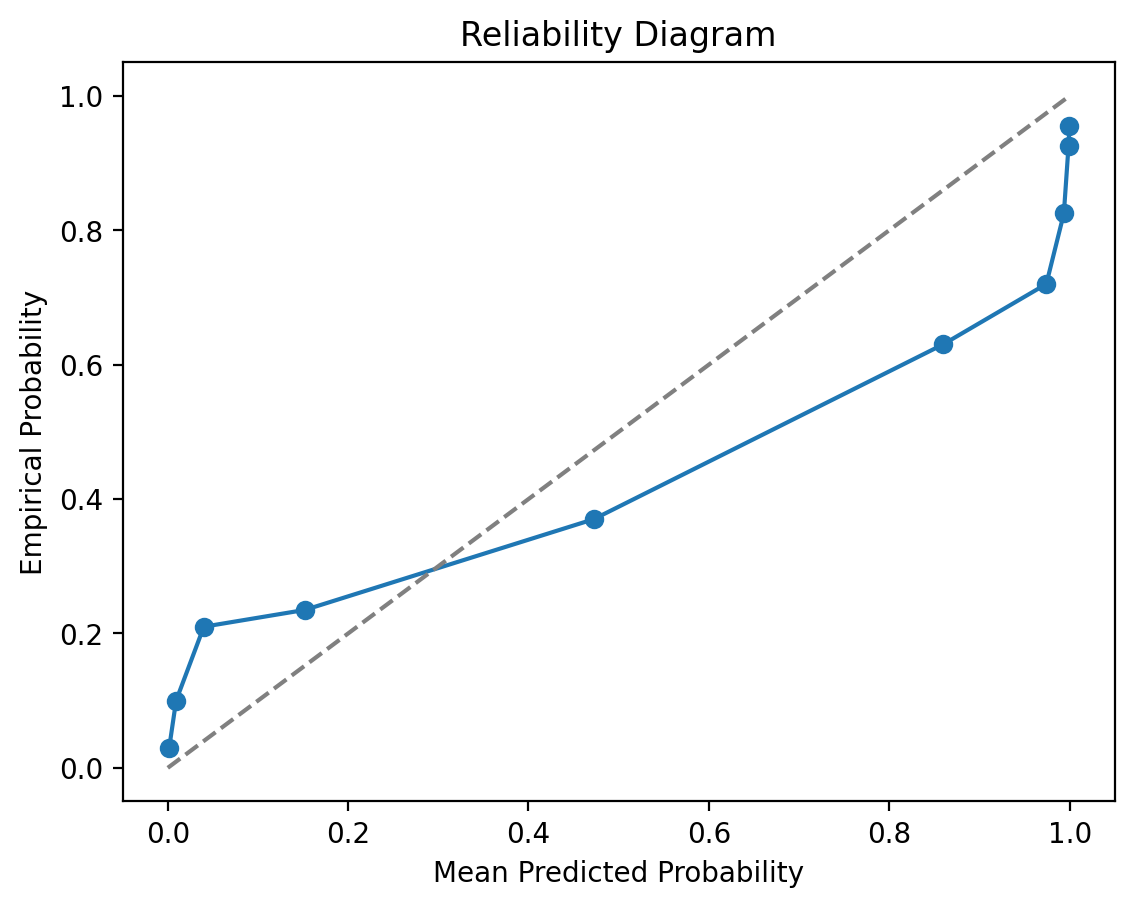

Expected Calibration Error (ECE): 0.0600
Temperature: 0.616


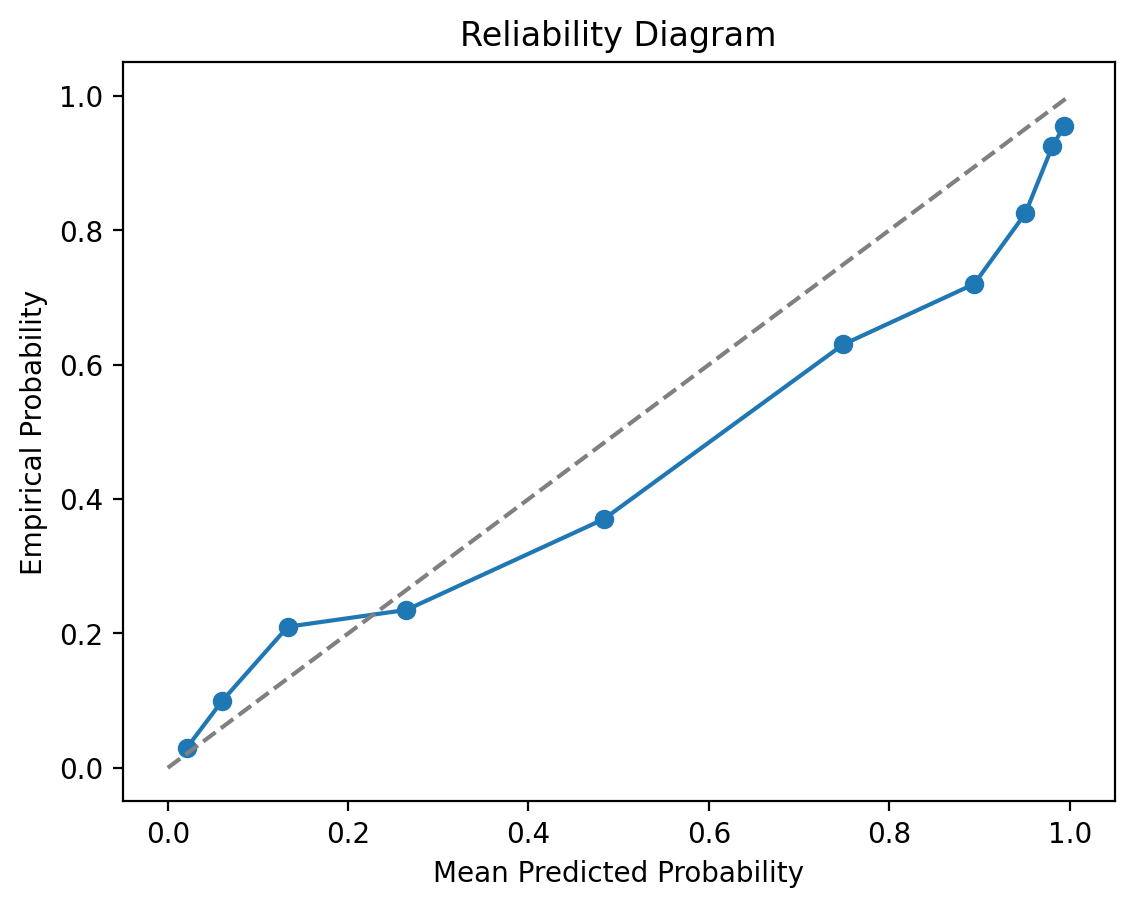

Expected Calibration Error (ECE): 0.0500
Temperature: 0.874


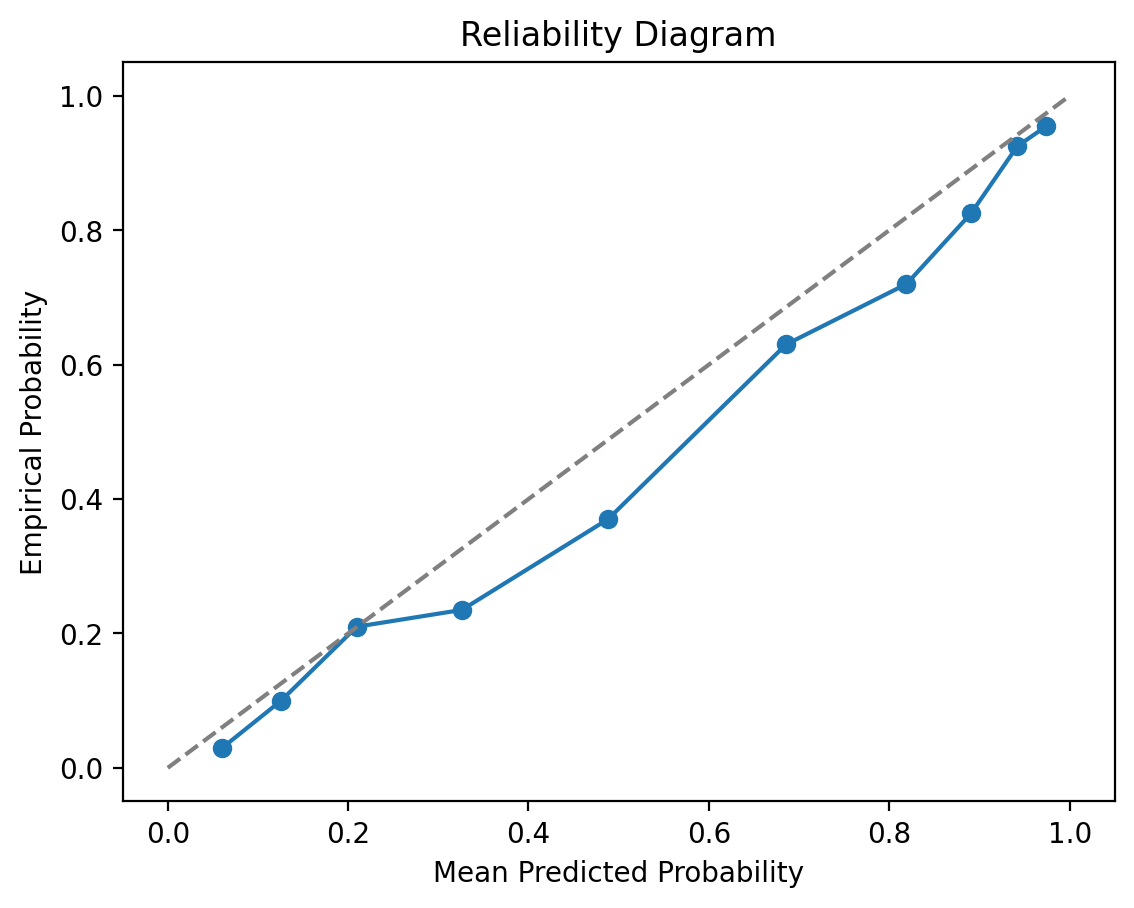

Expected Calibration Error (ECE): 0.0390
Temperature: 1.132


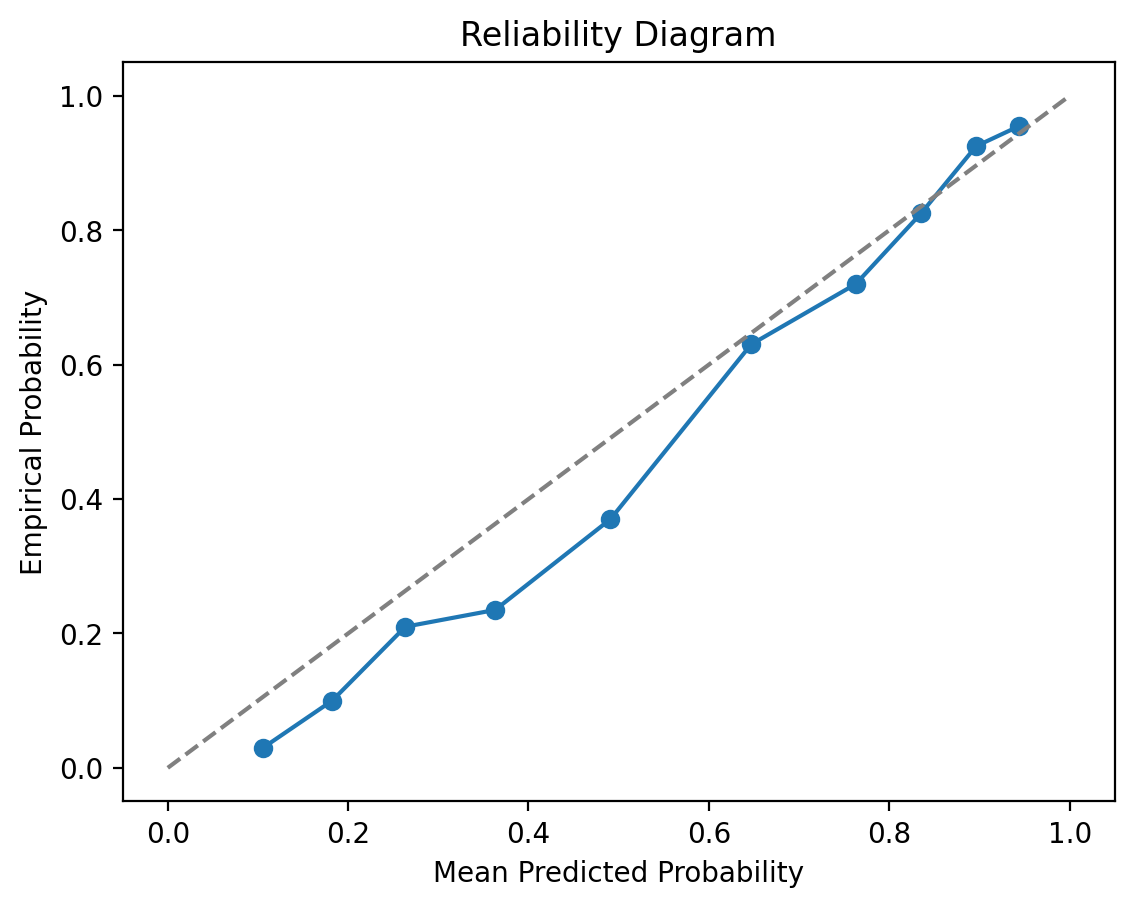

Expected Calibration Error (ECE): 0.0528
Temperature: 1.389


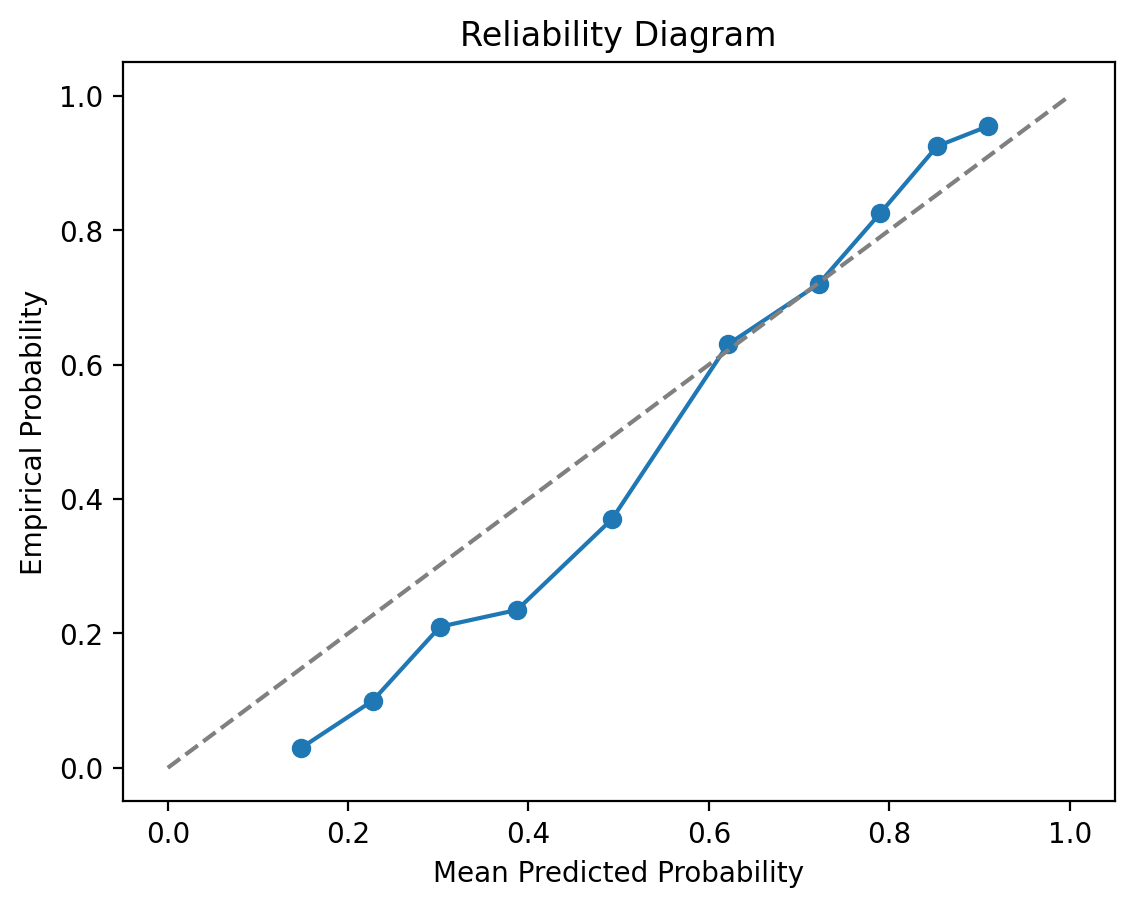

Expected Calibration Error (ECE): 0.0768
Temperature: 1.647


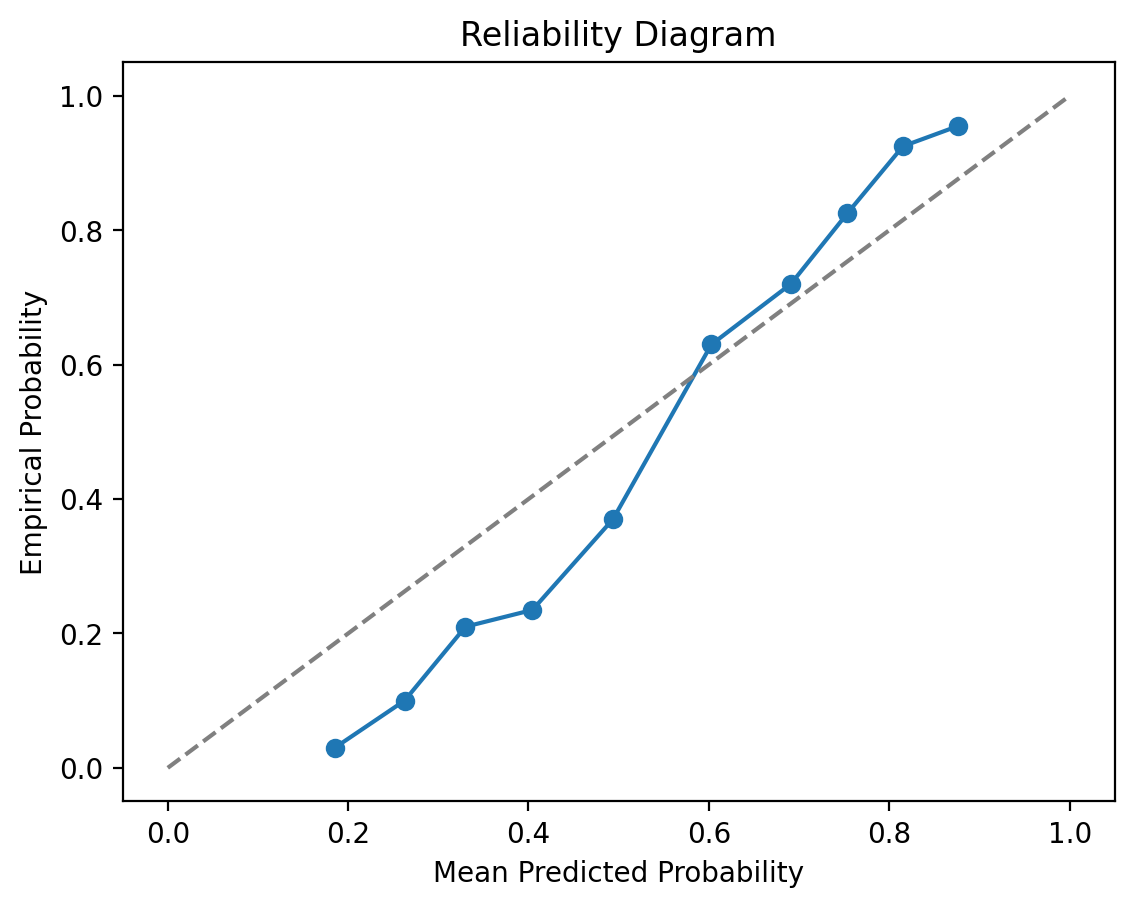

Expected Calibration Error (ECE): 0.1007
Temperature: 1.905


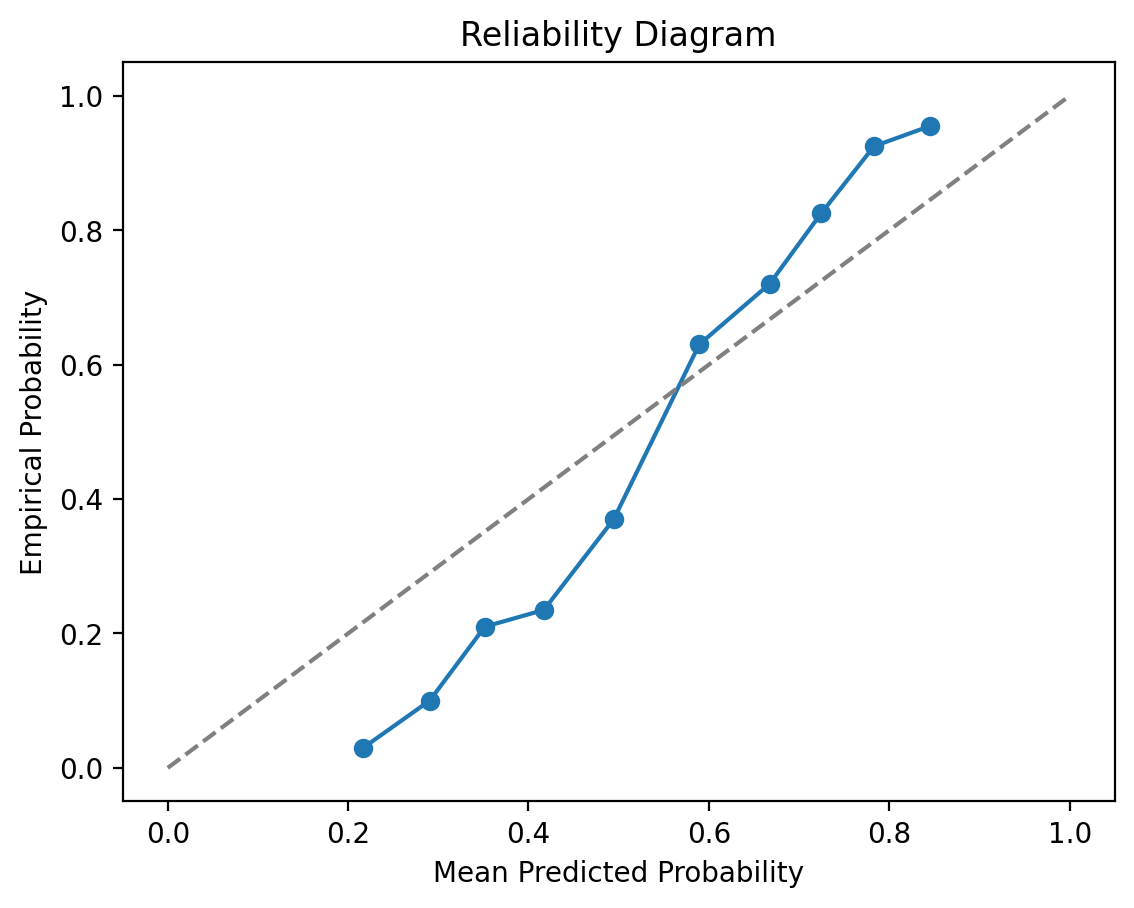

Expected Calibration Error (ECE): 0.1164
Temperature: 2.163


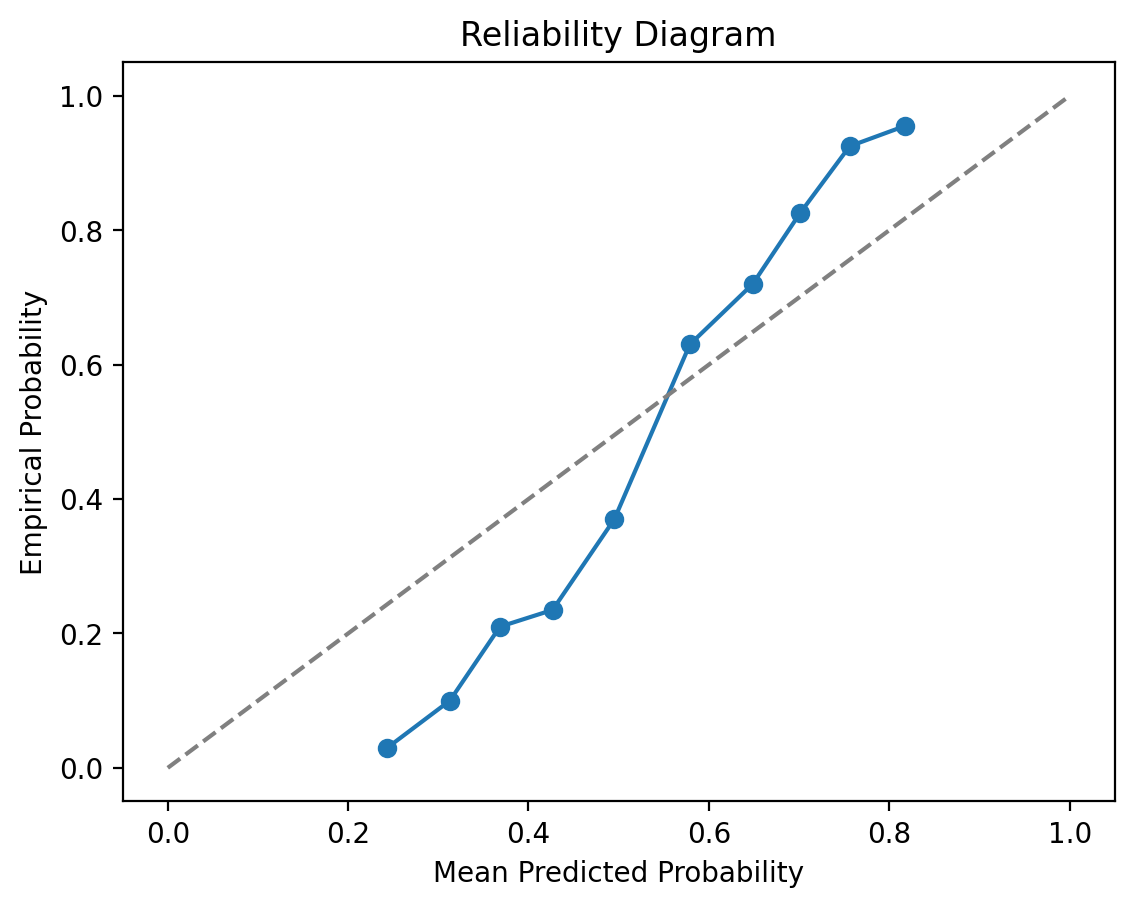

Expected Calibration Error (ECE): 0.1266
Temperature: 2.421


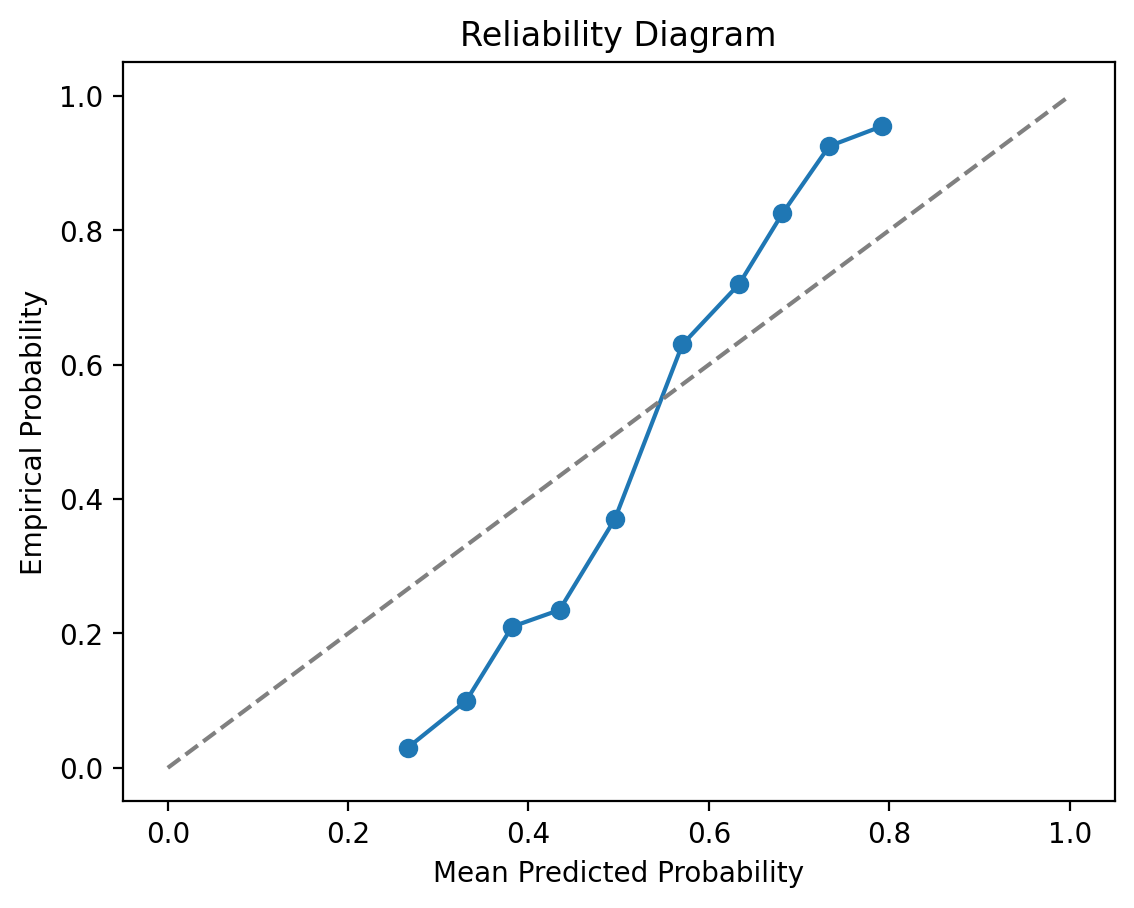

Expected Calibration Error (ECE): 0.1335
Temperature: 2.679


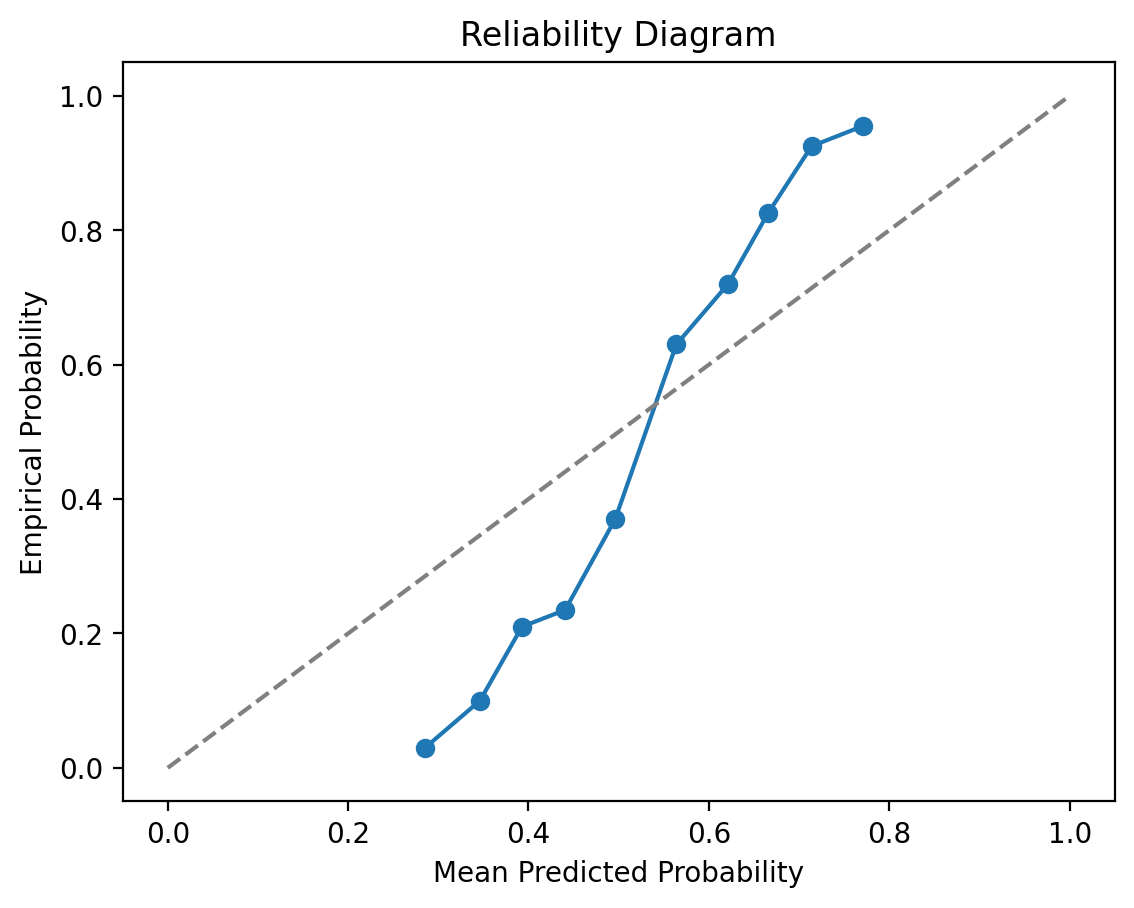

Expected Calibration Error (ECE): 0.1379
Temperature: 2.937


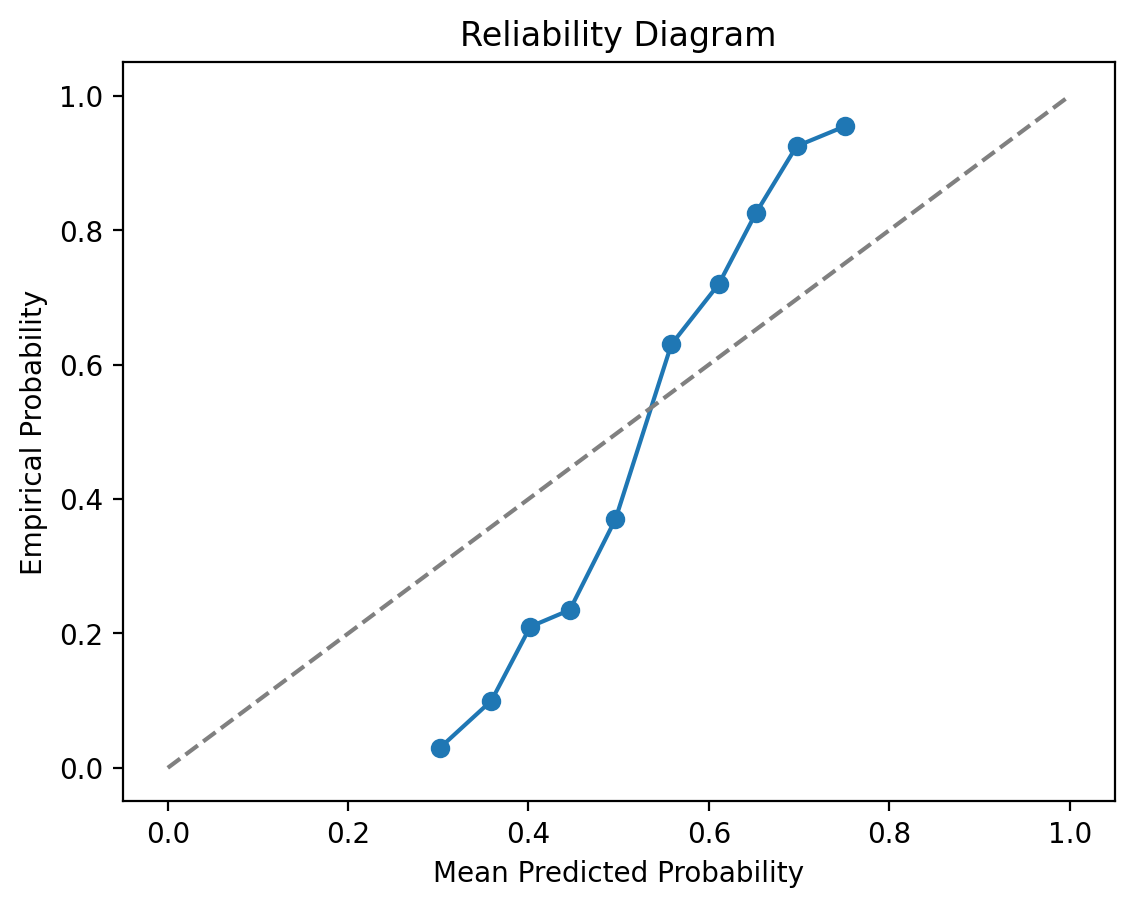

Expected Calibration Error (ECE): 0.1406
Temperature: 3.195


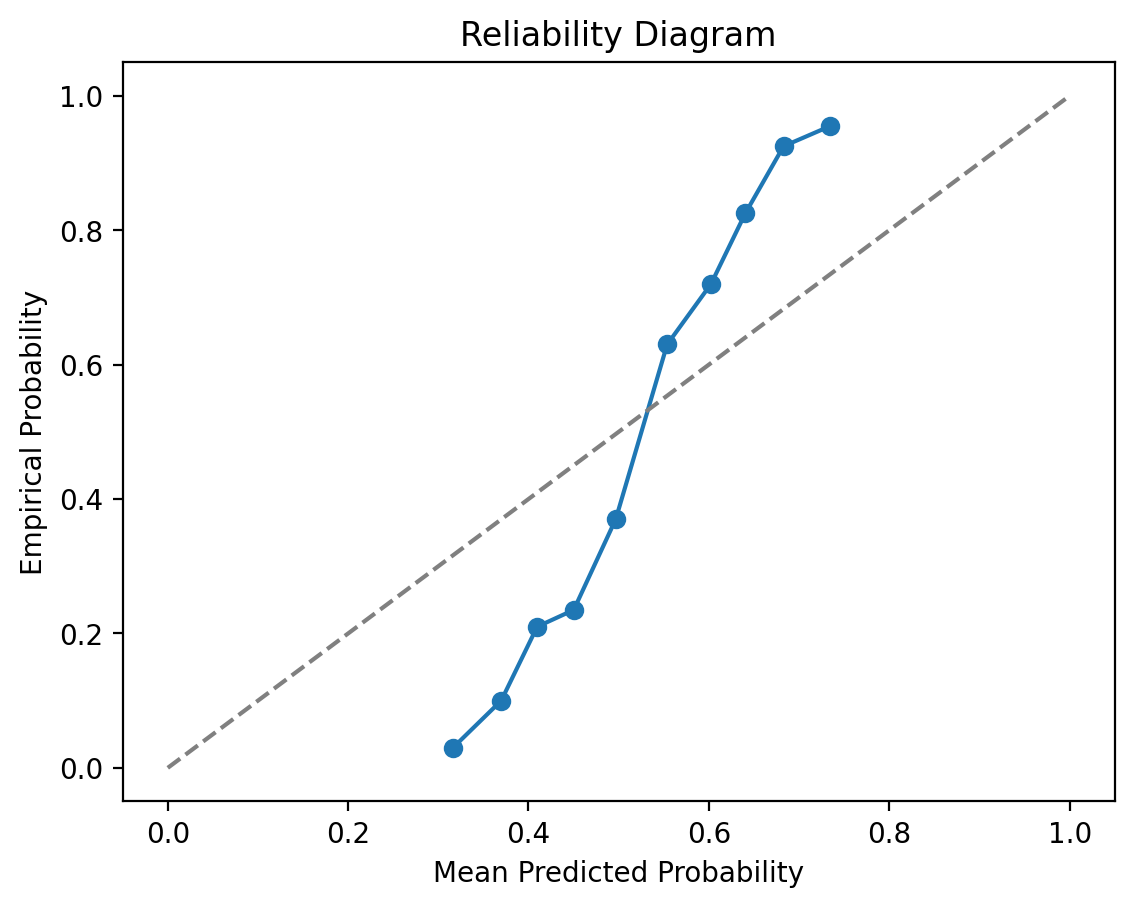

Expected Calibration Error (ECE): 0.1410
Temperature: 3.453


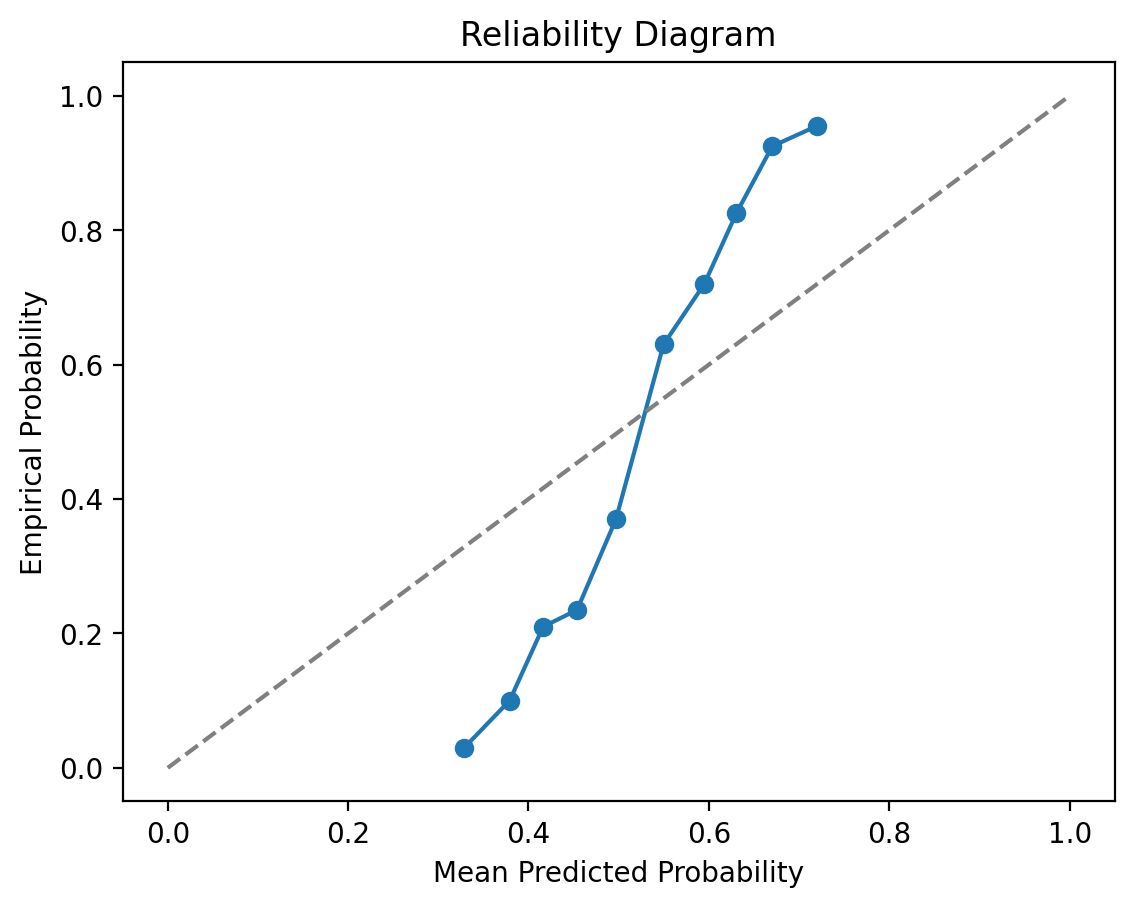

Expected Calibration Error (ECE): 0.1407
Temperature: 3.711


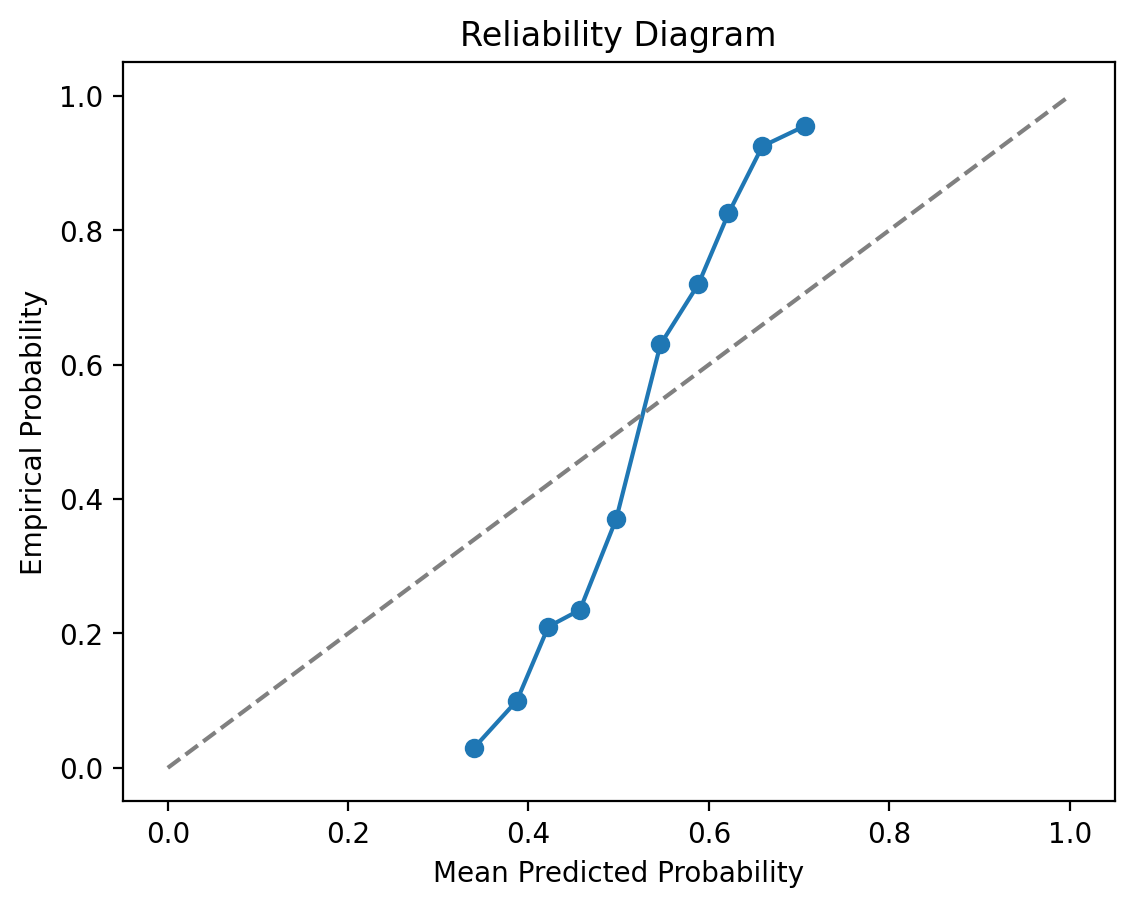

Expected Calibration Error (ECE): 0.1402
Temperature: 3.968


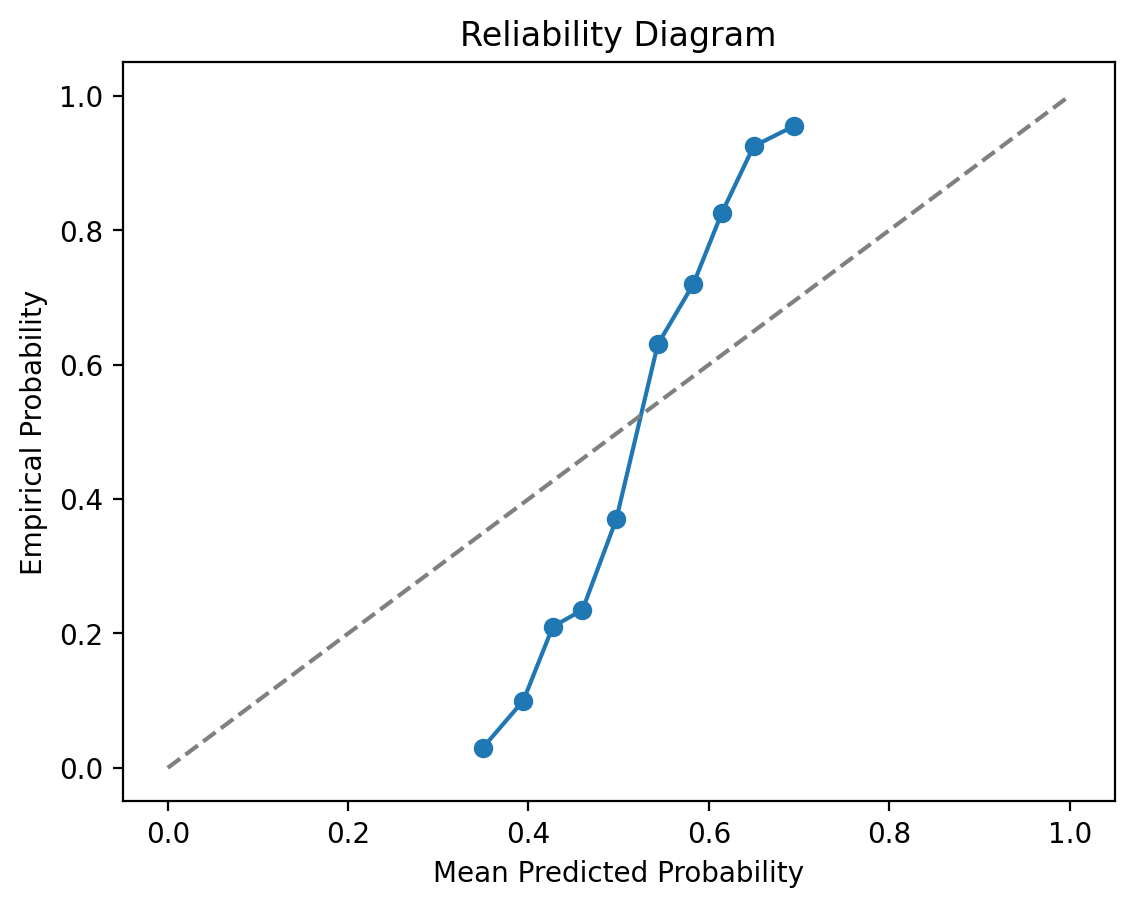

Expected Calibration Error (ECE): 0.1389
Temperature: 4.226


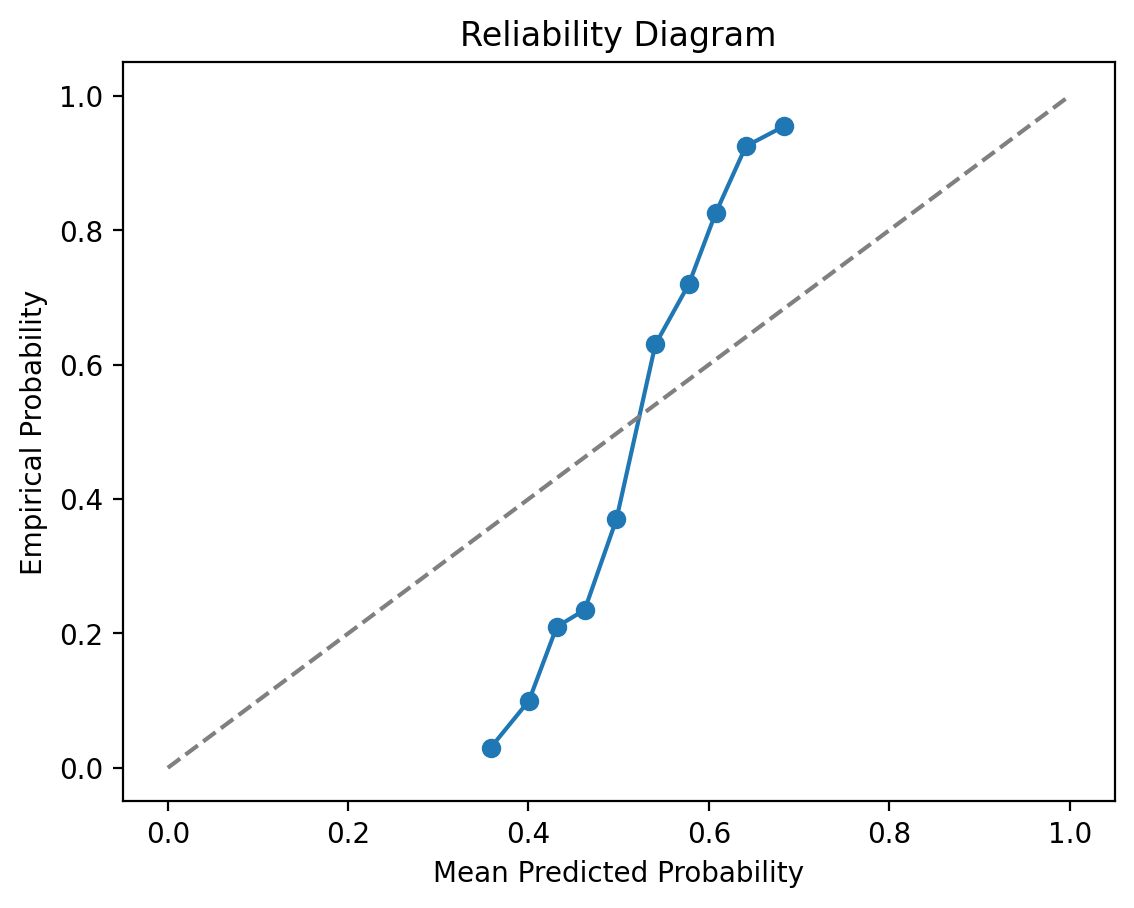

Expected Calibration Error (ECE): 0.1379
Temperature: 4.484


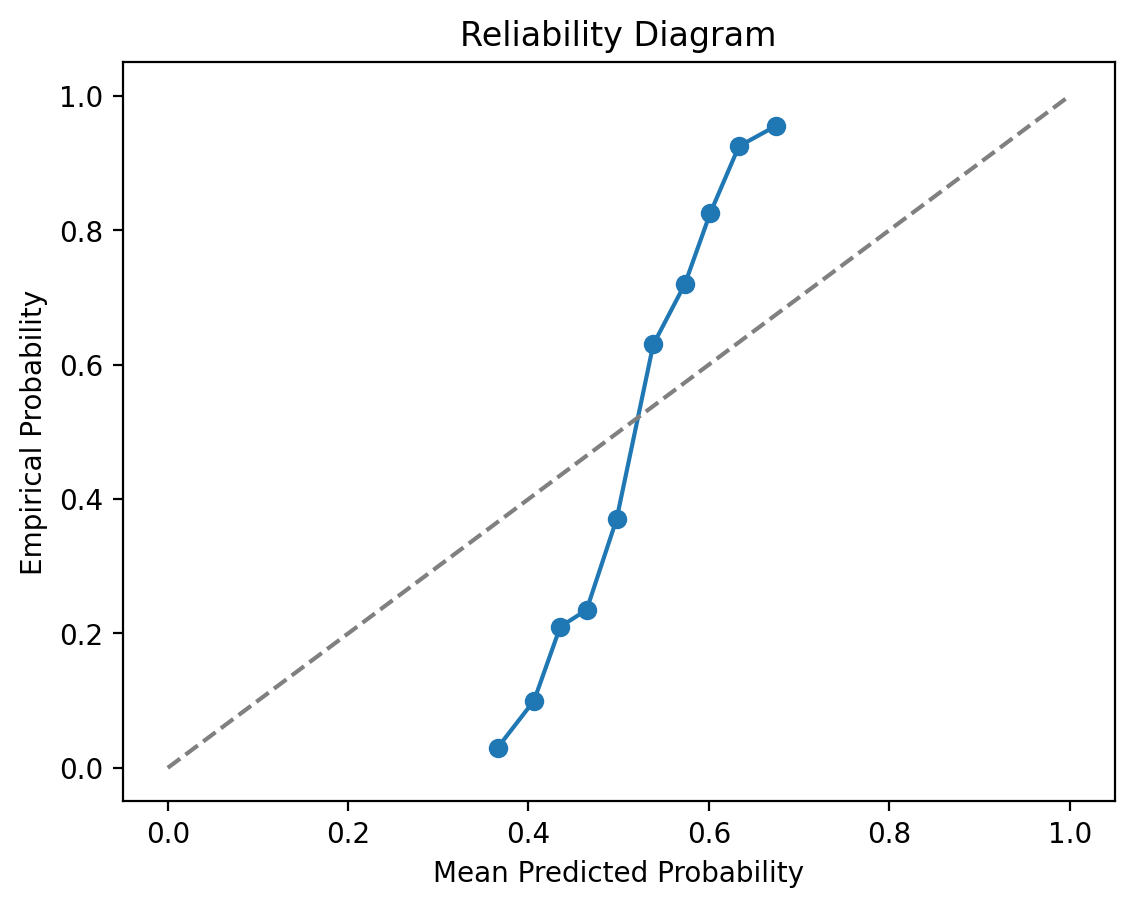

Expected Calibration Error (ECE): 0.1362
Temperature: 4.742


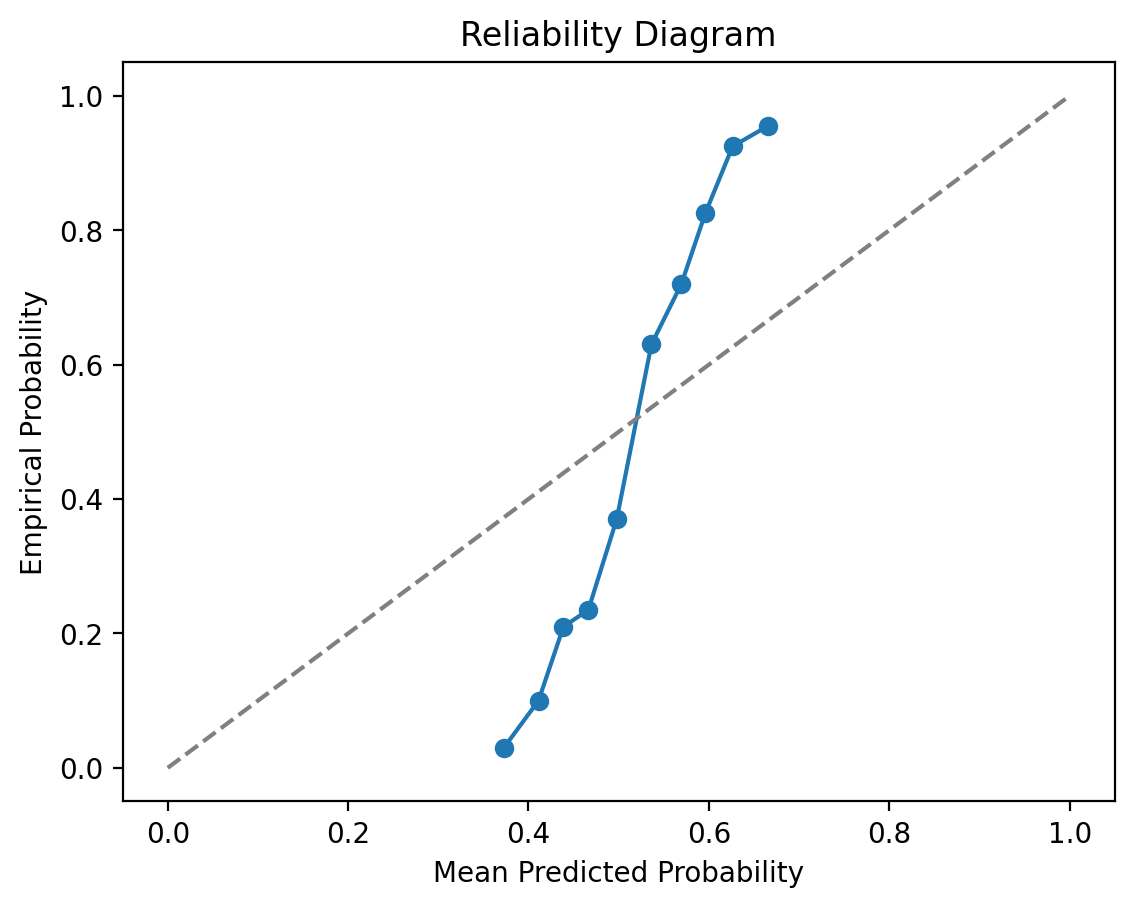

Expected Calibration Error (ECE): 0.1343
Temperature: 5.000


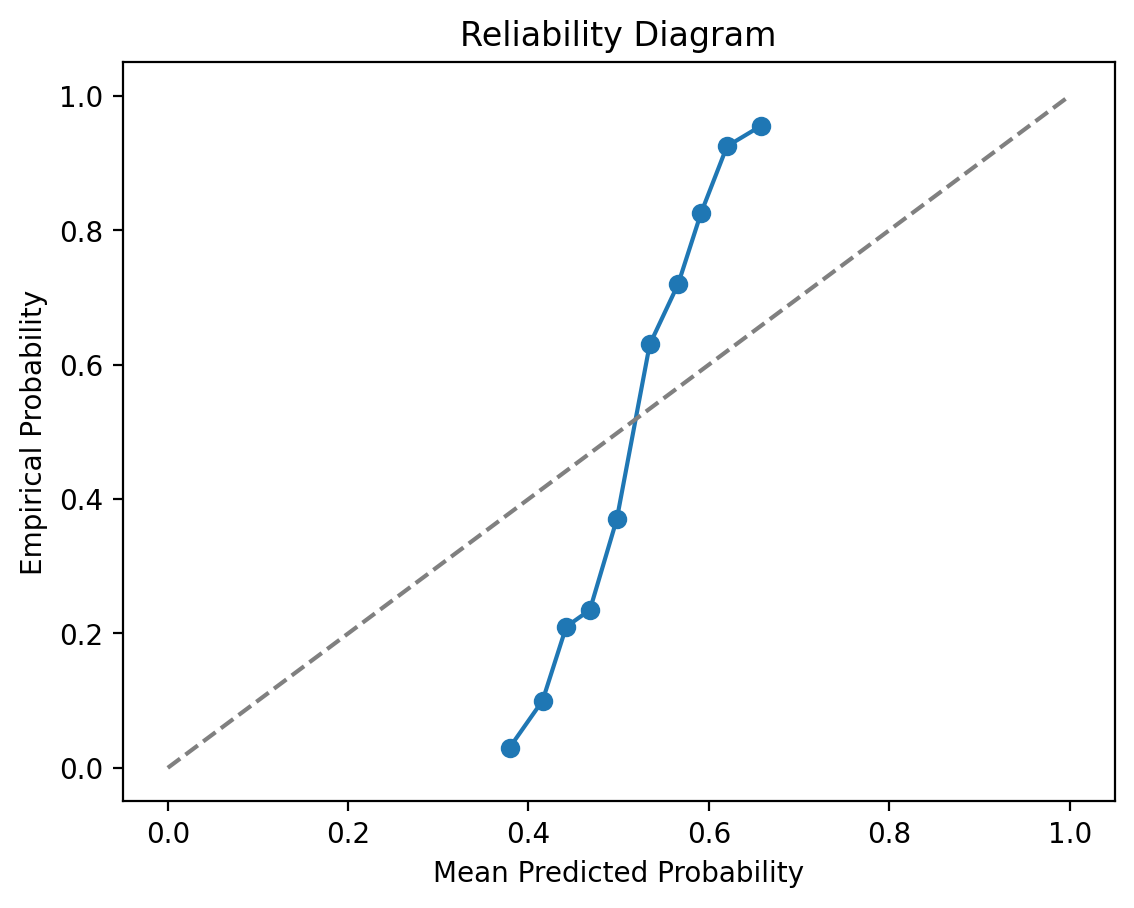

Expected Calibration Error (ECE): 0.1328

Best temperature: 0.874 with ECE: 0.0390


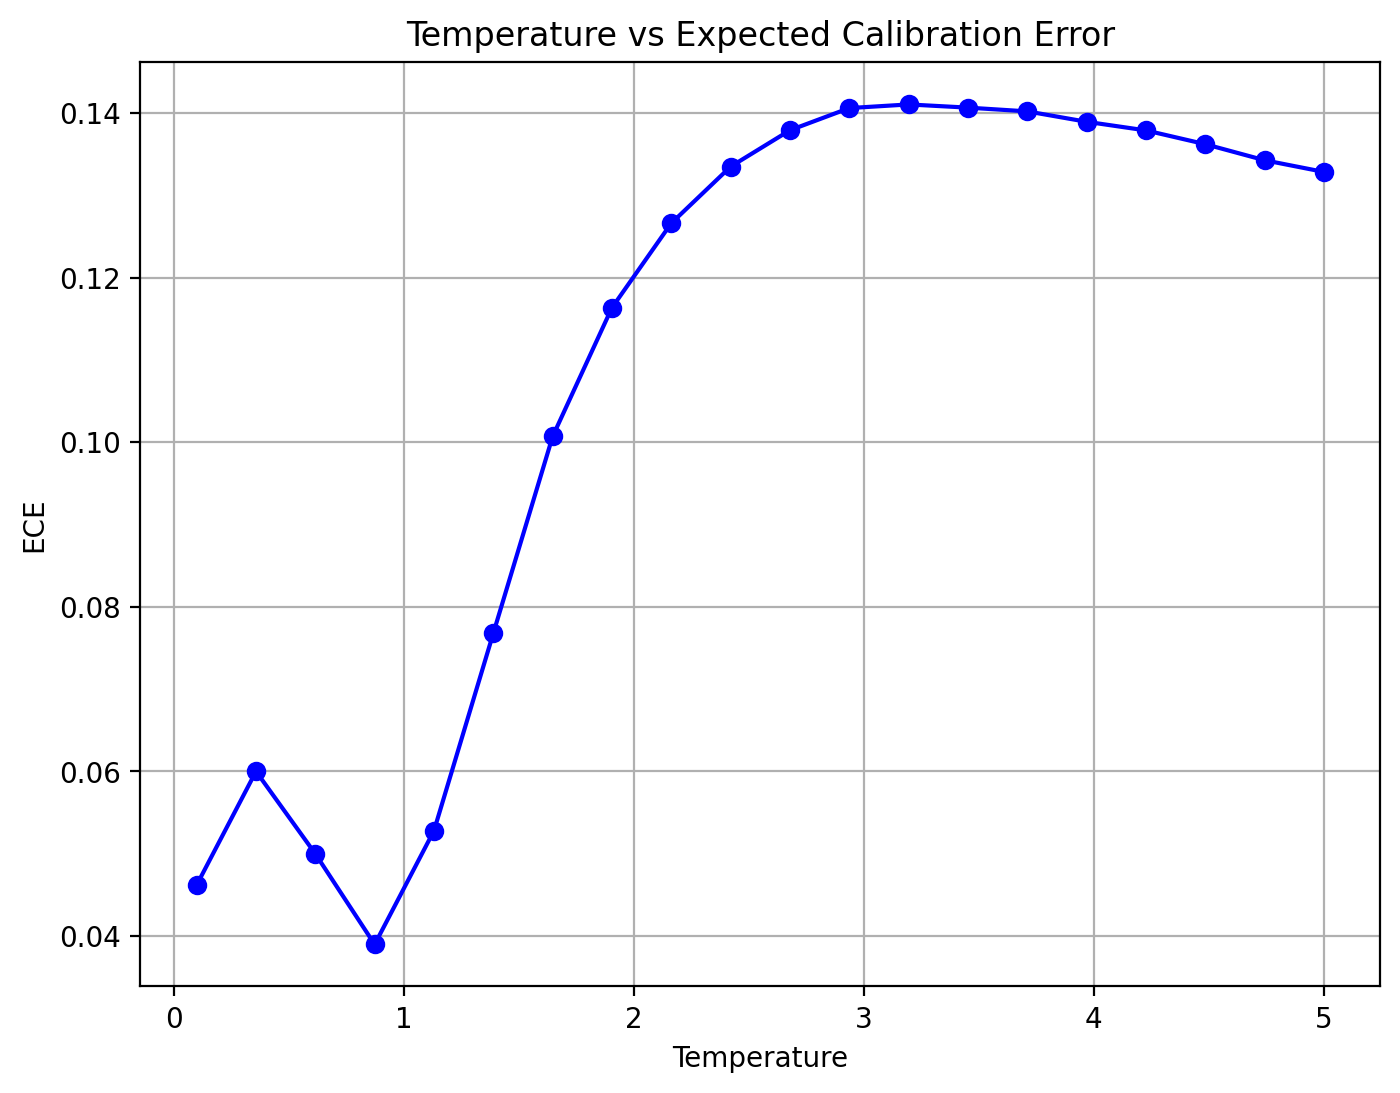

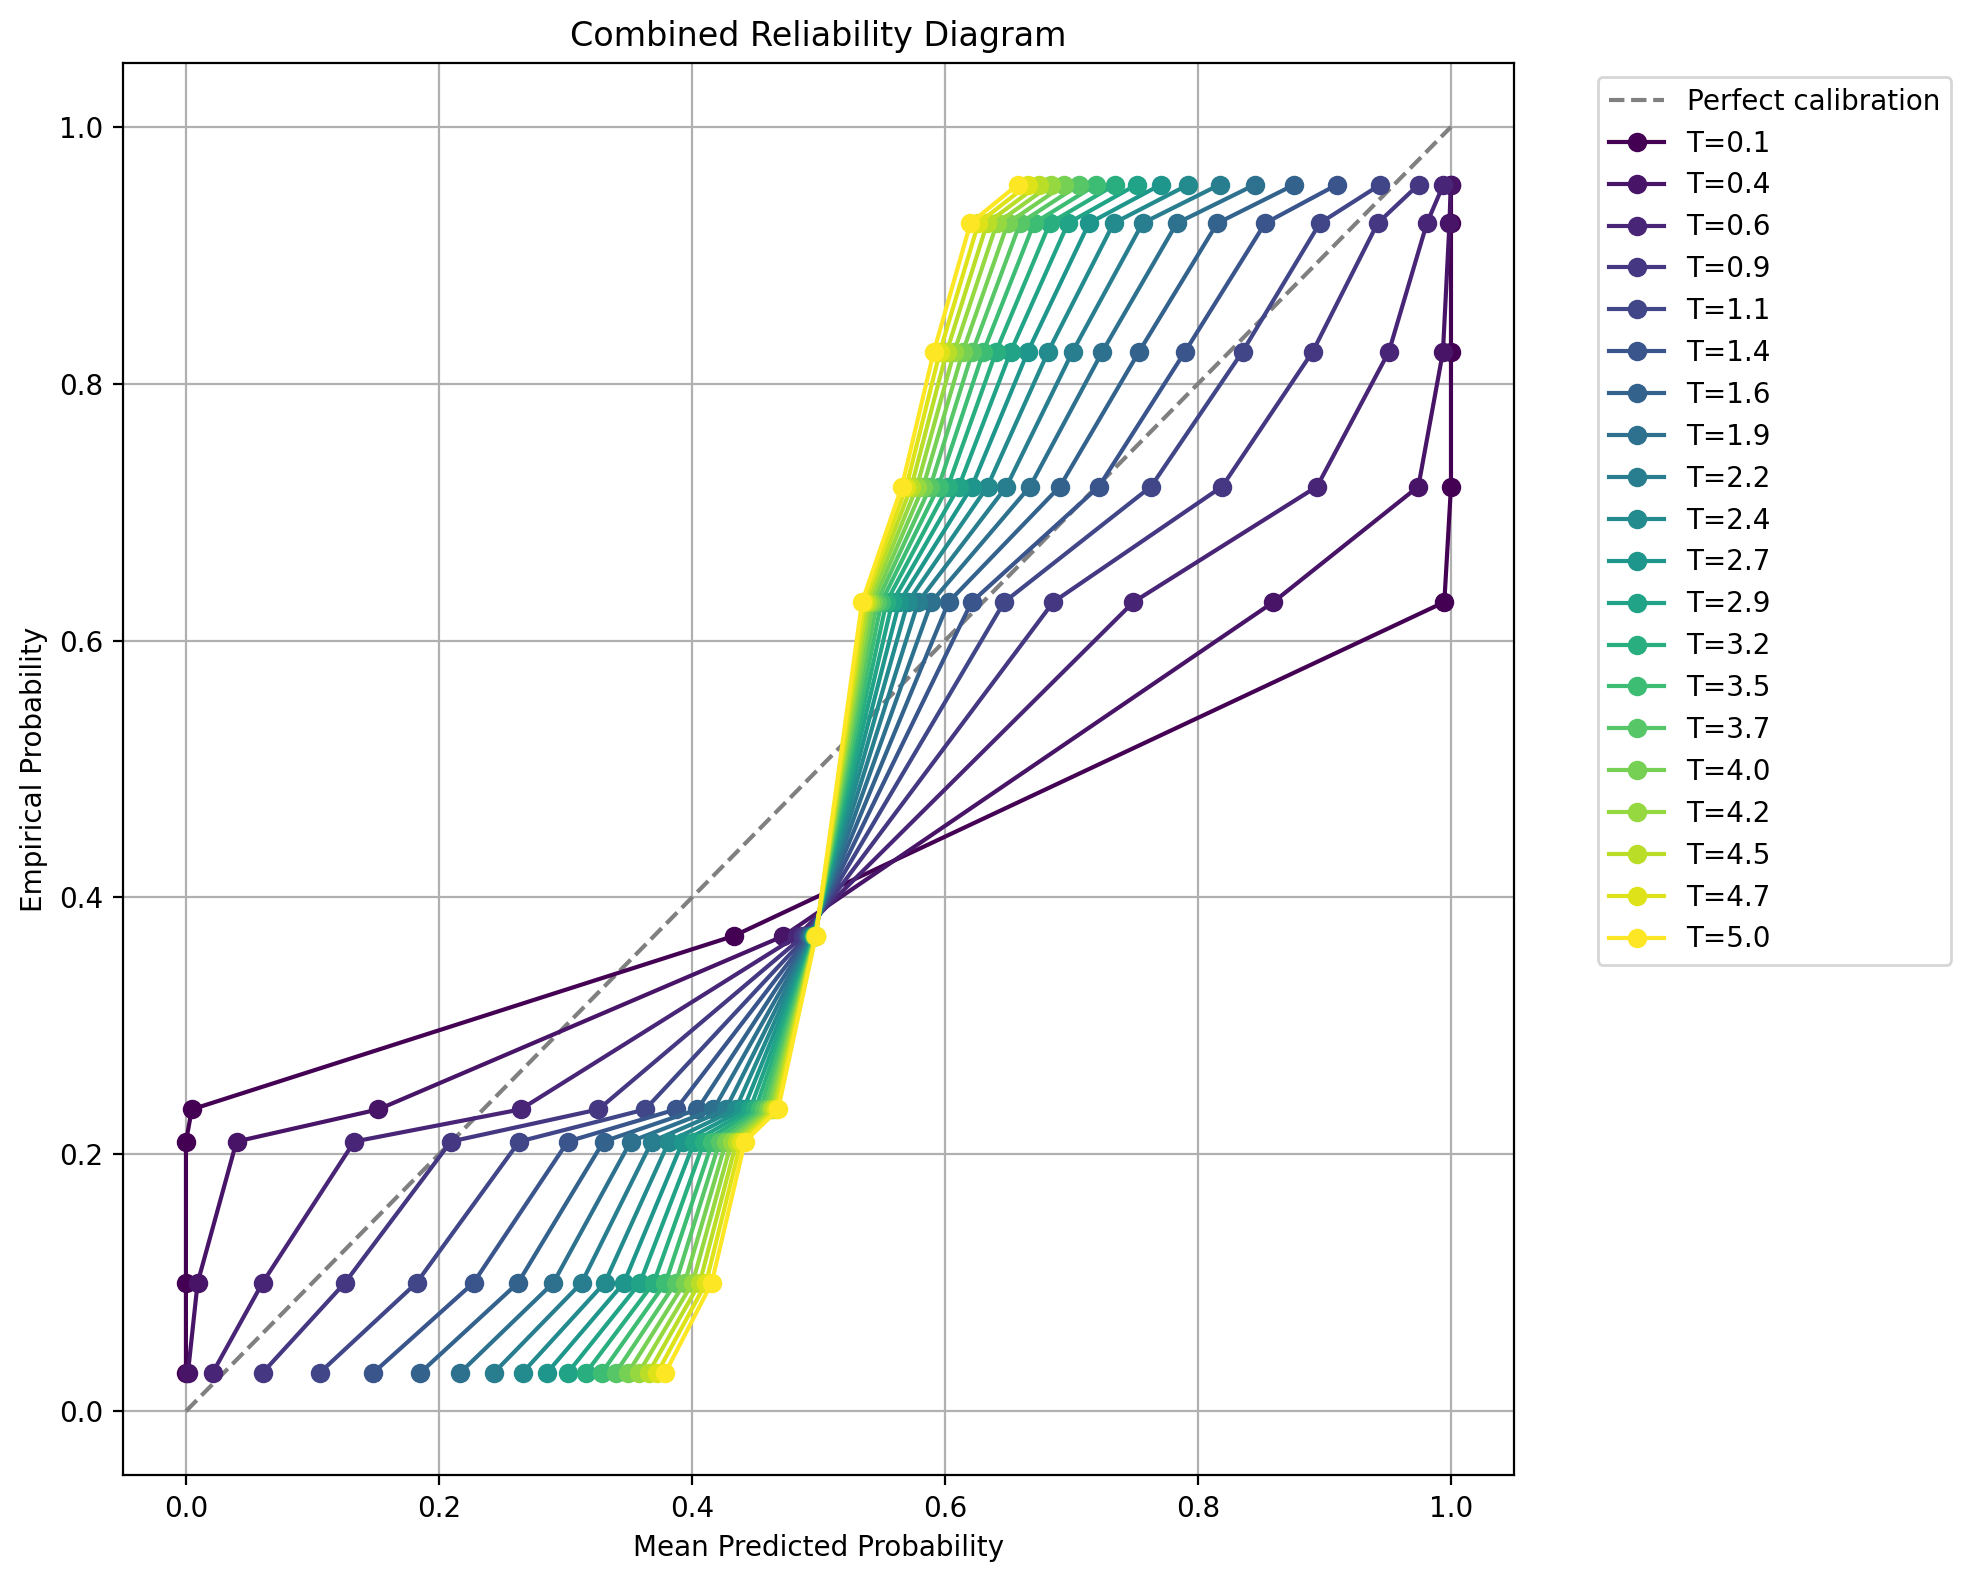

In [45]:
# Study temperature scaling effect
results = study_temperature_effect('LENET', model, testloader)

## Fine tuning bigger model

In this part the goal is to fine tune a very large model that we import (DenseNet). We are going to replace the classification layer to adapt to our problem and compare the results to our previous simpler model. We should expect to see worse results ion terms of calibration in the bigger model. 

Modern models, especially deep neural networks, are typically optimized to minimize prediction error or maximize accuracy. They prioritize making correct predictions over providing well-calibrated probabilities. As a result:

- The model may confidently predict wrong outcomes, leading to poor calibration.
- Overfitting to the training data may lead to overly confident predictions, even when those predictions are incorrect.

In [27]:
#download bigger model
from torchvision import datasets, transforms, models

dense_net = models.densenet121(pretrained=True)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
# Train Set
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Test Set
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

trainset.transform = train_transforms
valset.transform = test_transforms
bird_cat_testset.transform = test_transforms

# Create data loaders for train, validation, and test sets with data augmentation transformations
train_loader2 = torch.utils.data.DataLoader(
    trainset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4,  # Added parallel data loading
    pin_memory=True  # Added for faster data transfer to GPU
)

val_loader2 = torch.utils.data.DataLoader(
    valset, 
    batch_size=64, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader2 = torch.utils.data.DataLoader(
    bird_cat_testset, 
    batch_size=64, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

## Replacing the classifier

In [29]:
class MLP(nn.Module):
    def __init__(self, dimx=1024, hidden=500, nlabels=2):  # Kept original parameter names
        super().__init__()
        
        self.output1 = nn.Linear(dimx, hidden)
        self.output2 = nn.Linear(hidden, nlabels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Added dropout for regularization
        self.logsoftmax = nn.LogSoftmax(dim=1)  # Kept original logsoftmax
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Added dropout after activation
        x = self.output2(x)
        x = self.logsoftmax(x)
        return x

In [30]:
# Set model to eval mode
dense_net.eval()

# Freeze all parameters in the DenseNet feature extractor
for param in dense_net.parameters():
    param.requires_grad = False

# Create new classifier with matching input dimensions
# DenseNet-121's final feature dimension is 1024
classifier = MLP(dimx=1024, hidden=500, nlabels=2)
dense_net.classifier = classifier

# Verify that only classifier parameters are trainable
print("\nVerifying trainable layers:")
for name, param in dense_net.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
    else:
        print(f"Frozen: {name}")


Verifying trainable layers:
Frozen: features.conv0.weight
Frozen: features.norm0.weight
Frozen: features.norm0.bias
Frozen: features.denseblock1.denselayer1.norm1.weight
Frozen: features.denseblock1.denselayer1.norm1.bias
Frozen: features.denseblock1.denselayer1.conv1.weight
Frozen: features.denseblock1.denselayer1.norm2.weight
Frozen: features.denseblock1.denselayer1.norm2.bias
Frozen: features.denseblock1.denselayer1.conv2.weight
Frozen: features.denseblock1.denselayer2.norm1.weight
Frozen: features.denseblock1.denselayer2.norm1.bias
Frozen: features.denseblock1.denselayer2.conv1.weight
Frozen: features.denseblock1.denselayer2.norm2.weight
Frozen: features.denseblock1.denselayer2.norm2.bias
Frozen: features.denseblock1.denselayer2.conv2.weight
Frozen: features.denseblock1.denselayer3.norm1.weight
Frozen: features.denseblock1.denselayer3.norm1.bias
Frozen: features.denseblock1.denselayer3.conv1.weight
Frozen: features.denseblock1.denselayer3.norm2.weight
Frozen: features.denseblock1.

In [31]:
class Tran_Eval():
    def __init__(self, model, maxiter=500, lr=0.001):
        self.model = model
        self.lr = lr
        # Added weight decay for regularization
        self.optim = torch.optim.Adam(self.model.classifier.parameters(), 
                                    lr=self.lr, 
                                    weight_decay=1e-4)
        self.max_iter = maxiter
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        # Add best loss tracking for early stopping
        self.best_val_loss = float('inf')
        self.patience = 5
        self.patience_counter = 0

    def trainloop(self, trainloader, validloader):
        it_images = iter(trainloader)
        try:
            for e in range(int(self.max_iter)):
                # Training phase
                self.model.train()
                try:
                    images, labels = next(it_images)
                except StopIteration:
                    # Reset iterator if we run out of batches
                    it_images = iter(trainloader)
                    images, labels = next(it_images)
                
                images, labels = images.to(self.device), labels.to(self.device)
                
                # Forward pass and loss calculation
                self.optim.zero_grad()
                out = self.model(images)
                loss = self.criterion(out, labels)
                running_loss = loss.item()
                
                # Backward pass
                loss.backward()
                self.optim.step()
                
                self.loss_during_training.append(running_loss)
                
                # Validation phase
                self.model.eval()
                val_loss = 0.0
                correct = 0
                total = 0
                
                with torch.no_grad():
                    for images, labels in validloader:
                        images, labels = images.to(self.device), labels.to(self.device)
                        out = self.model(images)
                        loss = self.criterion(out, labels)
                        val_loss += loss.item()
                        
                        # Calculate accuracy during validation
                        _, predicted = out.max(1)
                        total += labels.size(0)
                        correct += predicted.eq(labels).sum().item()
                
                avg_val_loss = val_loss / len(validloader)
                accuracy = 100. * correct / total
                
                self.valid_loss_during_training.append(avg_val_loss)
                
                print(f'Batch {e} of {self.max_iter}')
                print(f'Training Loss: {running_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
                print(f'Validation Accuracy: {accuracy:.2f}%')
                
                # Early stopping check
                if avg_val_loss < self.best_val_loss:
                    self.best_val_loss = avg_val_loss
                    self.patience_counter = 0
                else:
                    self.patience_counter += 1
                    if self.patience_counter >= self.patience:
                        print(f'Early stopping triggered after batch {e}')
                        break
                        
        except KeyboardInterrupt:
            print('Training interrupted by user')
            
    def eval_performance(self, dataloader, num_batches):
        total_accuracy = 0
        total_samples = 0
        it_images = iter(dataloader)
        
        with torch.no_grad():
            self.model.eval()
            for e in range(int(num_batches)):
                try:
                    images, labels = next(it_images)
                except StopIteration:
                    break
                    
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.model(images)
                _, predicted = probs.max(1)
                
                # Calculate accuracy
                correct = predicted.eq(labels).sum().item()
                total_accuracy += correct
                total_samples += labels.size(0)
                
                if (e + 1) % 5 == 0:  # Print every 5 batches
                    print(f'Batch {e+1} of {num_batches}')
                    print(f'Running Accuracy: {100 * total_accuracy / total_samples:.2f}%')
        
        final_accuracy = 100 * total_accuracy / total_samples
        print(f'\nFinal Test Accuracy: {final_accuracy:.2f}%')
        return final_accuracy

In [32]:
trainer = Tran_Eval(dense_net, maxiter=15, lr=0.001)
trainer.trainloop(train_loader2, val_loader2)
accuracy = trainer.eval_performance(test_loader2, num_batches=10)

Batch 0 of 15
Training Loss: 0.7608, Validation Loss: 0.8577
Validation Accuracy: 49.80%
Batch 1 of 15
Training Loss: 0.7807, Validation Loss: 0.6560
Validation Accuracy: 62.05%
Batch 2 of 15
Training Loss: 0.7088, Validation Loss: 0.6383
Validation Accuracy: 57.00%
Batch 3 of 15
Training Loss: 0.8243, Validation Loss: 0.6114
Validation Accuracy: 64.05%
Batch 4 of 15
Training Loss: 0.6353, Validation Loss: 0.5927
Validation Accuracy: 72.60%
Batch 5 of 15
Training Loss: 0.6490, Validation Loss: 0.5866
Validation Accuracy: 75.40%
Batch 6 of 15
Training Loss: 0.5952, Validation Loss: 0.5933
Validation Accuracy: 72.20%
Batch 7 of 15
Training Loss: 0.6548, Validation Loss: 0.5905
Validation Accuracy: 71.00%
Batch 8 of 15
Training Loss: 0.6674, Validation Loss: 0.5733
Validation Accuracy: 76.15%
Batch 9 of 15
Training Loss: 0.5664, Validation Loss: 0.5574
Validation Accuracy: 78.10%
Batch 10 of 15
Training Loss: 0.5740, Validation Loss: 0.5571
Validation Accuracy: 74.50%
Batch 11 of 15
Train

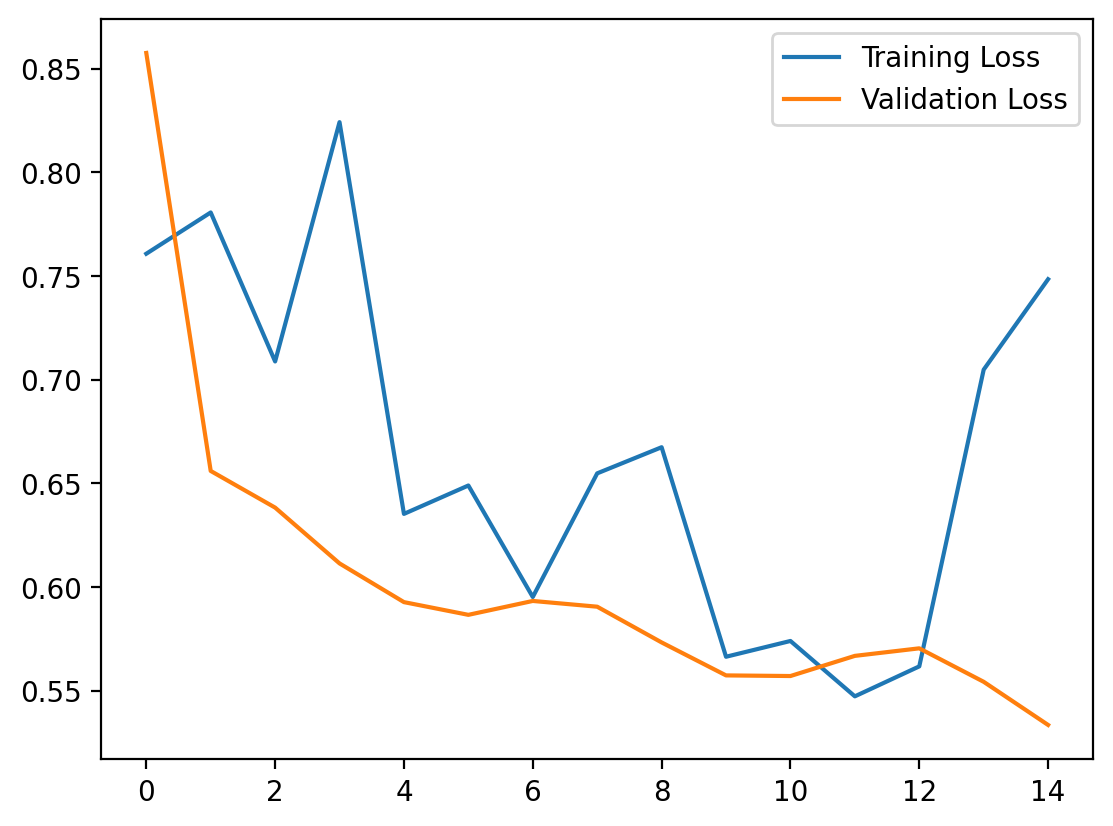

In [33]:
plt.plot(trainer.loss_during_training,label='Training Loss')
plt.plot(trainer.valid_loss_during_training,label='Validation Loss')
plt.savefig('TVL_BIGMODEL_REGULAR.png')
plt.legend()

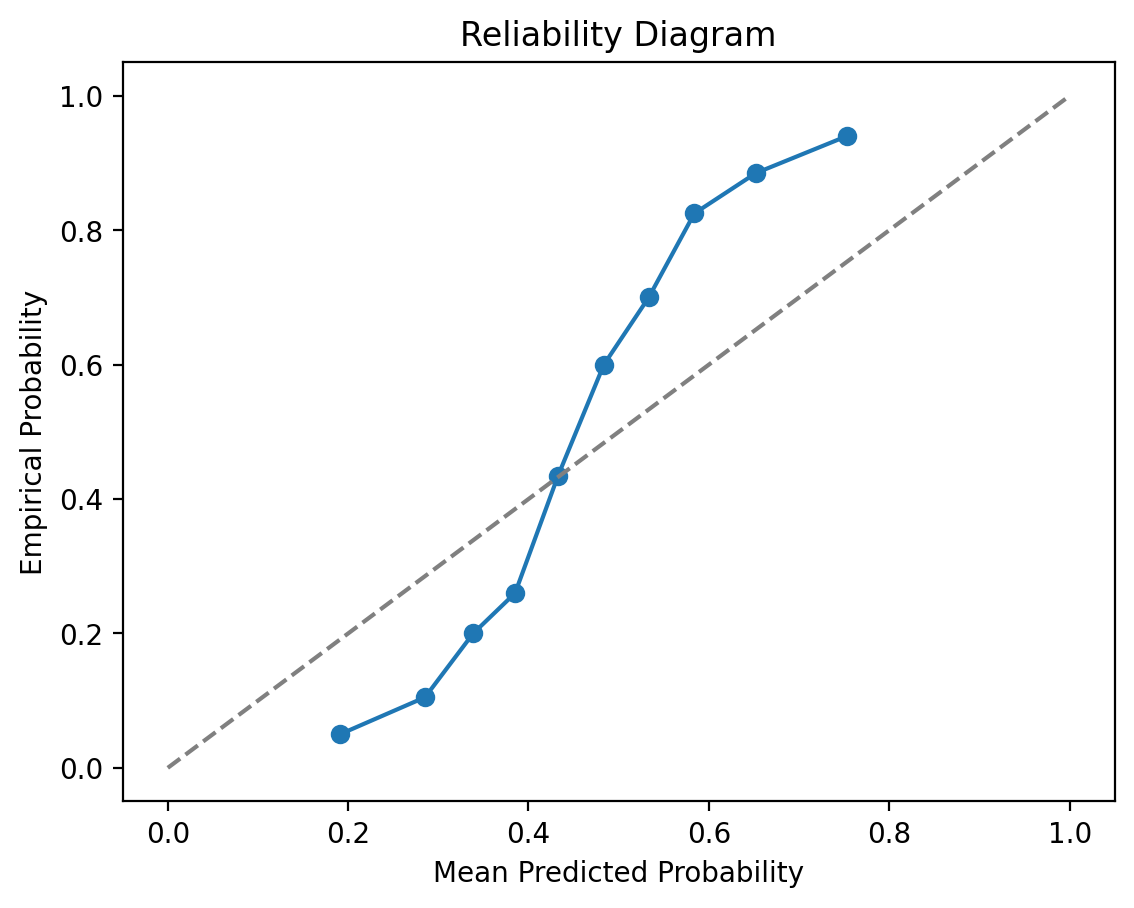

Expected Calibration Error (ECE): 0.1187


In [34]:
y_true_dense, y_prob_dense = get_y_true_y_prob(trainer.model, test_loader2)

# Plot reliability diagram and print ECE
ece_dense = plot_reliability_diagram(y_true_dense, y_prob_dense, n_bins=10)

In [35]:
dense_wth_temp = Temperature(trainer.model)

dense_wth_temp.calibrate(val_loader2)

Before calibration - Temperature: 1.500, NLL: 0.573
Iteration 10, NLL: 0.567, Temperature: 1.400
Iteration 20, NLL: 0.560, Temperature: 1.298
Iteration 30, NLL: 0.552, Temperature: 1.193
Iteration 40, NLL: 0.543, Temperature: 1.084
Iteration 50, NLL: 0.532, Temperature: 0.971
Iteration 60, NLL: 0.520, Temperature: 0.853
Iteration 70, NLL: 0.506, Temperature: 0.730
Iteration 80, NLL: 0.491, Temperature: 0.605
Iteration 90, NLL: 0.478, Temperature: 0.485
Iteration 100, NLL: 0.473, Temperature: 0.395
Early stopping at iteration 102

Calibration completed:
Initial Temperature: 1.500 → Final Temperature: 0.381
NLL: 0.573 → 0.474


Temperature(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

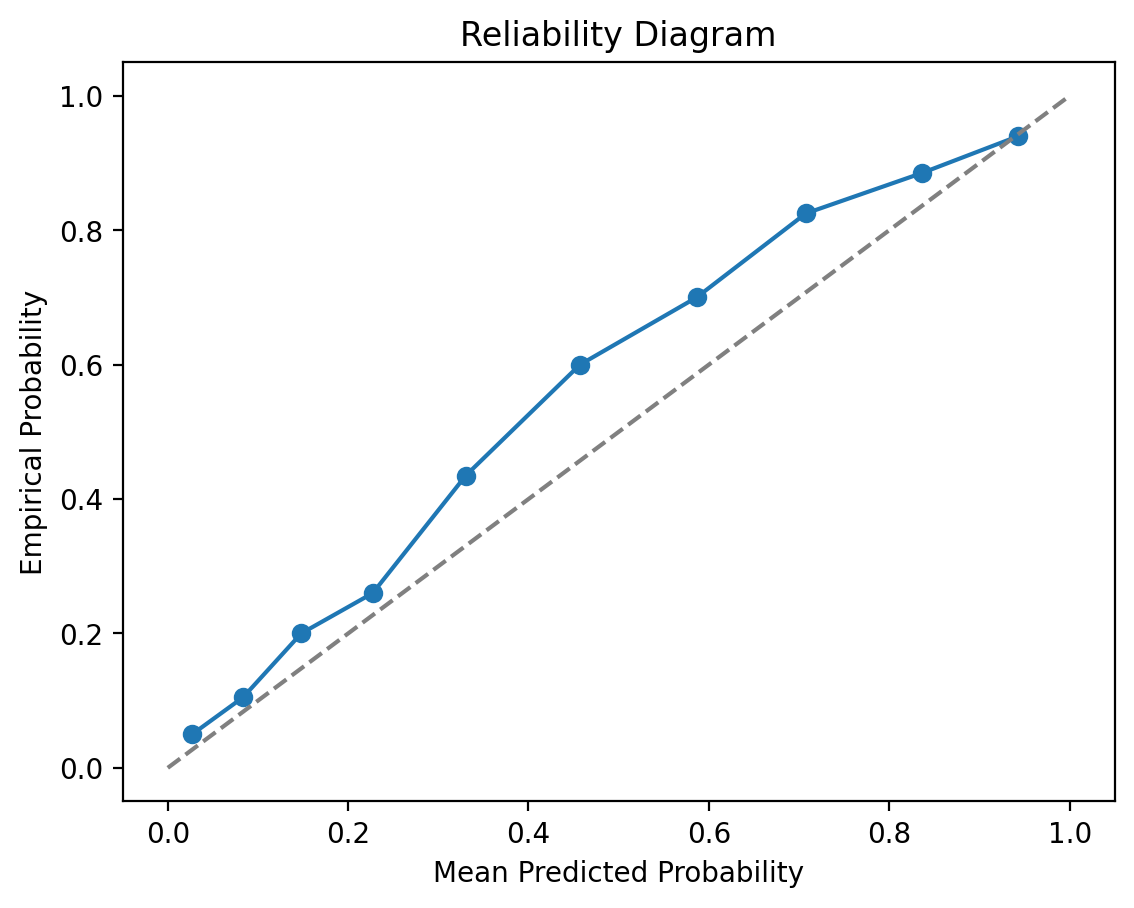

Expected Calibration Error (ECE): 0.0571


In [36]:
y_true_temp_dense, y_prob_temp_dense = get_y_true_y_prob(dense_wth_temp, test_loader2)

# Plot reliability diagram and print ECE
ece_dense_temp = plot_reliability_diagram(y_true_temp_dense, y_prob_temp_dense, n_bins=10)

Temperature: 0.100


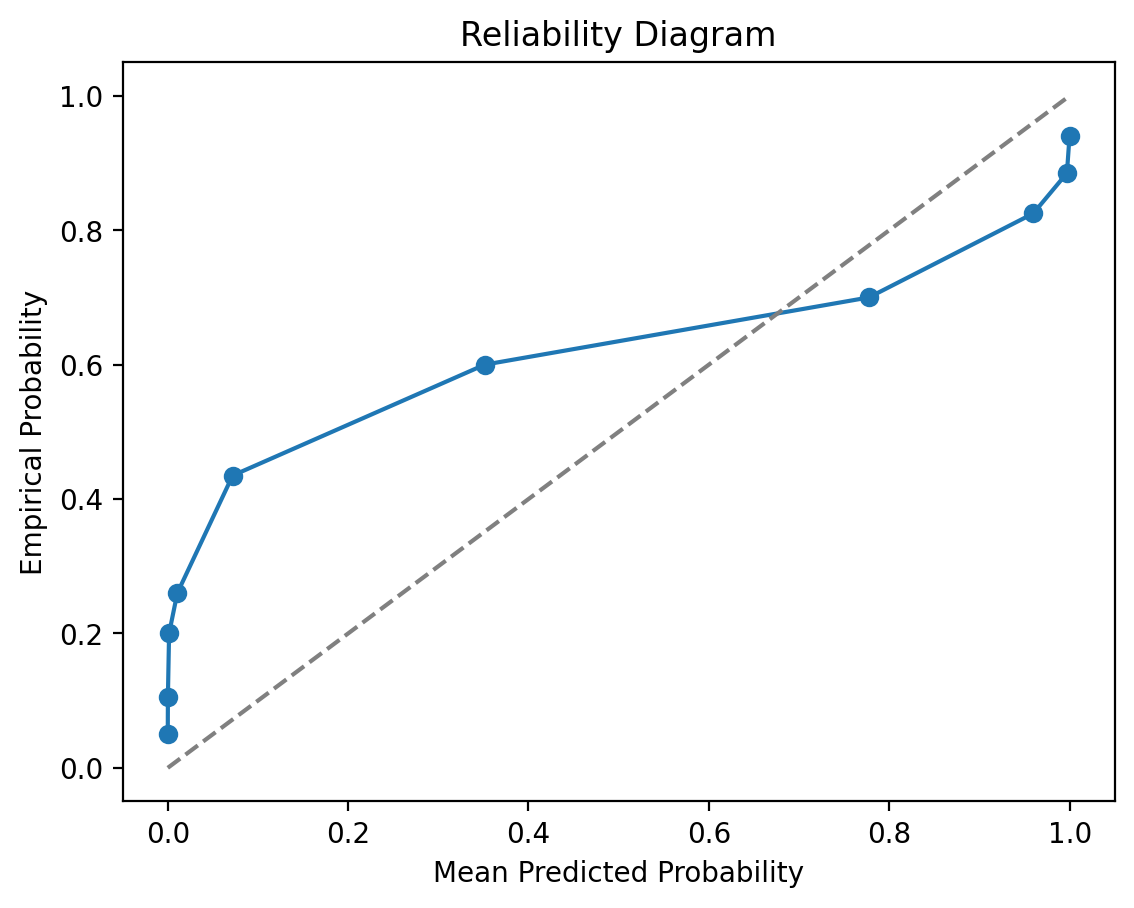

Expected Calibration Error (ECE): 0.0801
Temperature: 0.358


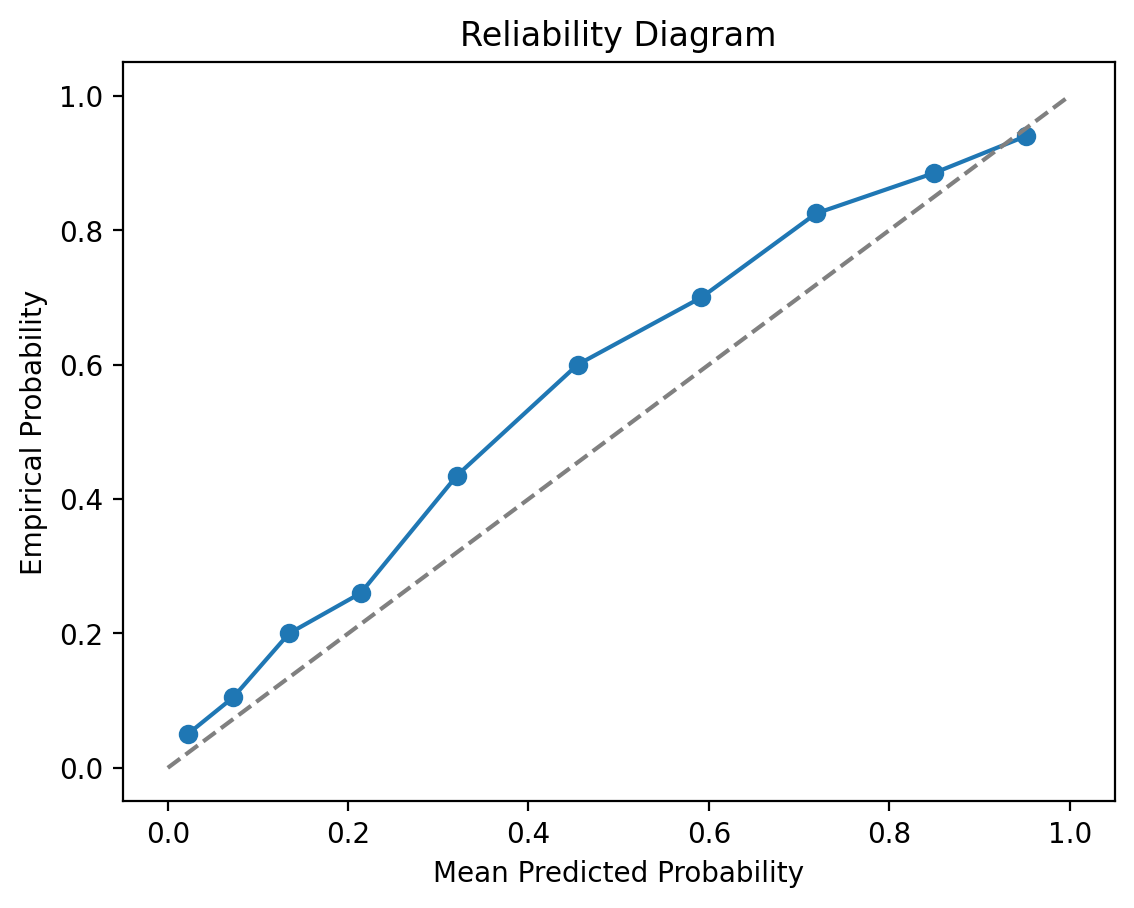

Expected Calibration Error (ECE): 0.0597
Temperature: 0.616


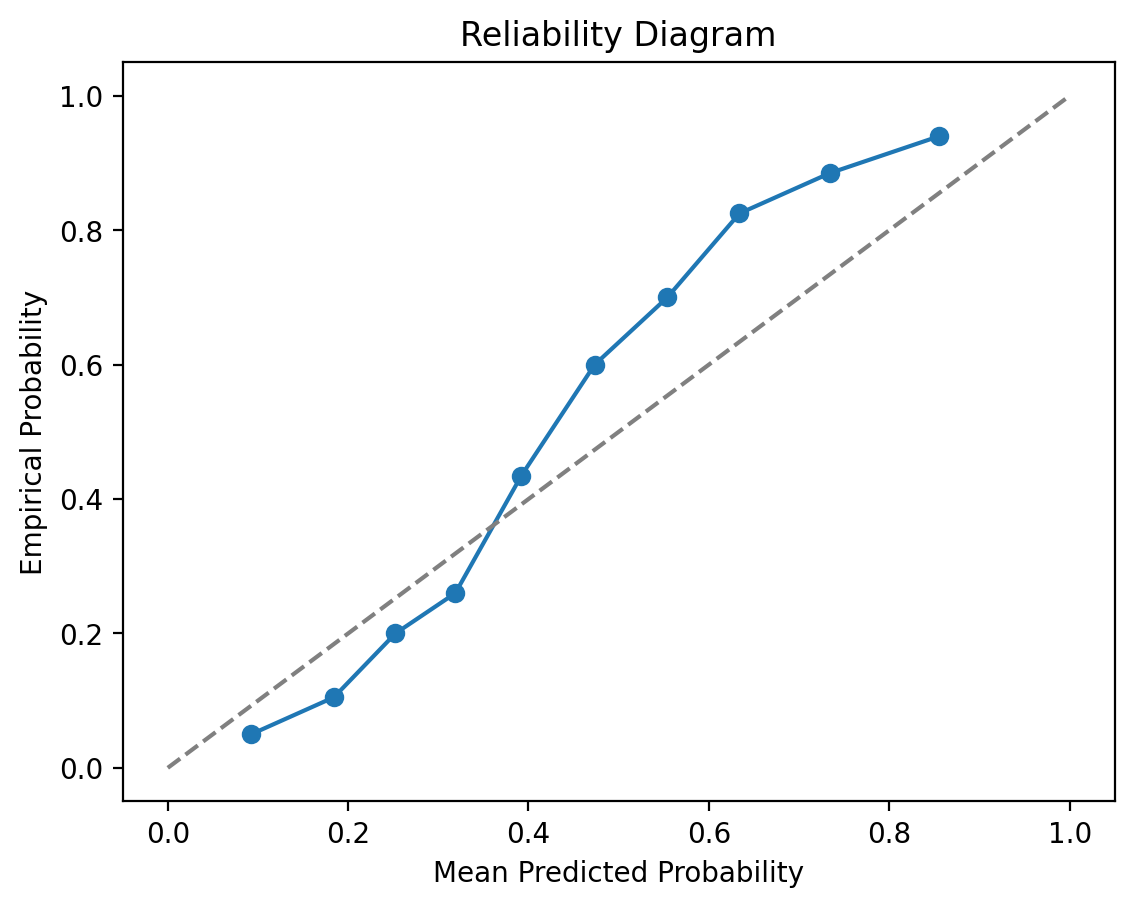

Expected Calibration Error (ECE): 0.0944
Temperature: 0.874


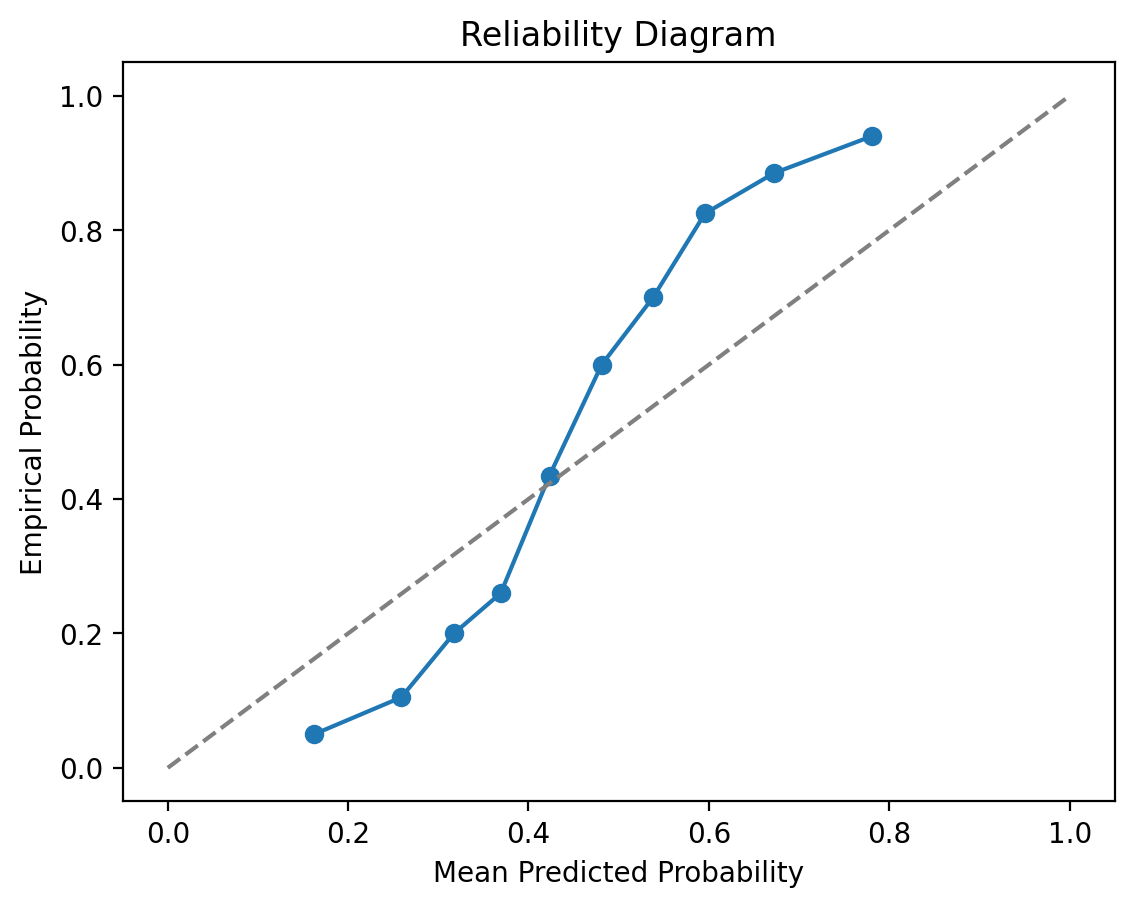

Expected Calibration Error (ECE): 0.1173
Temperature: 1.132


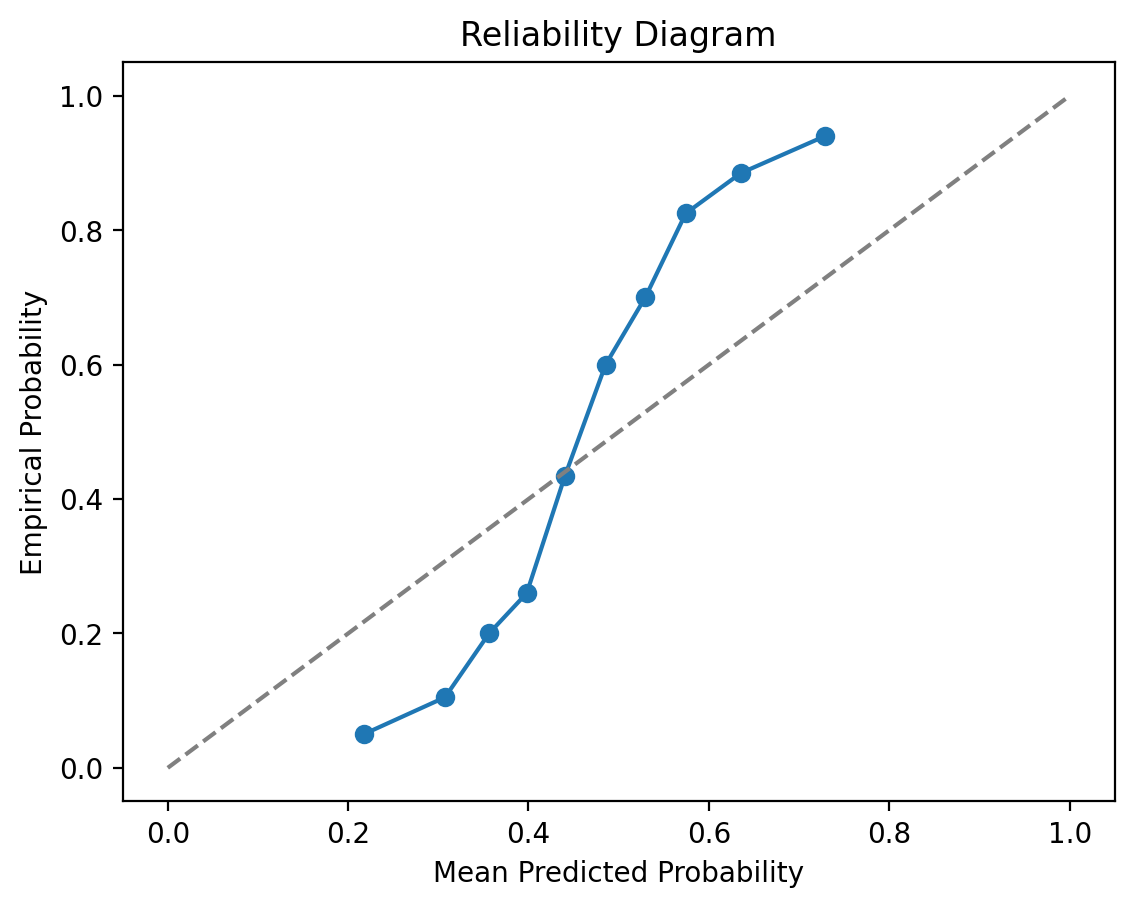

Expected Calibration Error (ECE): 0.1177
Temperature: 1.389


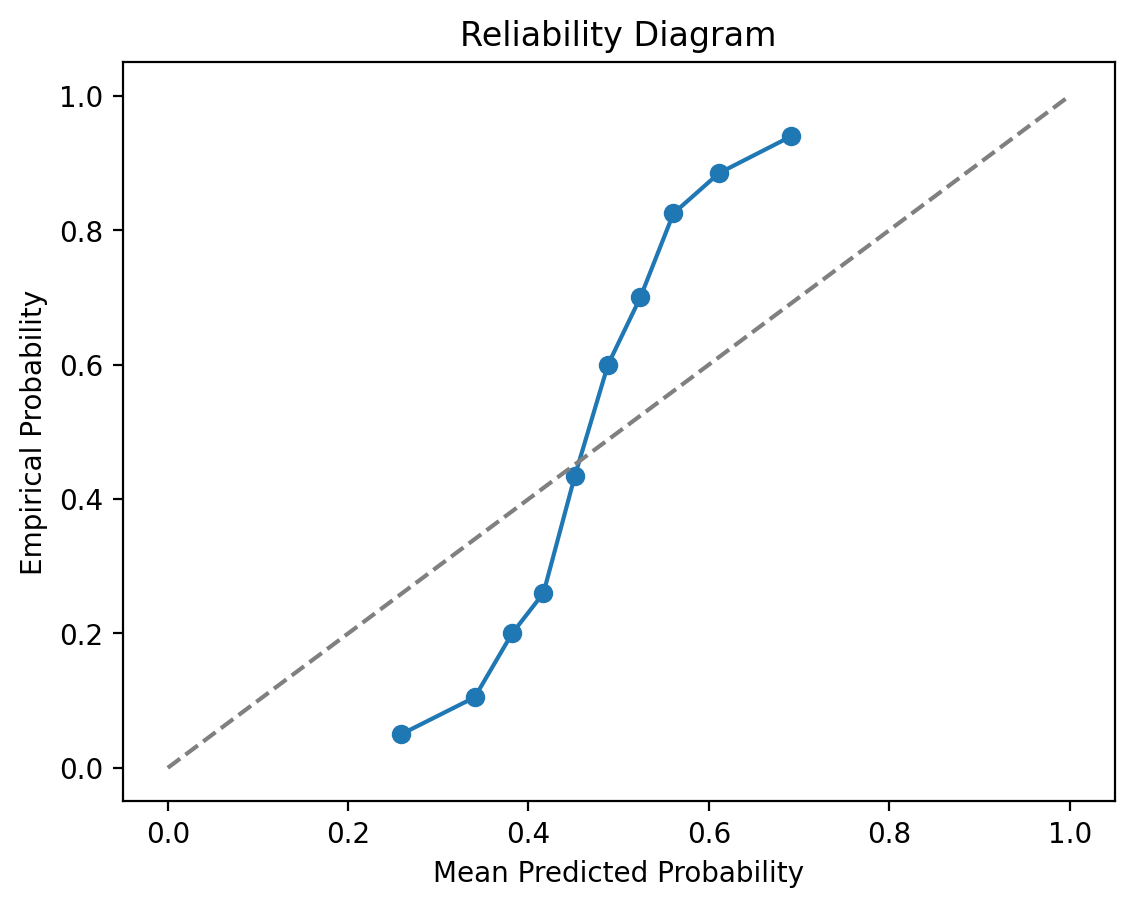

Expected Calibration Error (ECE): 0.1144
Temperature: 1.647


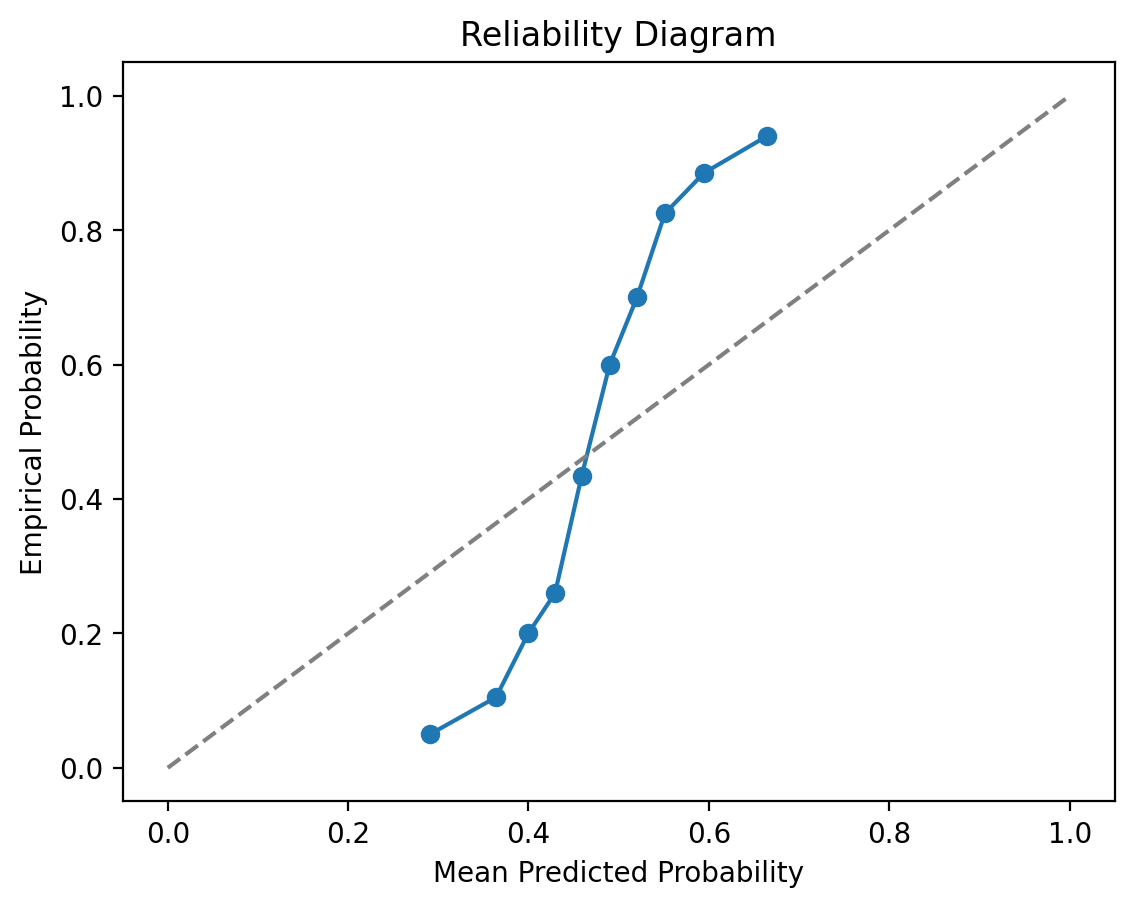

Expected Calibration Error (ECE): 0.1083
Temperature: 1.905


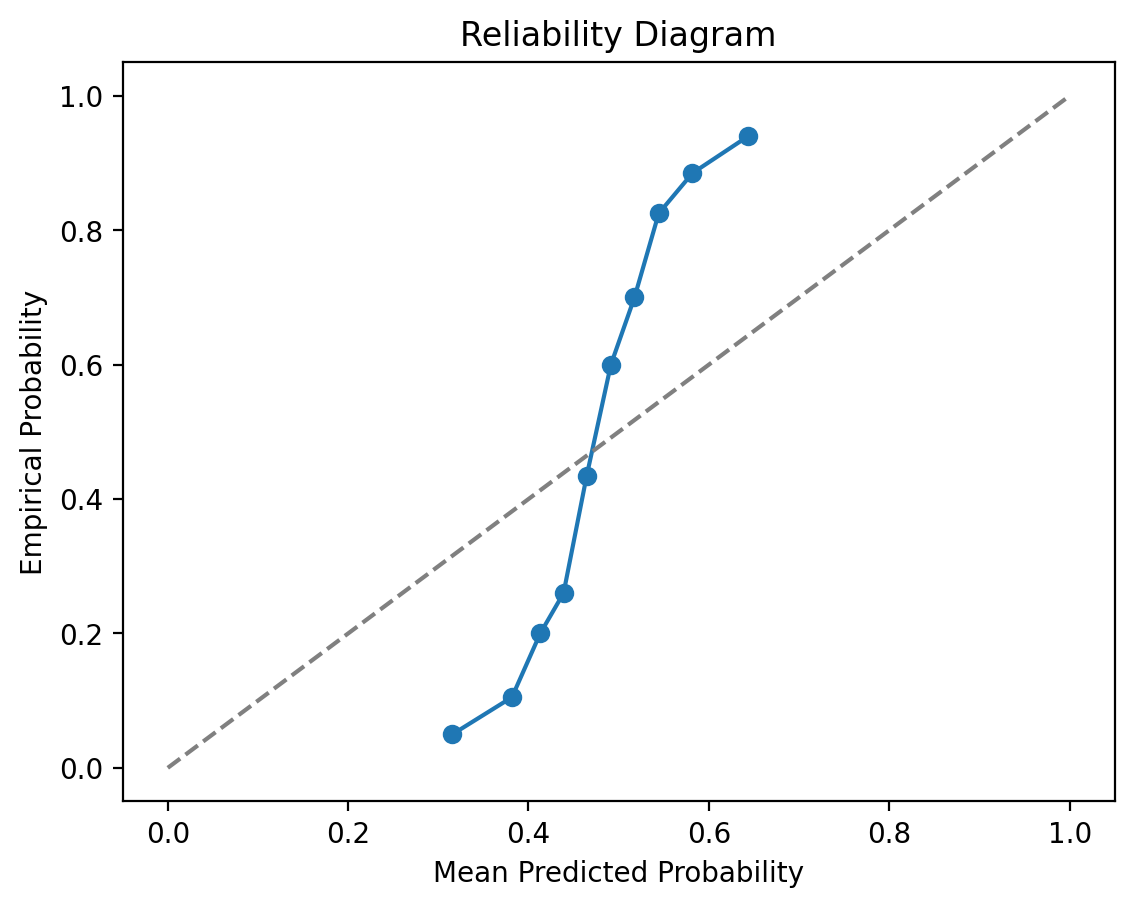

Expected Calibration Error (ECE): 0.1018
Temperature: 2.163


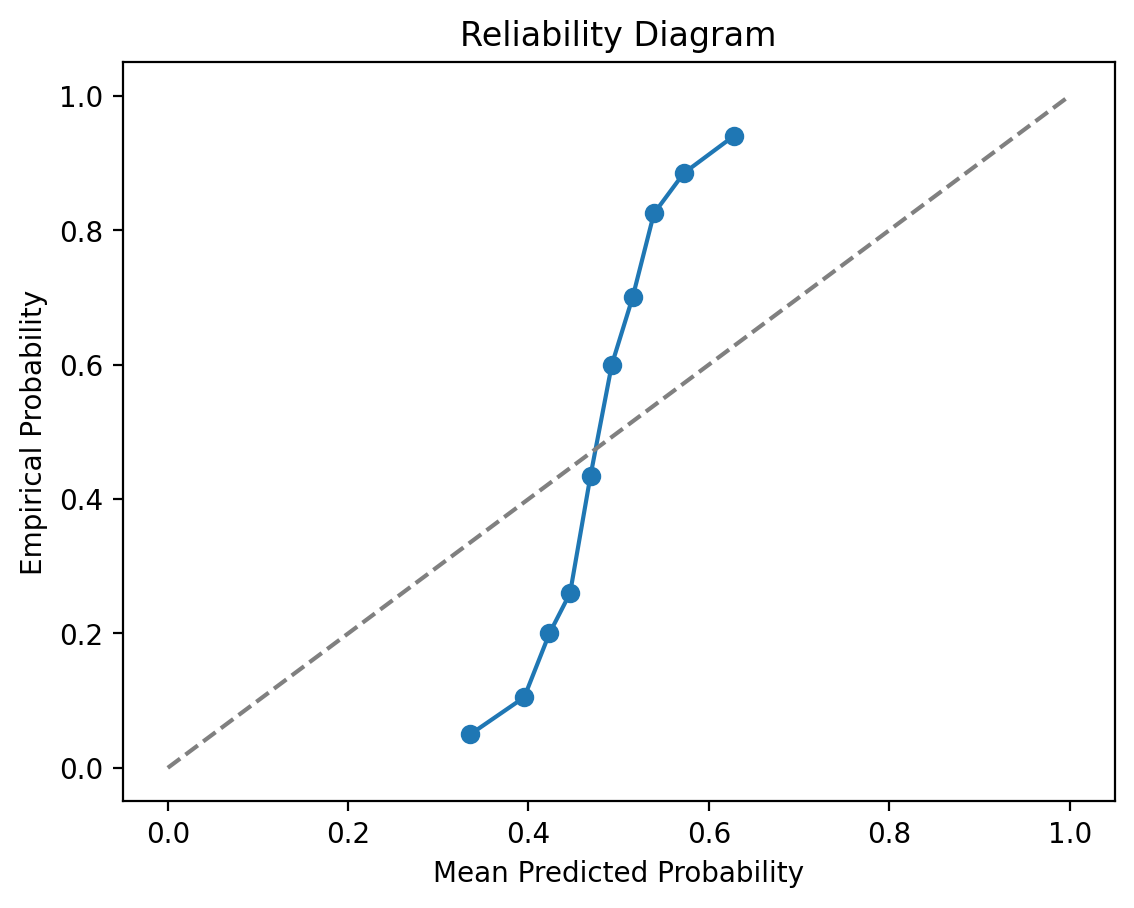

Expected Calibration Error (ECE): 0.0973
Temperature: 2.421


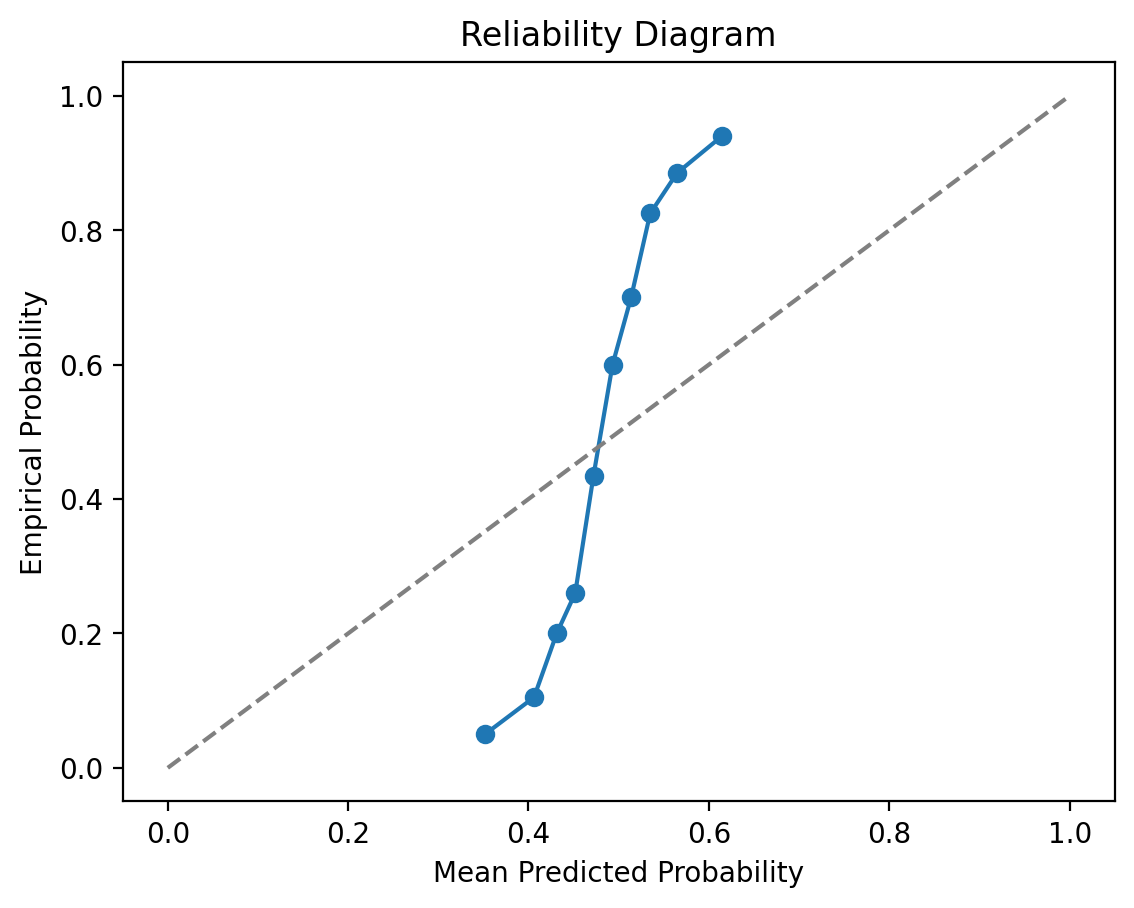

Expected Calibration Error (ECE): 0.0909
Temperature: 2.679


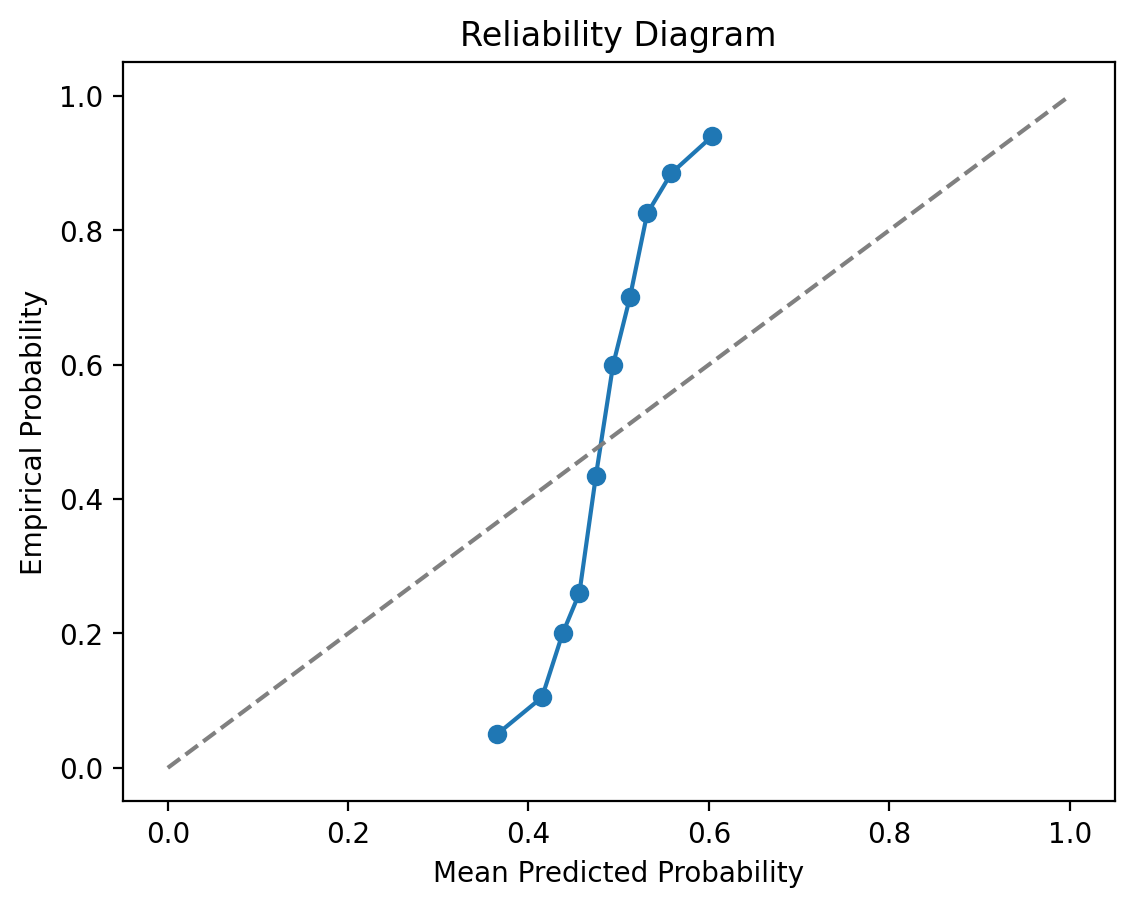

Expected Calibration Error (ECE): 0.0867
Temperature: 2.937


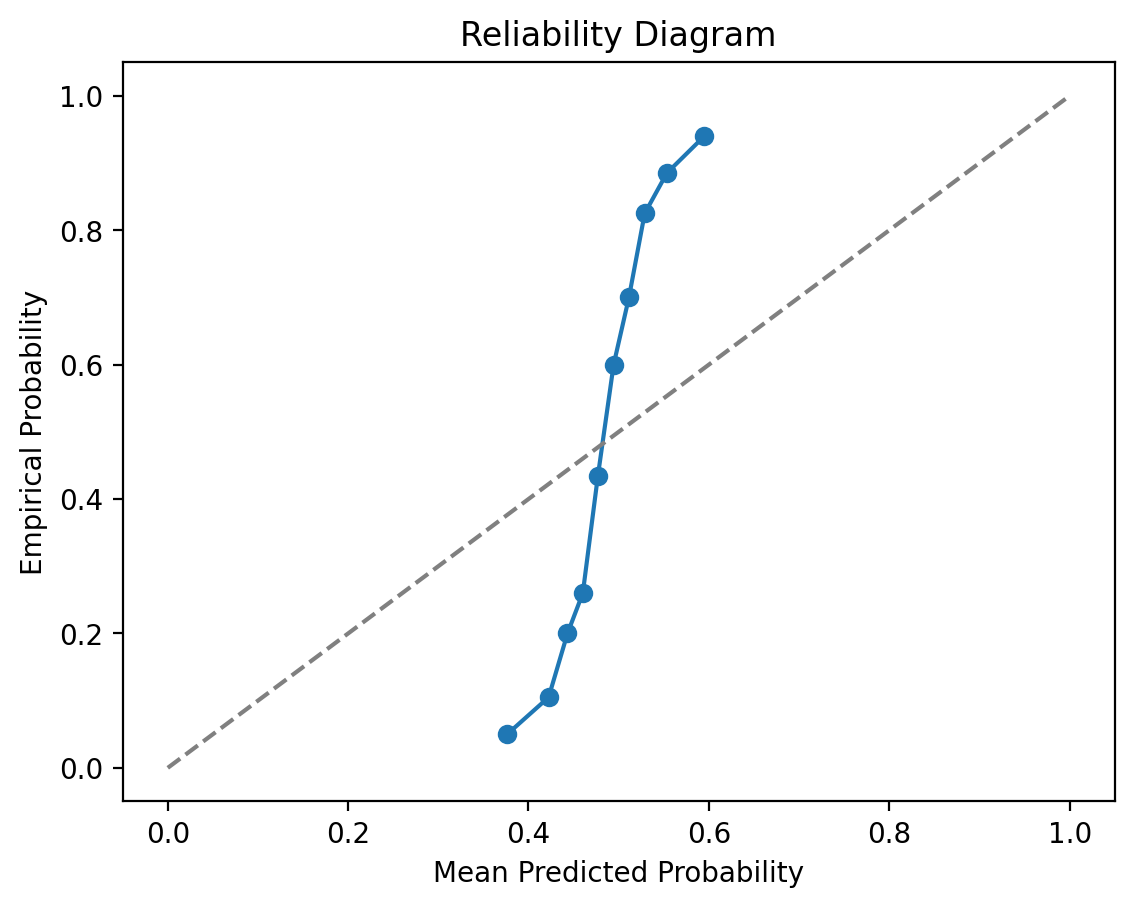

Expected Calibration Error (ECE): 0.0837
Temperature: 3.195


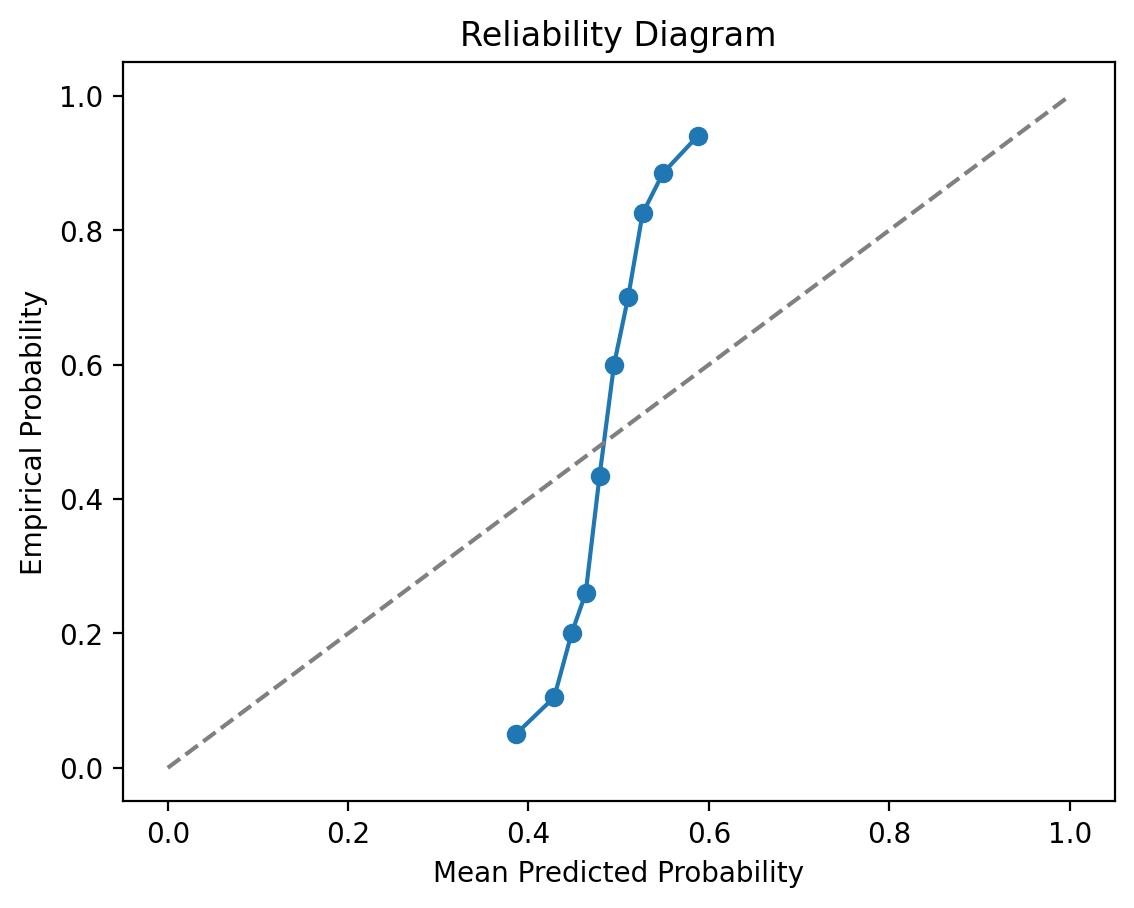

Expected Calibration Error (ECE): 0.0808
Temperature: 3.453


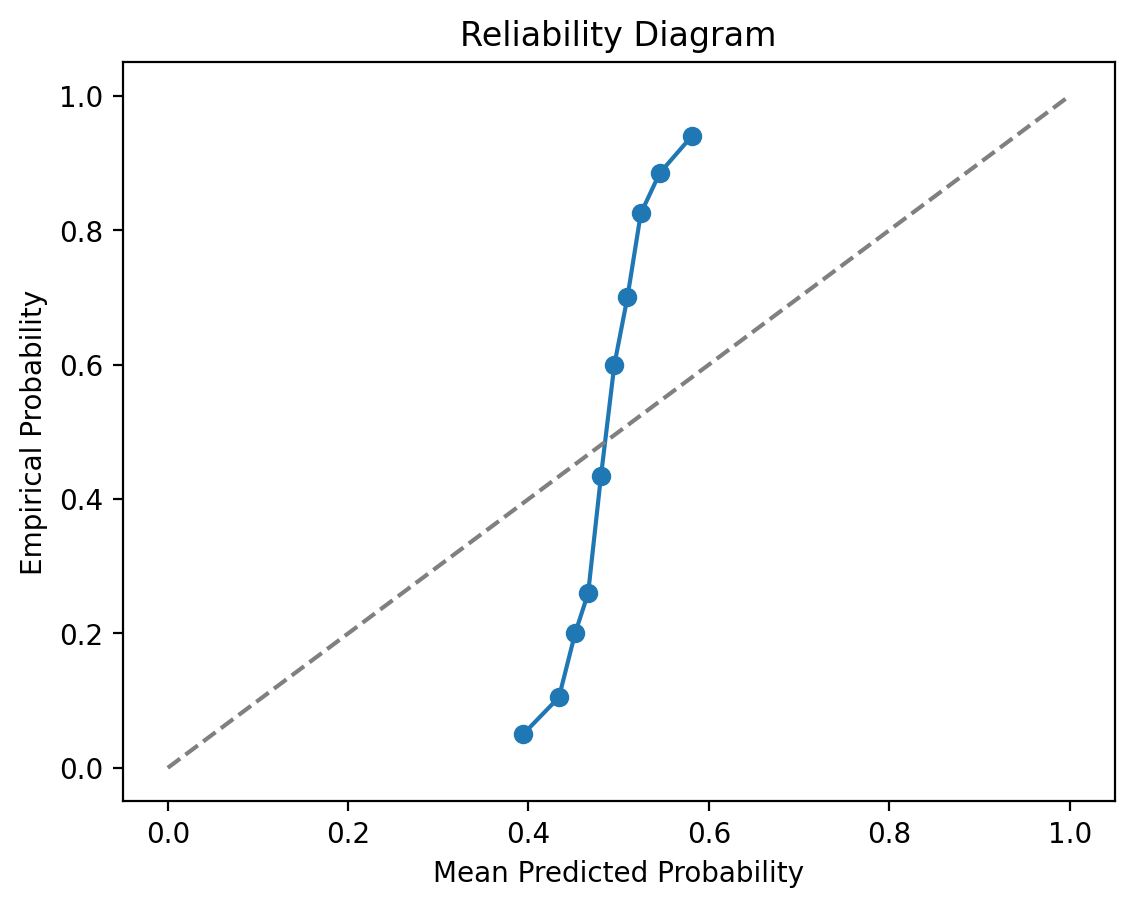

Expected Calibration Error (ECE): 0.0782
Temperature: 3.711


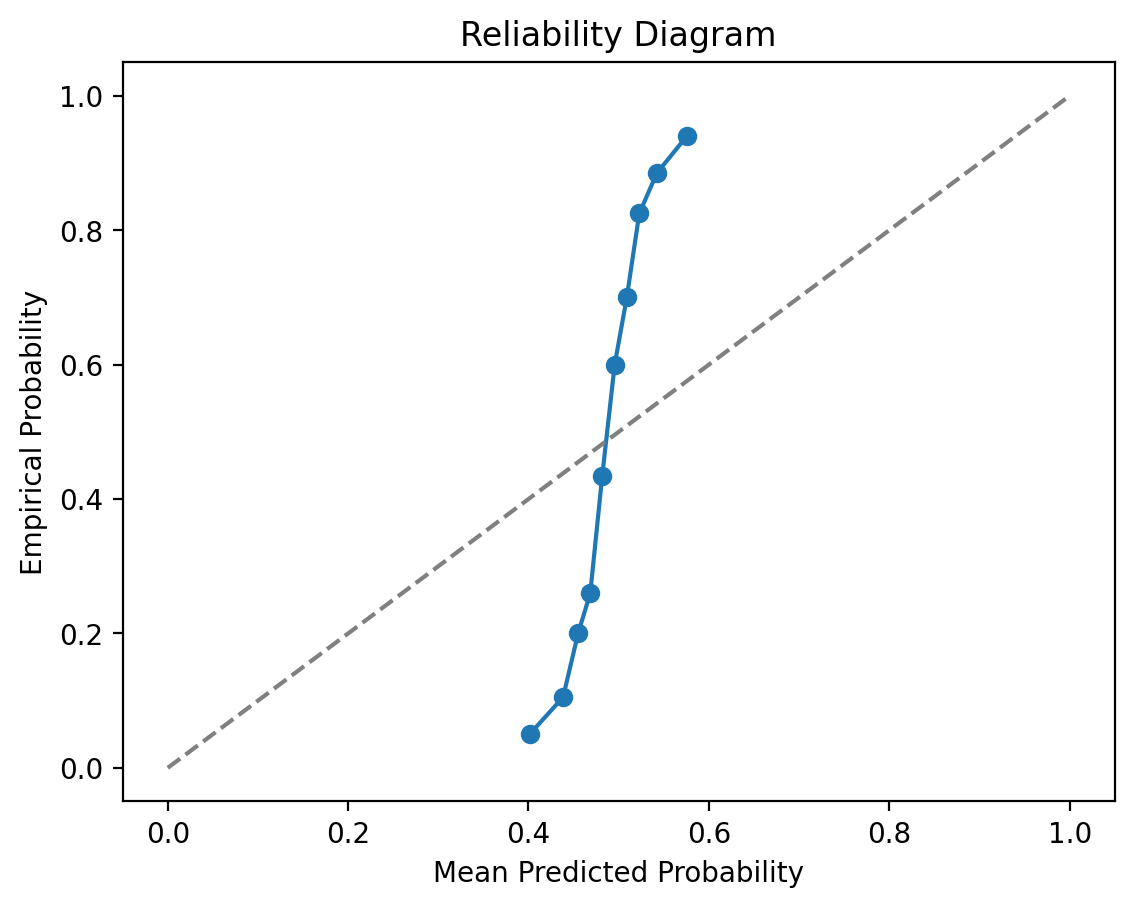

Expected Calibration Error (ECE): 0.0769
Temperature: 3.968


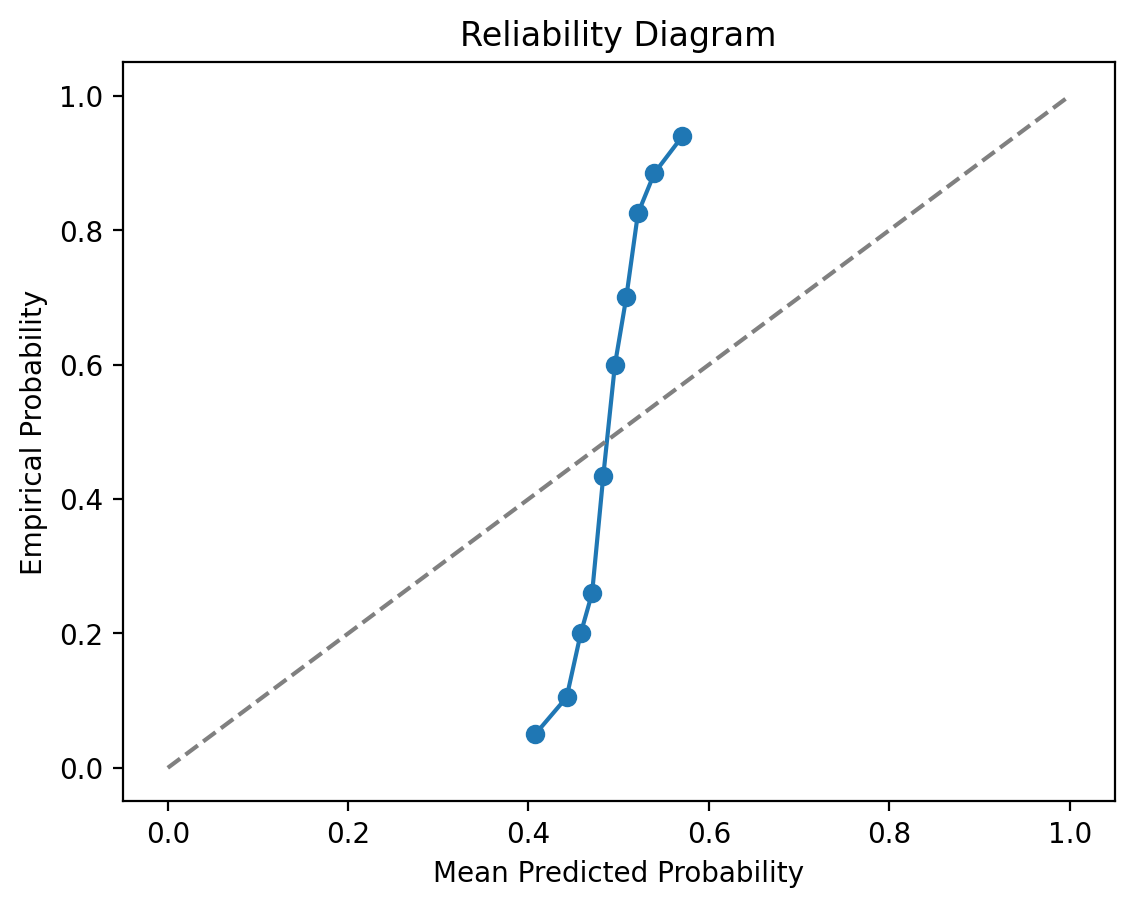

Expected Calibration Error (ECE): 0.0760
Temperature: 4.226


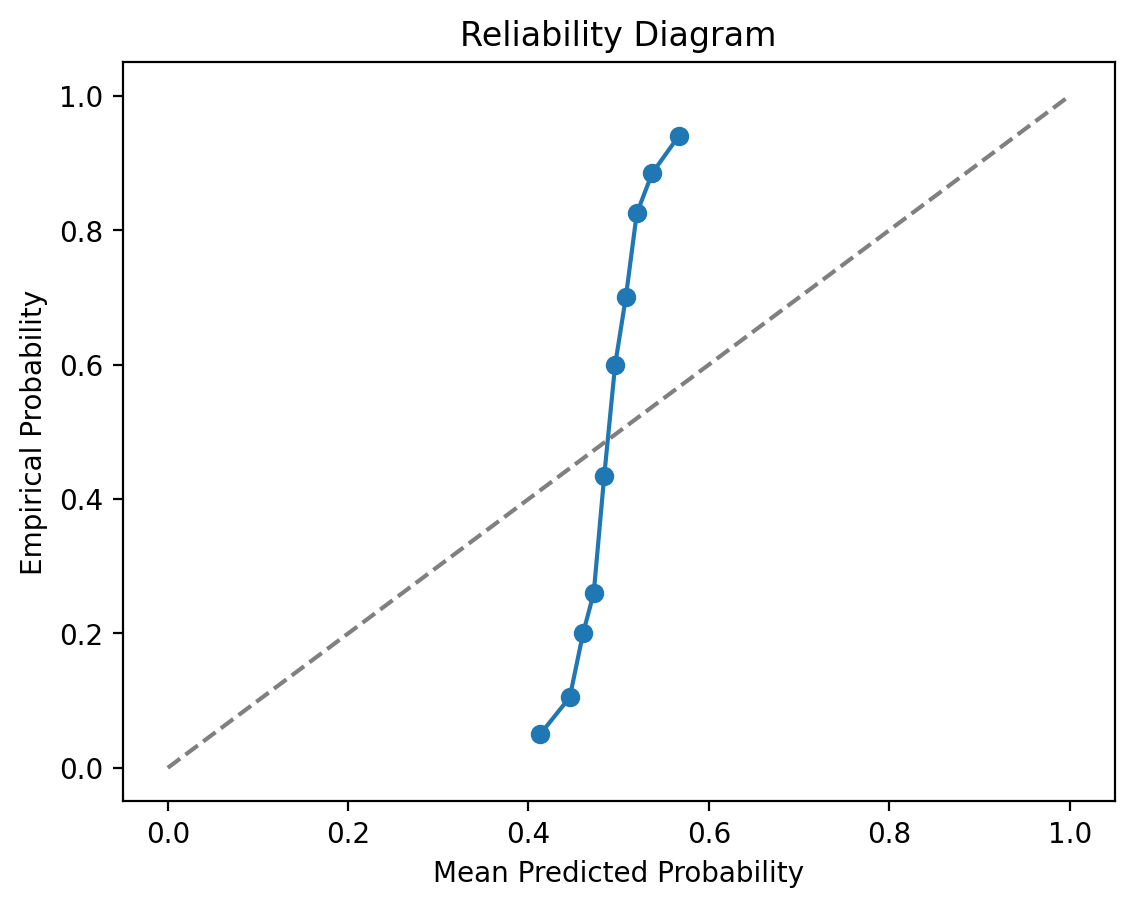

Expected Calibration Error (ECE): 0.0753
Temperature: 4.484


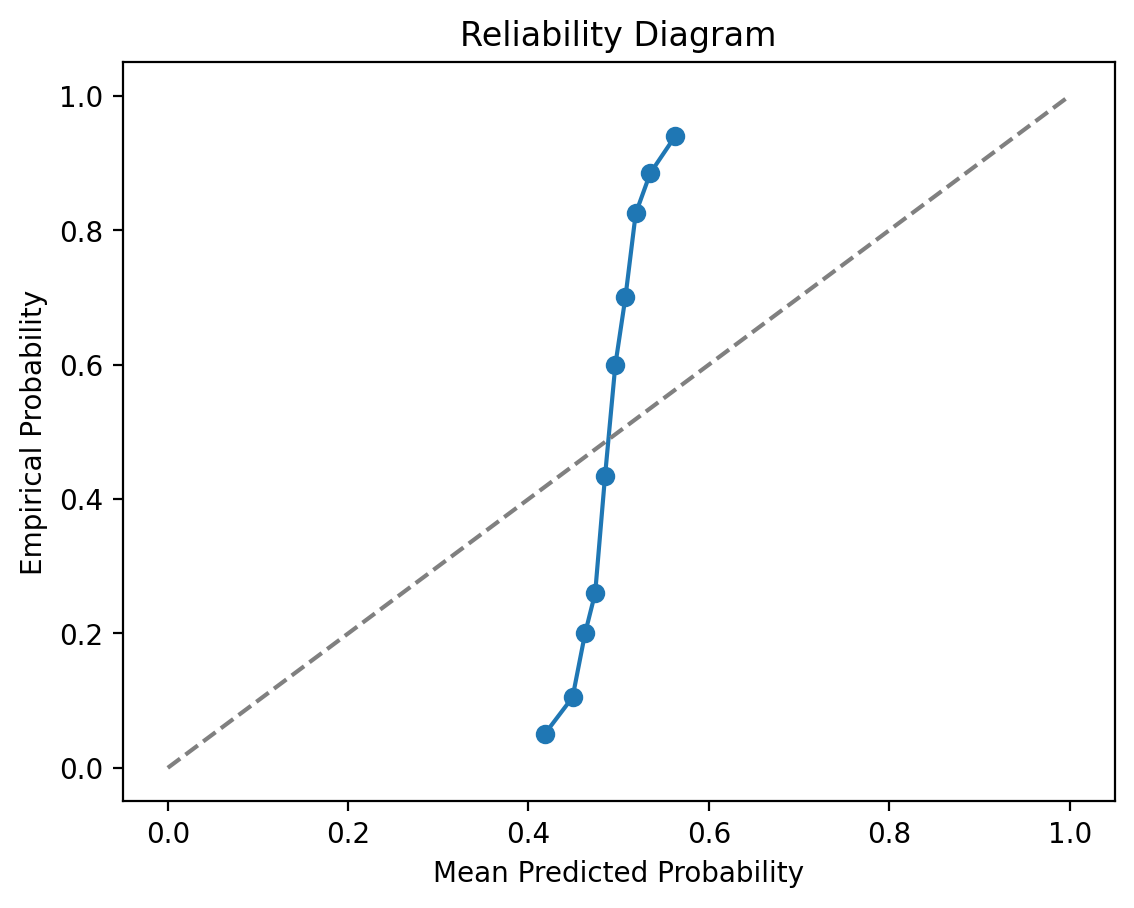

Expected Calibration Error (ECE): 0.0749
Temperature: 4.742


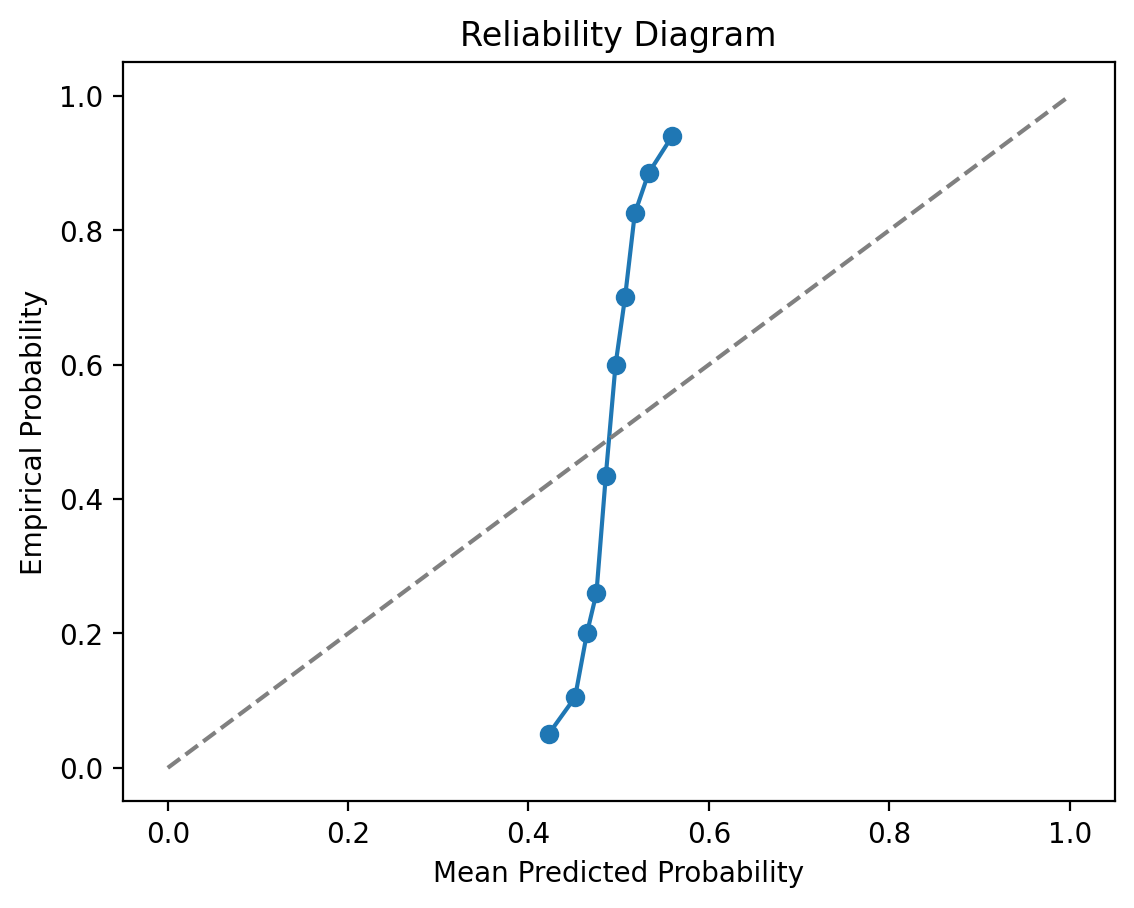

Expected Calibration Error (ECE): 0.0747
Temperature: 5.000


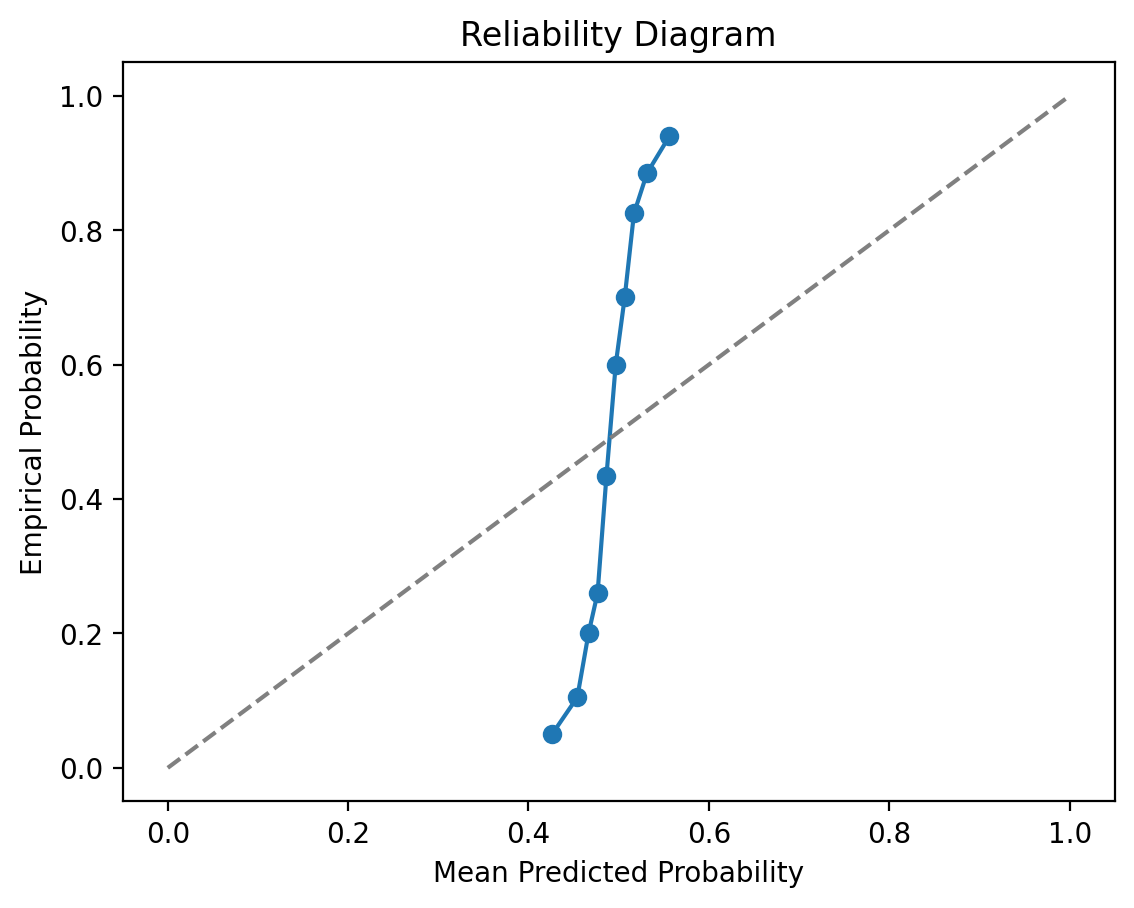

Expected Calibration Error (ECE): 0.0745

Best temperature: 0.358 with ECE: 0.0597


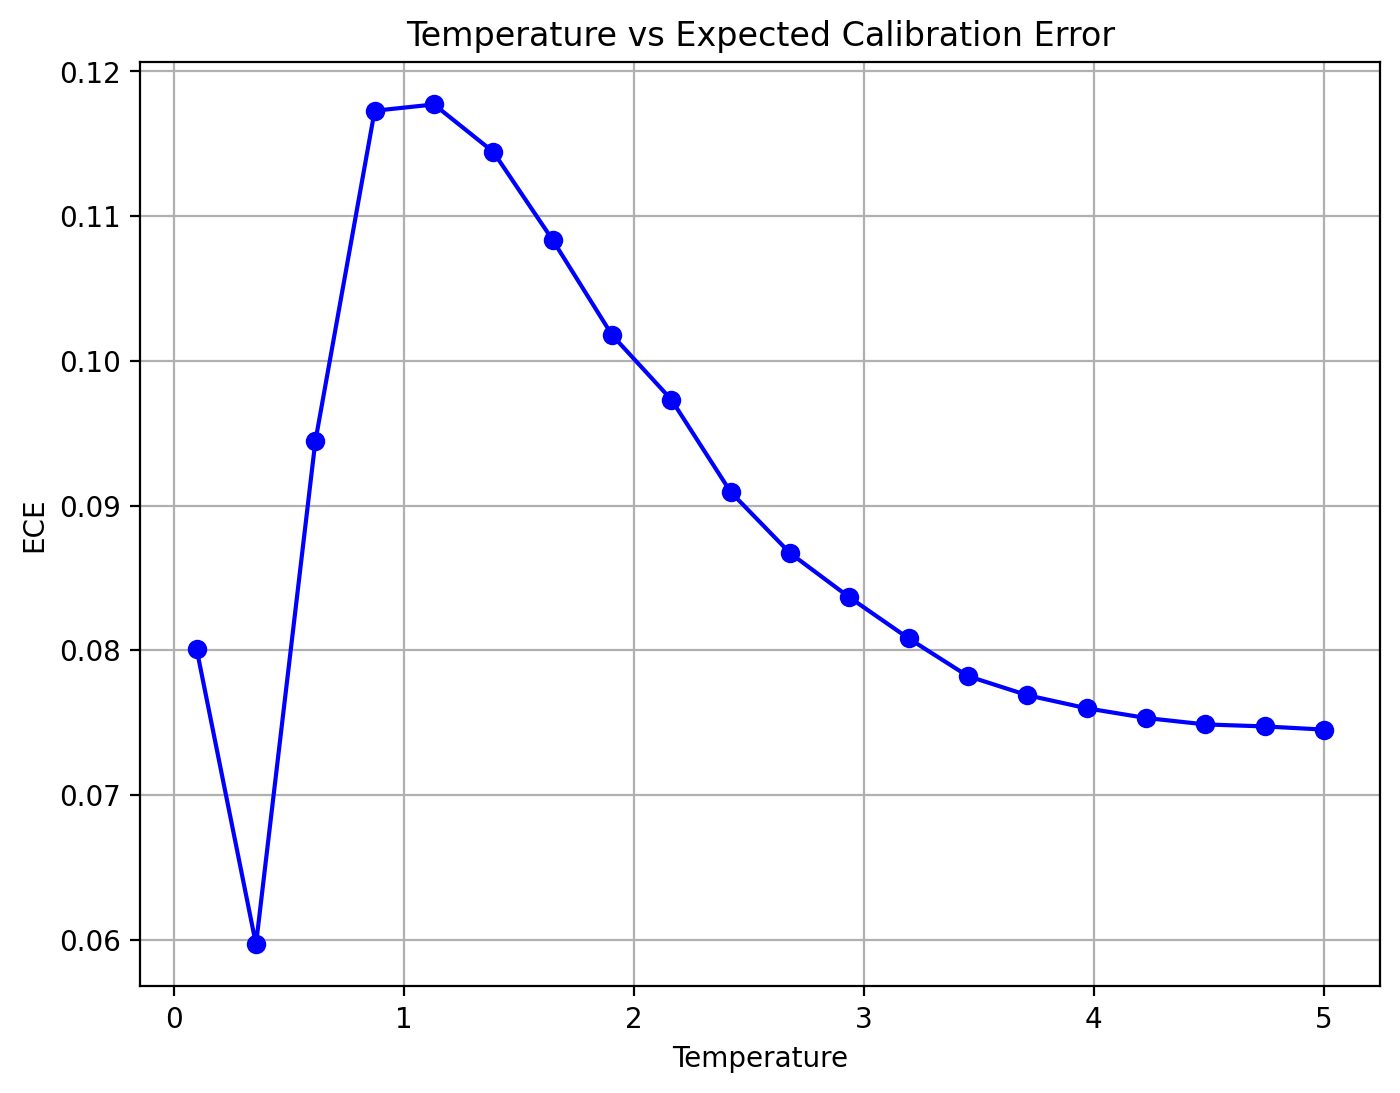

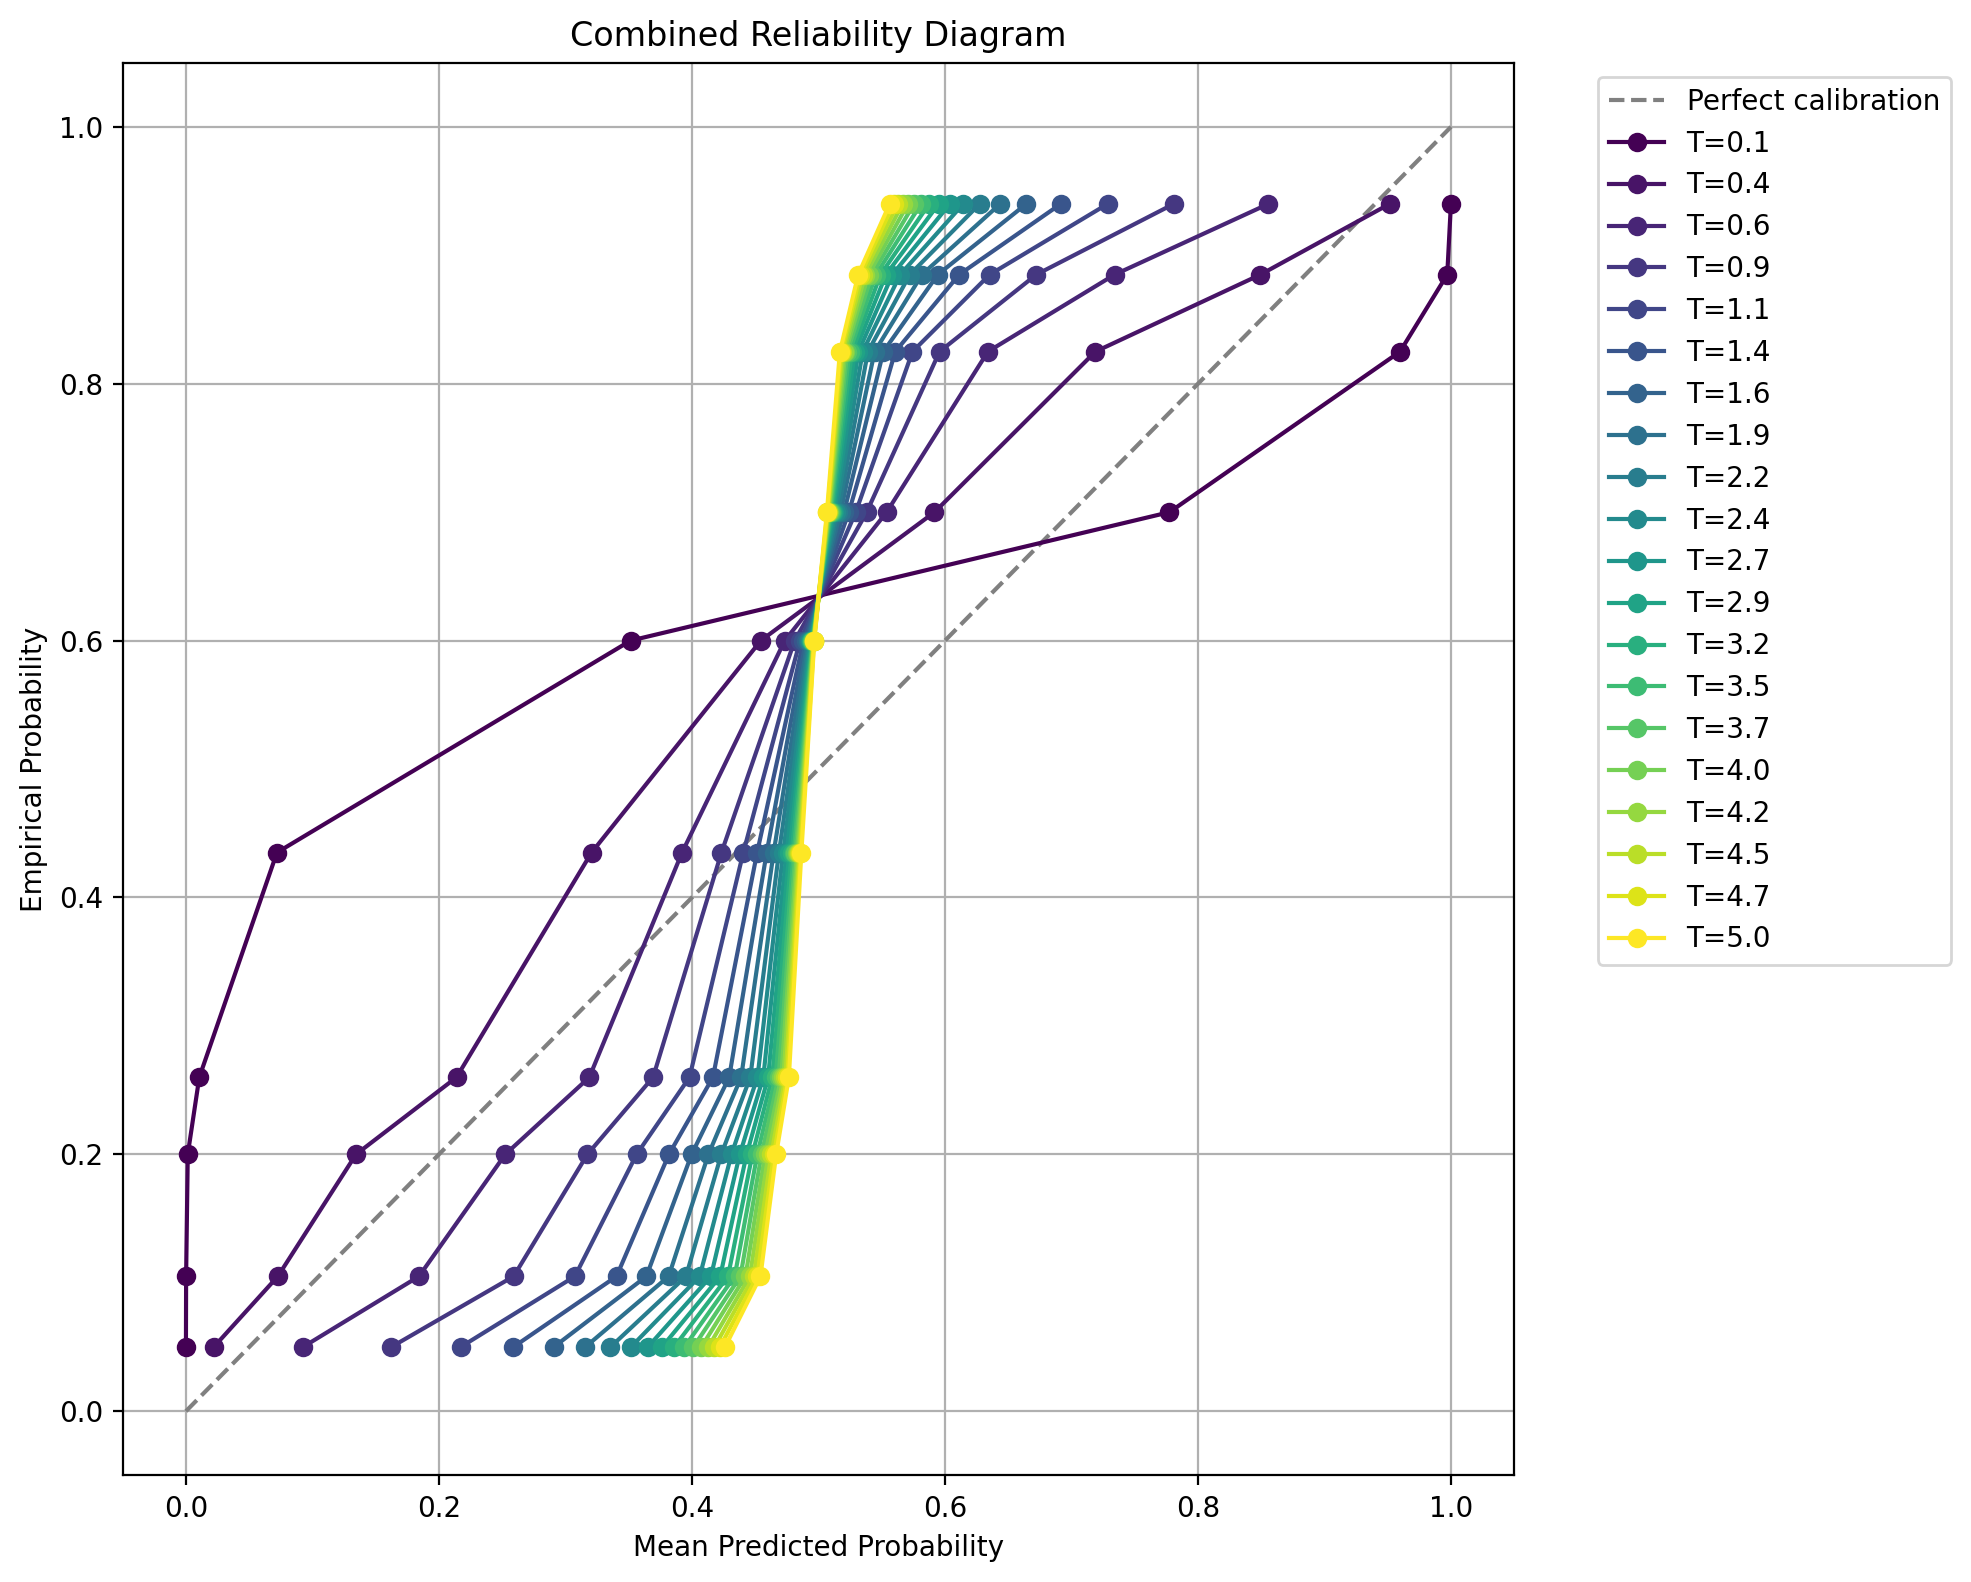

In [46]:
#temperatures = [0.3,0.4,0.5,0.6, 0.75,1.25,1.5]

results_dense = study_temperature_effect('DENSE', trainer.model, test_loader2)

# Conclusion

Like expected the LENET NN was by default better calibrated than the much larger DenseNET that we fine-tuned. After applying temperature scaling btoh netwroks were able to achieve very similar levels of calibration. 